## Imports

In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

## Power Calcs

In [2]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115, 202]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Reading 0 ... 51647  =      0.000 ...   206.588 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 251 original time points ...
0 bad epochs dropped
((), (),

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


Opening raw data file data/202/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51383 =      0.000 ...   205.532 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 251 original time points ...
3 bad epochs dropped
((), (), ('BAD_',), (), (), (), (), (), (), (), (), (), (), ('BAD_',), (), (), (), ('BAD_',), ())


ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.676245e-08  7.966128e-08   
1    100  False     1  LHip3 - LHip4  7.599882e-08  5.435899e-08   
2    100  False     1  LatT1 - LatT2  1.777491e-09  1.945915e-09   
3    100  False     1  LatT3 - LatT4  1.063224e-08  1.579306e-08   
4    100   True     1  LHip1 - LHip2  1.142425e-07  7.161263e-08   
..   ...    ...   ...            ...           ...           ...   
623  202   True     3    LHT3 - LHT4  1.042007e-08  8.687519e-10   
624  202   True     3    LOT1 - LOT2  1.898780e-08  4.586229e-09   
625  202   True     3    LOT3 - LOT4  8.277882e-09  4.419796e-09   
626  202   True     3    LHT1 - LHT2  3.353753e-09  1.279668e-09   
627  202   True     3    LHT3 - LHT4  1.437498e-08  1.089688e-09   

            Alpha          Beta     GammaHigh      GammaLow  Stim_Num  
0    3.897899e-08  1.350653e-08  1.778084e-10  1.014126e-09       0.0  
1    7.955522e-09  3.615457e-09  6.582067e-11  8.472699e-10       0.0  
2    7.836614e-10  2.448647e-10  1.303055e-11  5.035184e-11       0.0  
3    8.962653e-09  1.447087e-09  3.410894e-11  2.195220e-10       0.0  
4    2.537439e-08  1.169223e-08  1.839439e-10  9.902345e-10       1.0  
..            ...           ...           ...           ...       ...  
623  1.712772e-09  5.998392e-10  1.331864e-11  4.582474e-11       4.0  
624  3.352016e-09  2.677703e-09  5.286282e-11  3.338441e-10       6.0  
625  5.411698e-09  2.388939e-09  5.404881e-11  1.987887e-10       6.0  
626  7.131607e-10  4.481172e-10  1.882503e-11  9.922757e-11       6.0  
627  8.153352e-10  3.662438e-10  1.344974e-11  5.989246e-11       6.0  

[628 rows x 11 columns]

In [3]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')

for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100

In [4]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
495  202     3    LHT1 - LHT2  3.353753e-09  1.279668e-09  7.131607e-10   
496  202     3    LHT3 - LHT4  5.957625e-09  1.662203e-09  7.292102e-10   
497  202     3    LHT3 - LHT4  1.140535e-08  1.126939e-09  8.131701e-10   
498  202     3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   
499  202     3    LHT3 - LHT4  1.437498e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  Stim_Num  ...     Alpha_pre  \
0    1.169223e-08    1.839439e-10   9.902345e-10         1  ...  3.897899e-08   
1    8.328850e-09    2.011561e-10   1.225056e-09         2  ...  3.897899e-08   
2    1.402683e-08    1.422396e-10   9.843672e-10         3  ...  3.897899e-08   
3    9.420390e-09    1.094276e-10   5.373972e-10         4  ...  3.897899e-08   
4    3.396220e-09    1.081027e-10   8.468632e-10         1  ...  7.955522e-09   
..            ...             ...            ...       ...  ...           ...   
495  4.481172e-10    1.882503e-11   9.922757e-11         6  ...  1.437852e-09   
496  4.810947e-10    1.787003e-11   3.770633e-11         2  ...  1.598375e-09   
497  4.845502e-10    1.587741e-11   6.965751e-11         3  ...  1.598375e-09   
498  5.998392e-10    1.331864e-11   4.582474e-11         4  ...  1.598375e-09   
499  3.662438e-10    1.344974e-11   5.989246e-11         6  ...  1.598375e-09   

         Beta_pre  GammaHigh_pre  GammaLow_pre  Delta_log_chg  Theta_log_chg  \
0    1.350653e-08   1.778084e-10  1.014126e-09       0.172679      -0.046258   
1    1.350653e-08   1.778084e-10  1.014126e-09      -0.119037      -0.392225   
2    1.350653e-08   1.778084e-10  1.014126e-09      -0.177487      -0.352190   
3    1.350653e-08   1.778084e-10  1.014126e-09       0.051310       0.002394   
4    3.615457e-09   6.582067e-11  8.472699e-10       0.697190       0.141332   
..            ...            ...           ...            ...            ...   
495  5.010032e-10   2.384715e-11  8.178208e-11      -0.116665      -0.522665   
496  5.783503e-10   1.489039e-11  6.646329e-11       0.472117      -0.290108   
497  5.783503e-10   1.489039e-11  6.646329e-11       0.754152      -0.458892   
498  5.783503e-10   1.489039e-11  6.646329e-11       0.714914      -0.571896   
499  5.783503e-10   1.489039e-11  6.646329e-11       0.854651      -0.473490   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaHigh_log_chg  
0        -0.186435     -0.062647         -0.010354           0.014733  
1        -0.271439     -0.209959          0.082064           0.053581  
2        -0.037361      0.016416         -0.012935          -0.096932  
3         0.071756     -0.156475         -0.275796          -0.210825  
4        -0.126444     -0.027167         -0.000208           0.215474  
..             ...           ...               ...                ...  
495      -0.304527     -0.048449          0.083974          -0.102701  
496      -0.340826     -0.079960         -0.246168           0.079219  
497      -0.293497     -0.076852          0.020386           0.027873  
498       0.030021      0.015844         -0.161482          -0.048446  
499      -0.292343     -0.198421         -0.045210          -0.044192  

[500 rows x 22 columns]

## Get Memory Data

In [5]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
# memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)

memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[69 rows x 3 columns]

In [6]:
pd.unique(memory_trials.index)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 115, 200, 201, 202, 205, 206, 207, 208, 209], dtype=int64)

In [7]:
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
mem_res = memory_trials[memory_trials.index.isin(pt_nums)].groupby('ID').mean()
import scipy.stats
scipy.stats.ttest_rel(mem_res['Memory_Score'], mem_res['Avg_Sham'])
# mem_res

Ttest_relResult(statistic=0.21405182032824893, pvalue=0.836608163018635)

In [8]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')
power_and_mem = power_and_mem.dropna()
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')
power_and_mem

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
495  202     3    LHT1 - LHT2  3.353753e-09  1.279668e-09  7.131607e-10   
496  202     3    LHT3 - LHT4  5.957625e-09  1.662203e-09  7.292102e-10   
497  202     3    LHT3 - LHT4  1.140535e-08  1.126939e-09  8.131701e-10   
498  202     3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   
499  202     3    LHT3 - LHT4  1.437498e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  Stim_Num  ...  \
0    1.169223e-08    1.839439e-10   9.902345e-10         1  ...   
1    8.328850e-09    2.011561e-10   1.225056e-09         2  ...   
2    1.402683e-08    1.422396e-10   9.843672e-10         3  ...   
3    9.420390e-09    1.094276e-10   5.373972e-10         4  ...   
4    3.396220e-09    1.081027e-10   8.468632e-10         1  ...   
..            ...             ...            ...       ...  ...   
495  4.481172e-10    1.882503e-11   9.922757e-11         6  ...   
496  4.810947e-10    1.787003e-11   3.770633e-11         2  ...   
497  4.845502e-10    1.587741e-11   6.965751e-11         3  ...   
498  5.998392e-10    1.331864e-11   4.582474e-11         4  ...   
499  3.662438e-10    1.344974e-11   5.989246e-11         6  ...   

     Delta_log_chg  Theta_log_chg  Alpha_log_chg  Beta_log_chg  \
0         0.172679      -0.046258      -0.186435     -0.062647   
1        -0.119037      -0.392225      -0.271439     -0.209959   
2        -0.177487      -0.352190      -0.037361      0.016416   
3         0.051310       0.002394       0.071756     -0.156475   
4         0.697190       0.141332      -0.126444     -0.027167   
..             ...            ...            ...           ...   
495      -0.116665      -0.522665      -0.304527     -0.048449   
496       0.472117      -0.290108      -0.340826     -0.079960   
497       0.754152      -0.458892      -0.293497     -0.076852   
498       0.714914      -0.571896       0.030021      0.015844   
499       0.854651      -0.473490      -0.292343     -0.198421   

     GammaLow_log_chg  GammaHigh_log_chg  Avg_Sham  Memory_Score  \
0           -0.010354           0.014733  7.666667             4   
1            0.082064           0.053581  7.666667             4   
2           -0.012935          -0.096932  7.666667             4   
3           -0.275796          -0.210825  7.666667             4   
4           -0.000208           0.215474  7.666667             4   
..                ...                ...       ...           ...   
495          0.083974          -0.102701  5.333333             7   
496         -0.246168           0.079219  5.333333             7   
497          0.020386           0.027873  5.333333             7   
498         -0.161482          -0.048446  5.333333             7   
499         -0.045210          -0.044192  5.333333             7   

     Delay_Mem_Stim  Delay_Mem_Sham  
0               4.0               5  
1               4.0               5  
2               4.0               5  
3               4.0               5  
4               4.0               5  
..              ...             ...  
495             5.0               2  
496             5.0               2  
497             5.0               2  
498             5.0               2  
499             5.0               2  

[500 rows x 26 columns]

In [9]:
three_word_groups = pd.read_csv('three_words_delay.csv')

In [10]:
# pt 103 had 5 stims on trials 2 and 3. We'll asssume that the 5th was administered after all 12 words were presented
power_log_chg = power_log_chg[power_log_chg['Stim_Num'] != 5]
power_mem_3 = power_log_chg.merge(three_word_groups, left_on='ID', right_on='Participant_Number')

In [11]:
power_mem_3['Prev_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_1_3']
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_4_6'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_7_9'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 4), 'Words_10_12'])

In [12]:
power_mem_3['Next_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_4_6']
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_7_9'])
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_10_12'])

In [13]:
power_mem_3 = power_mem_3.dropna()

## Mixed Effects Models

In [14]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

In [15]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

## End Setup

## Correlations

In [4]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [19]:
from sklearn.linear_model import LinearRegression

freqs_short = [
    '0.1-3.0',
    '4-7',
    '8-12',
    '13-30',
    '40-57',
    '67-100',
]

def do_stats(power_and_mem, xlabel, ylabel, xlog=False, ylog=False):
    model = LinearRegression()

    fig, axs = plt.subplots(2, 2)
    # fig.suptitle(f"{xlabel.replace('$FREQ', 'Power')} vs {ylabel.replace('$FREQ', 'Power')}")
    fig.suptitle('Strength of Correlation between Pre-stim and Post-Stim ECoG Power')
    fig.set_size_inches(16, 12)

    for i, chan in enumerate(hip_chans):
        corrs = []
        power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
        for freq in freqs:
            xfeature = xlabel.replace('$FREQ', freq) if '$FREQ' in xlabel else xlabel
            yfeature = ylabel.replace('$FREQ', freq) if '$FREQ' in ylabel else ylabel
            X = power_for_chan[[xfeature]]
            if xlog:
                X = np.log10(X)
            Y = power_for_chan.eval(yfeature)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
            # print(f"{chan}, {freq}: r^2 = {corrs[-1]}")

        if '$FREQ' not in ylabel:
            X = pd.get_dummies(power_for_chan['ID'])
            Y = power_for_chan.eval(ylabel)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
        # else:
        #     corrs.append(0)

        ind = np.arange(len(corrs))
        colors = ['tab:orange' for _ in corrs]
        # colors[-1] = 'tab:blue'
        axs[i//2, i%2].bar(ind, corrs, color=colors)
        axs[i//2, i%2].set_xticks(ind, labels=[*freqs_short]) # [*freqs_short, 'ID']
        axs[i//2, i%2].set_xlabel('Frequency Band (Hz)')
        axs[i//2, i%2].set_ylabel('$R^2$')
        axs[i//2, i%2].set_title(chan)
        axs[i//2, i%2].set_ylim(0, 1)

John said to start by seeing if PRE-stim power predicts POST-stim power. I made sure to take the log here since the powers can differ by orders of magnitude. Not taking the log results in only the strongest relationships showing up, but that might very well be skewed by one outlier patient

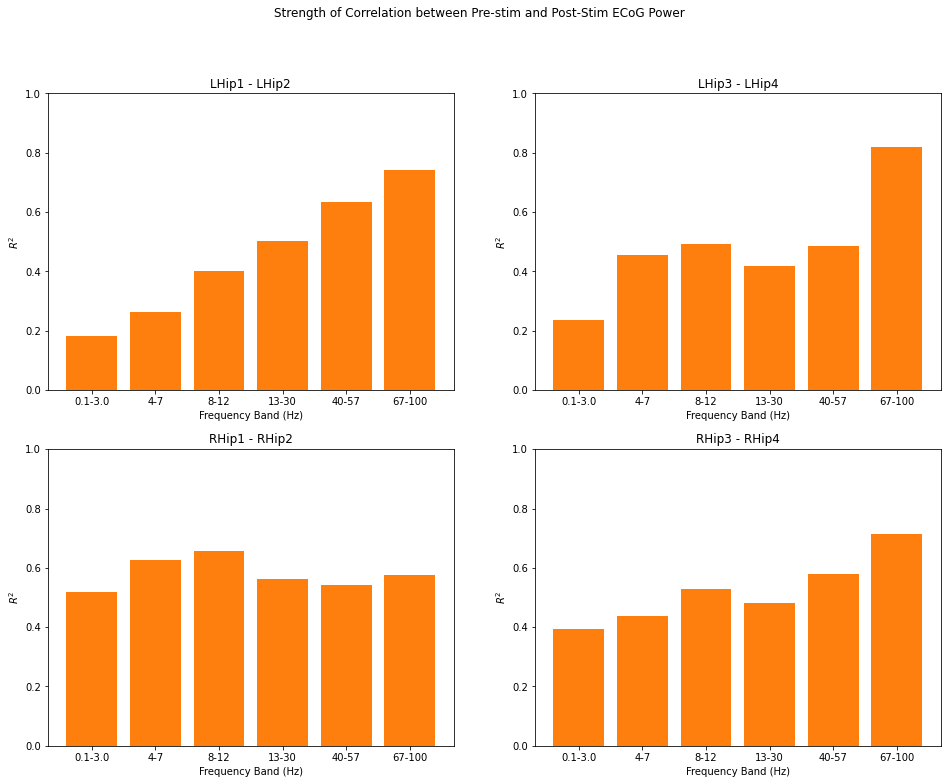

In [20]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_post', xlog=True, ylog=True)

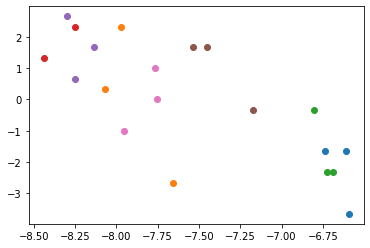

In [21]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

fig, ax = plt.subplots()
power_for_chan = df_averaged[df_averaged['Channel'] == 'LHip3 - LHip4']
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['Delta_post']), power_for_pt['Memory_Score'] - power_for_pt['Avg_Sham'])

In [22]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

In [23]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = df_averaged[df_averaged['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

PatsyError: Error evaluating factor: NameError: name 'Change_in_Memory' is not defined
    Change_in_Memory ~ np.log10(Delta_post) + np.log10(Theta_post) + np.log10(Alpha_post) + np.log10(Beta_post) + np.log10(GammaLow_post) + np.log10(GammaHigh_post)
    ^^^^^^^^^^^^^^^^

In [ ]:
from typing import Literal
def mixed_effects_stats(power_and_mem, x, y, xlabel=None, ylabel=None, baselines_only=False,
    mem_null_hyp=0, show_all_p=False, linreg_pval: Literal['t', 'perm', 'kendall']='t',
    force_avg: Literal['full', 'partial', 'stim', None] =None,
    freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    ):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y

    df = power_and_mem
    if baselines_only:
        df = power_and_mem.drop_duplicates(subset=['ID', 'Trial', 'Channel'])

    # if you're looking at short-term memory, which is measured after each trial,
    # per-stim analyses are invalid. Aggregate df and group by trial to get meaningful results
    x_evald = False
    if force_avg == 'full' or 'Delay_Mem_Stim' in y:
        print('Averaging across stims and trials in the same patient and channel')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[x_for_freq] = df.groupby(['ID', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True
    elif force_avg == 'partial' or 'Memory_Score' in y:
        print('Averaging across stims in the same patient, channel, and trial')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[freq] = df.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Trial', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True
    elif force_avg == 'stim':
        print('Averaging across trials in the same patient, channel, and stim')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[x_for_freq] = df.groupby(['ID', 'Stim_Num', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Stim_Num', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Stim_Num', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True

    num_cols = len(freqs) // 2 + 1
    hist_fig, hist_ax = plt.subplots(2, num_cols)
    hist_fig.set_size_inches(10, 8)

    fig, ax = plt.subplots(2, num_cols)
    fig.set_size_inches(12, 8)
    for i in range(len(freqs)):
        freq = freqs[i]
        xs = df[freq] if x_evald else df.eval(x.replace('$FREQ', freq))
        ys = df.eval(y)
        ax[i//num_cols, i%num_cols].scatter(xs, ys)
        ax[i//num_cols, i%num_cols].set_title(freq)

        hist_ax[i//num_cols, i%num_cols].hist(xs)
        hist_ax[i//num_cols, i%num_cols].set_title(freq)

    hist_ax[1, num_cols-1].hist(ys)
    hist_ax[1, num_cols-1].set_title(ylabel)

    if y == 'Memory_Score - Avg_Sham':
        df['Change_in_Memory'] = df['Memory_Score'] - df['Avg_Sham']

    temp_stats = []
    temp_chi = []

    for chan in hip_chans:
        fig, ax = plt.subplots(2, num_cols)
        fig.set_size_inches(14, 10)
        fig.suptitle(chan)
        power_for_chan = df[df['Channel'] == chan]
        for i in range(len(freqs)):
            freq = freqs[i]
            for pt_id in power_for_chan['ID'].unique():
                power_for_pt = power_for_chan[power_for_chan['ID'] == pt_id]
                xs = power_for_pt[freq] if x_evald else power_for_pt.eval(x.replace('$FREQ', freq))
                ys = power_for_pt.eval(y)
                ax[i//num_cols, i%num_cols].scatter(xs, ys)
            ax[i//num_cols, i%num_cols].set_title(freq)
            ax[i//num_cols, i%num_cols].set_xlabel(xlabel)
            ax[i//num_cols, i%num_cols].set_ylabel(ylabel)

            xs = power_for_chan[freq] if x_evald else power_for_chan.eval(x.replace('$FREQ', freq))
            ys = power_for_chan.eval(y)
            result = scipy.stats.linregress(xs, ys)
            line_x = np.array([xs.min(), xs.max()])
            ax[i//num_cols, i%num_cols].plot(line_x, result.slope * line_x + result.intercept, linestyle='--')

            # Ran into a problem with chi square because I have very low counts, switching to Fisher's exact
            # reuqires 2-way table, so no change was dropped. idk if that is legal tho
            inc_pow = xs > 0
            dec_pow = xs < 0
            inc_mem = power_for_chan.eval(y) > mem_null_hyp
            # nc_mem = power_for_chan.eval(y) == 0
            dec_mem = power_for_chan.eval(y) < mem_null_hyp
            crosstab = pd.DataFrame([
                [len(power_for_chan[dec_pow & dec_mem]), len(power_for_chan[inc_pow & dec_mem])],
                # [len(power_for_chan[dec_pow & nc_mem]), len(power_for_chan[inc_pow & nc_mem])],
                [len(power_for_chan[dec_pow & inc_mem]), len(power_for_chan[inc_pow & inc_mem])],
            ])
            crosstab.columns = pd.MultiIndex.from_tuples([('Power', 'Decrease'), ('Power', 'Increase')])
            # crosstab.index = pd.MultiIndex.from_tuples([('Memory', 'Decrease'), ('Memory', 'No Change'), ('Memory', 'Increase')])
            crosstab.index = pd.MultiIndex.from_tuples([('Memory', 'Decrease'), ('Memory', 'Increase')])
            chi_sq_p = scipy.stats.fisher_exact(crosstab)[1]
            temp_chi.append({'Channel': chan, 'Frequency': freq, 'P':chi_sq_p})
            if chi_sq_p < 0.50: # TODO reset threshold
                print(f'Fisher Exact P-value = {chi_sq_p} for {freq} band in {chan}')
                display(crosstab)
        
        
        formula = "Change_in_Memory ~ "
        for freq in freqs:
            formula += freq + " + "
        formula = formula[:-3] # removes the last  " + "
        print(power_for_chan.columns)
        model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
        result = model.fit()
        print(chan+":")
        display(result.summary())

Averaging across stims in the same patient, channel, and trial
Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')
LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.1981          
Min. group size:  3       Log-Likelihood:     -29.7337        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      11.585    32.992   0.351  0.725  -53.077  76.248
Delta          -0.035                                          
Theta           0.820     0.447   1.833  0.067   -0.057   1.696
Alpha          -1.427     0.388  -3.675  0.000   -2.189  -0.666
Beta            0.920     0.724   1.271  0.204   -0.499   2.339
GammaLow        0.529     0.389   1.361  0.174   -0.233   1.292
GammaMed        0.863     1.028   0.840  0.401   -1.152   2.879
GammaHigh      -3.051     0.993  -3.074  0.002   -4.996  -1.106
GammaXHigh      1.555     0.662   2.350  0.019    0.258   2.852
Group Var       0.008                                          
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.066841
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              1.6556          
Min. group size:  3       Log-Likelihood:     -30.2836        
Max. group size:  3       Converged:          No              
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -1.425    23.575  -0.060  0.952  -47.631  44.782
Delta          -0.361     0.451  -0.799  0.424   -1.245   0.524
Theta          -0.217     0.375  -0.579  0.563   -0.951   0.517
Alpha          -0.108     0.686  -0.158  0.875   -1.454   1.237
Beta            0.426     1.296   0.329  0.742   -2.113   2.966
GammaLow        0.008     0.549   0.014  0.989   -1.069   1.084
GammaMed       -0.244     1.420  -0.172  0.863   -3.028   2.539
GammaHigh       0.642     1.821   0.352  0.725   -2.927   4.211
GammaXHigh     -0.266     1.150  -0.231  0.817   -2.521   1.988
Group Var       0.017     4.459                                
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')
RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.2362          
Min. group size:  3       Log-Likelihood:     -32.8402        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     -10.087    13.719  -0.735  0.462  -36.975  16.802
Delta           0.125     0.155   0.809  0.419   -0.178   0.429
Theta          -0.244     0.600  -0.406  0.685   -1.420   0.933
Alpha          -0.233     0.770  -0.302  0.763   -1.742   1.277
Beta            0.913     0.684   1.334  0.182   -0.428   2.255
GammaLow       -1.236     0.556  -2.222  0.026   -2.326  -0.146
GammaMed        0.809     0.386   2.096  0.036    0.053   1.566
GammaHigh       0.577     0.641   0.901  0.368   -0.678   1.833
GammaXHigh     -0.789     0.443  -1.783  0.075   -1.656   0.078
Group Var       0.000                                          
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')
RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 15      Method:             REML            
No. Groups:       5       Scale:              0.9581          
Min. group size:  3       Log-Likelihood:     -23.9018        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|   [0.025    0.975]
---------------------------------------------------------------
Intercept   -52.073    99.955  -0.521  0.602  -247.980  143.835
Delta         0.096     0.887   0.108  0.914    -1.643    1.835
Theta        -0.331     0.866  -0.382  0.702    -2.027    1.366
Alpha         0.830     0.662   1.253  0.210    -0.468    2.127
Beta         -0.106     0.554  -0.191  0.849    -1.192    0.981
GammaLow     -0.589     0.518  -1.138  0.255    -1.603    0.426
GammaMed     -0.090     2.043  -0.044  0.965    -4.095    3.915
GammaHigh     0.220     2.412   0.091  0.927    -4.508    4.947
GammaXHigh   -0.472     1.639  -0.288  0.773    -3.685    2.740
Group Var    11.058    19.660                                  
==============================================================

"""

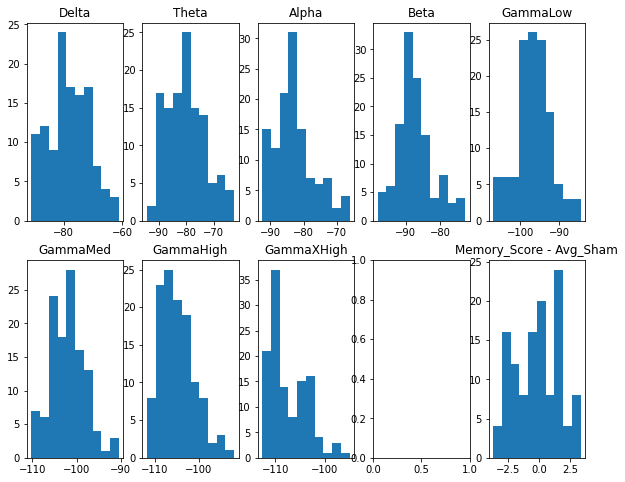

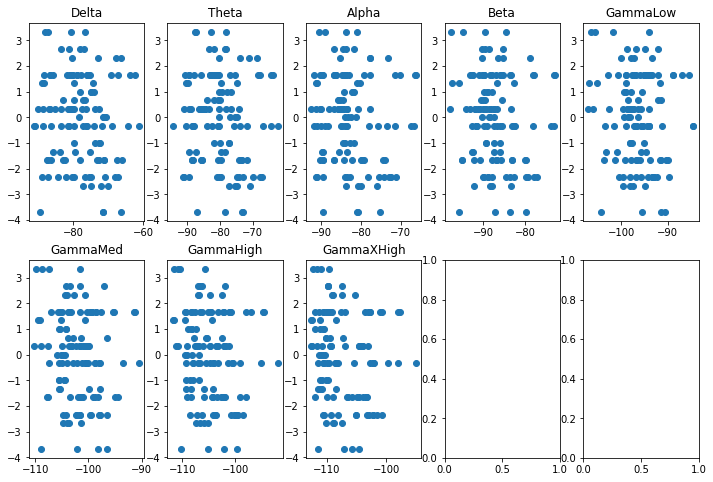

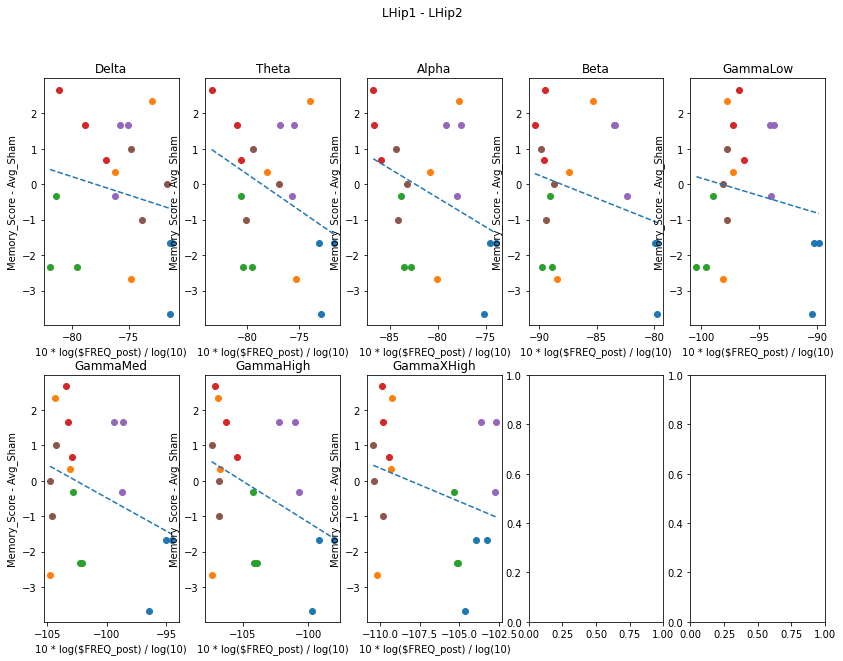

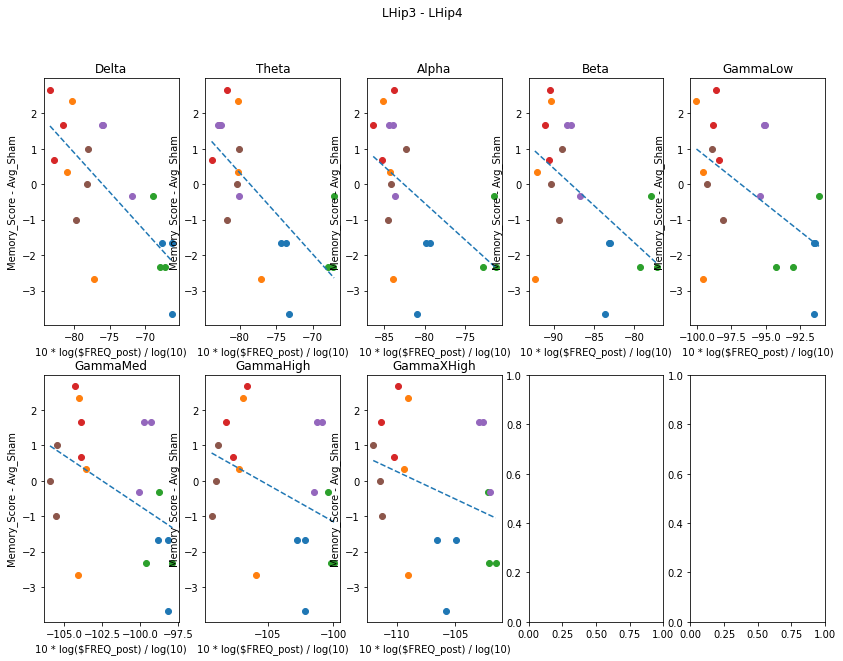

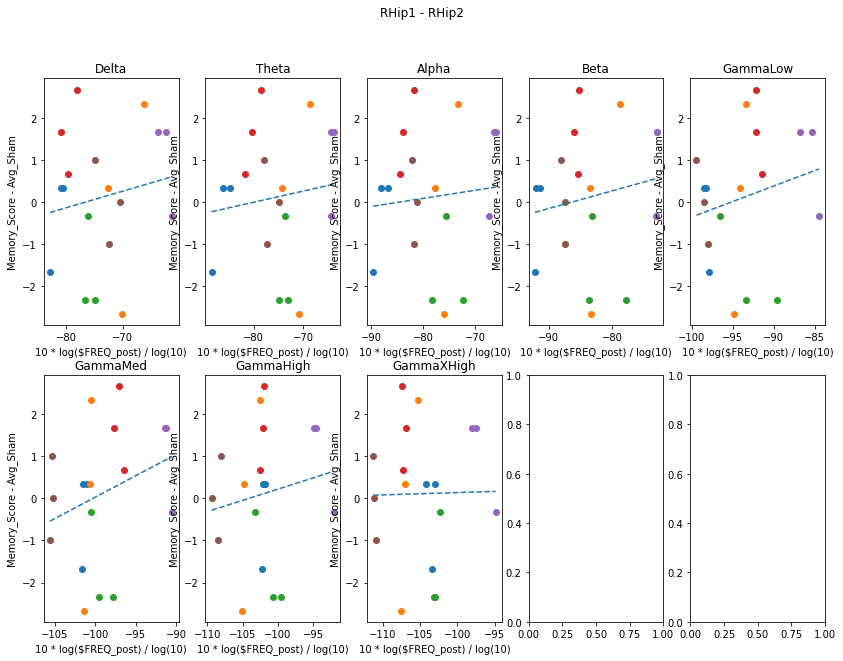

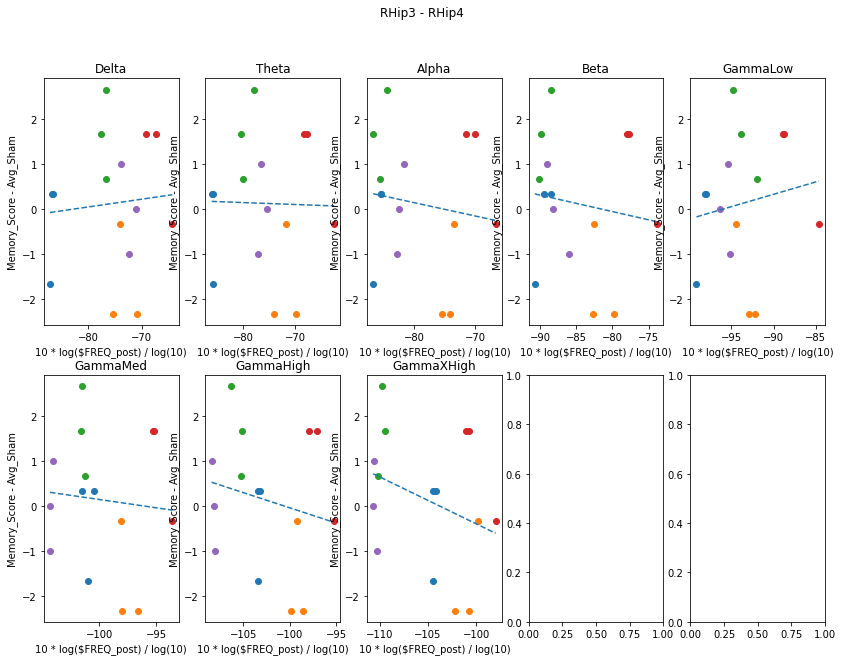

In [ ]:
mixed_effects_stats(power_and_mem, '10 * log($FREQ_post) / log(10)', 'Memory_Score - Avg_Sham', freqs=freqs, force_avg='partial')

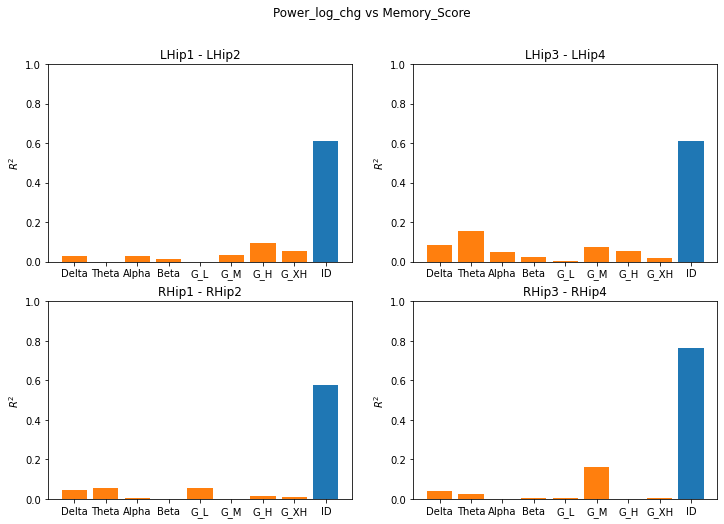

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score')

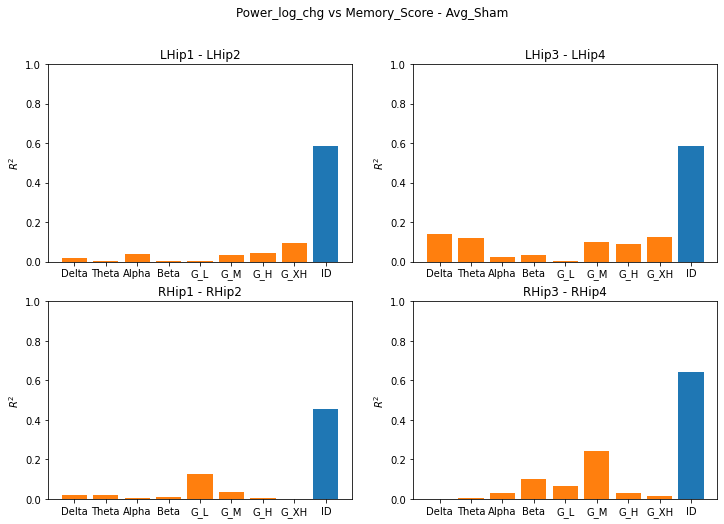

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham')

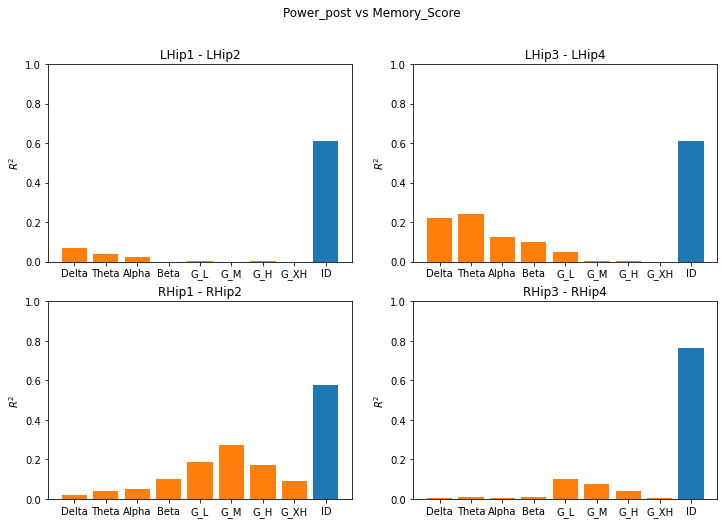

In [ ]:
do_stats(power_and_mem, '$FREQ_post', 'Memory_Score', xlog=True)

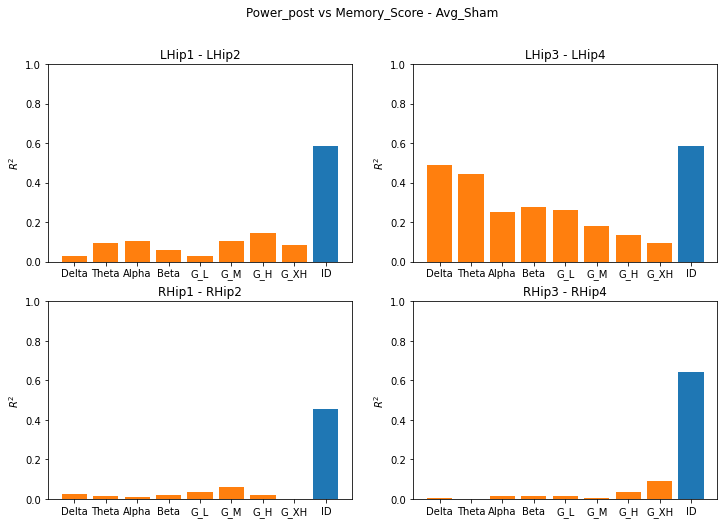

In [ ]:
do_stats(power_and_mem, '$FREQ_post', 'Memory_Score - Avg_Sham', xlog=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
model = LinearRegression()
def bar_and_test(power_and_mem, xlabel, ylabel, xlog=False, ylog=False):
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(f"{xlabel.replace('$FREQ', 'Power')} vs {ylabel.replace('$FREQ', 'Power')}")
    fig.set_size_inches(12, 8)

    for i, chan in enumerate(hip_chans):
        corrs = []
        power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
        for freq in freqs:
            xfeature = xlabel.replace('$FREQ', freq) if '$FREQ' in xlabel else xlabel
            yfeature = ylabel.replace('$FREQ', freq) if '$FREQ' in ylabel else ylabel
            X = power_for_chan[xfeature]
            if xlog:
                X = np.log10(X)
            Y = power_for_chan.eval(yfeature)
            if ylog:
                Y = np.log10(Y)
            result = linregress(X, Y)
            print(f"{chan}, {freq}: P = {result.pvalue}")

        if '$FREQ' not in ylabel:
            X = pd.get_dummies(power_for_chan['ID'])
            Y = power_for_chan.eval(ylabel)
            if ylog:
                Y = np.log10(Y)
            result = linregress(X, Y)
            print(f"{chan}, ID: P = {result.pvalue}, R^2 = {result.rvalue ** 2}")
        else:
            corrs.append(0)

        ind = np.arange(len(corrs))
        colors = ['tab:orange' for _ in corrs]
        colors[-1] = 'tab:blue'
        axs[i//2, i%2].bar(ind, corrs, color=colors)
        axs[i//2, i%2].set_xticks(ind, labels=[*freqs_short, 'ID'])
        axs[i//2, i%2].set_ylabel('$R^2$')
        axs[i//2, i%2].set_title(chan)
        axs[i//2, i%2].set_ylim(0, 1)

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = df_averaged[df_averaged['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.ols(formula, power_for_chan)
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1.700
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.223
Time:                        17:47:10   Log-Likelihood:                -28.056
No. Observations:                  18   AIC:                             74.11
Df Residuals:                       9   BIC:                             82.13
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.1165     31.639     -0.288      0.780     -80.689      62.456
np.log10(Delta_post)          0.2152      3.452      0.062      0.952      -7.593       8.024
np.log10(Theta_post)          4.9313      7.865      0.627      0.546     -12.860      22.722
np.log10(Alpha_post)        -12.8961      9.500     -1.358      0.208     -34.386       8.594
np.log10(Beta_post)          12.9198     10.967      1.178      0.269     -11.889      37.729
np.log10(GammaLow_post)       2.5031      7.868      0.318      0.758     -15.296      20.302
np.log10(GammaMed_post)       6.5024      9.686      0.671      0.519     -15.410      28.414
np.log10(GammaHigh_post)    -25.4480     10.994     -2.315      0.046     -50.319      -0.577
np.log10(GammaXHigh_post)    11.1442      6.219      1.792      0.107      -2.924      25.212
==============================================================================
Omnibus:                        4.806   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                2.985
Skew:                          -0.988   Prob(JB):                        0.225
Kurtosis:                       3.276   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     3.584
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0373
Time:                        17:47:10   Log-Likelihood:                -23.458
No. Observations:                  18   AIC:                             64.92
Df Residuals:                       9   BIC:                             72.93
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.5725     20.321     -0.422      0.683     -54.542      37.397
np.log10(Delta_post)         -2.6939      1.998     -1.348      0.210      -7.213       1.826
np.log10(Theta_post)         -2.8198      2.502     -1.127      0.289      -8.479       2.840
np.log10(Alpha_post)         -0.7174      4.013     -0.179      0.862      -9.796       8.361
np.log10(Beta_post)           4.3252      4.064      1.064      0.315      -4.869      13.519
np.log10(GammaLow_post)      -1.8382      4.548     -0.404      0.696     -12.127       8.450
np.log10(GammaMed_post)      -2.0152      5.844     -0.345      0.738     -15.235      11.204
np.log10(GammaHigh_post)      6.9606      8.031      0.867      0.409     -11.206      25.127
np.log10(GammaXHigh_post)    -3.0534      5.383     -0.567      0.584     -15.231       9.124
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   2.681
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.491
Skew:                          -0.079   Prob(JB):                        0.782
Kurtosis:                       2.206   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


RHip1 - RHip2:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.7848
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.628
Time:                        17:47:10   Log-Likelihood:                -28.913
No. Observations:                  18   AIC:                             75.83
Df Residuals:                       9   BIC:                             83.84
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -5.9561     14.651     -0.407      0.694     -39.099      27.187
np.log10(Delta_post)          0.1940      3.335      0.058      0.955      -7.349       7.737
np.log10(Theta_post)          1.5742      6.576      0.239      0.816     -13.302      16.450
np.log10(Alpha_post)         -4.4169      5.765     -0.766      0.463     -17.459       8.626
np.log10(Beta_post)           5.6506      5.372      1.052      0.320      -6.501      17.802
np.log10(GammaLow_post)      -8.5428      6.936     -1.232      0.249     -24.233       7.148
np.log10(GammaMed_post)       7.3506      5.158      1.425      0.188      -4.319      19.020
np.log10(GammaHigh_post)      1.9943      4.887      0.408      0.693      -9.060      13.048
np.log10(GammaXHigh_post)    -4.3124      4.431     -0.973      0.356     -14.337       5.712
==============================================================================
Omnibus:                        0.691   Durbin-Watson:                   2.635
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.689
Skew:                          -0.379   Prob(JB):                        0.709
Kurtosis:                       2.412   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.8139
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.617
Time:                        17:47:10   Log-Likelihood:                -21.392
No. Observations:                  15   AIC:                             60.78
Df Residuals:                       6   BIC:                             67.16
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    44.4262     33.630      1.321      0.235     -37.863     126.716
np.log10(Delta_post)          8.0386      6.229      1.291      0.244      -7.203      23.280
np.log10(Theta_post)        -11.3343      8.588     -1.320      0.235     -32.348       9.679
np.log10(Alpha_post)          7.2451      6.022      1.203      0.274      -7.490      21.980
np.log10(Beta_post)          -7.1079      5.256     -1.352      0.225     -19.969       5.754
np.log10(GammaLow_post)       0.0079      3.399      0.002      0.998      -8.309       8.324
np.log10(GammaMed_post)      16.8927     11.362      1.487      0.188     -10.908      44.693
np.log10(GammaHigh_post)     -9.4308     10.436     -0.904      0.401     -34.968      16.106
np.log10(GammaXHigh_post)     0.0761      6.298      0.012      0.991     -15.334      15.487
==============================================================================
Omnibus:                        1.309   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                0.798
Skew:                           0.073   Prob(JB):                        0.671
Kurtosis:                       1.880   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Stats Pipeline

# Organized

## 1a) Can you predict POST-STIM power using PRE-STIM power?

Yes. Look at the graph below, which illustrates the very high $R^2$ values for each frequency band. These $R^2$ values are for linear regression using the PRE-stim power to predict the POST-stim power in the same frequency band. Note that I am taking the `log` of both pre and post-stim power, since the values differ by orders of magnitude. An interesting pattern is that in the posterior leads, the correlation is stronger at higher frequencies. To me, this indicates that there are other factors that affect the stim response at lower frequencies. This is an incidental finding, though, and I don't care to interpret it too much.

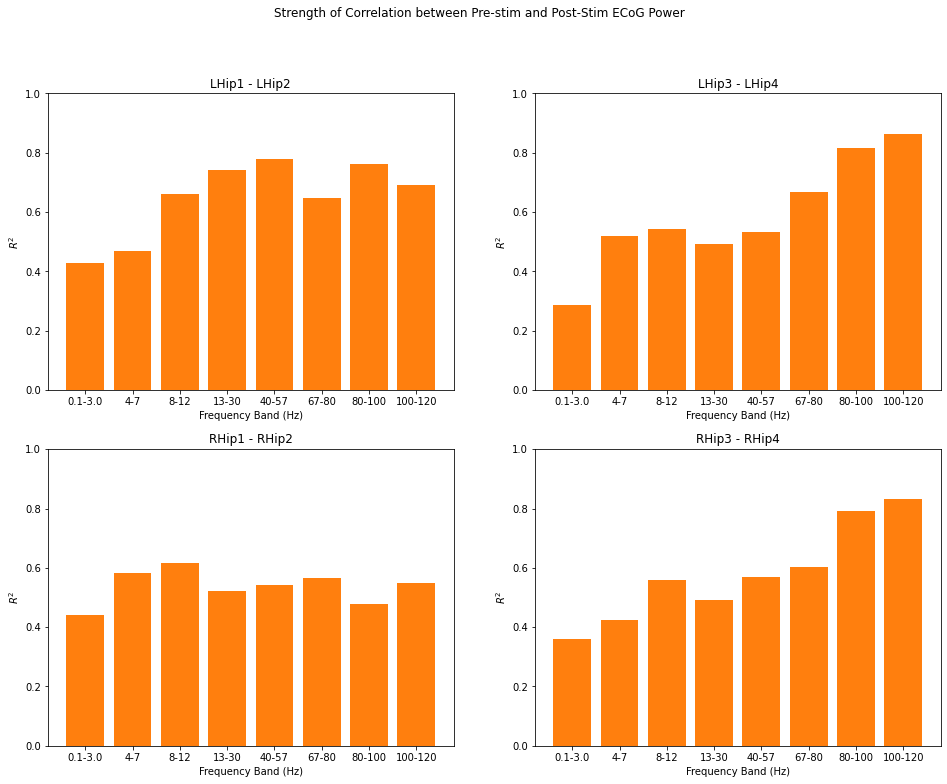

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_post', xlog=True, ylog=True)

Those bar graphs are nice and all, but how do we *know* that the correlations are actually statistically significant? Well, we can run the t-test on the slopes, and the resulting P-values are some of the smallest I've ever laid my eyes on.. For simplicity's sake, I've run the analysis on all channels together, but I'm sure that if we separated it by channel, the correlations would only be stronger since it would reduce the between-channel variation.

In [ ]:
from scipy.stats import linregress

for freq in freqs:
    results = linregress(np.log10(power_and_mem[freq+'_pre']), np.log10(power_and_mem[freq+'_post']))
    print(f"{freq}: t = {results.slope / results.stderr} P = {results.pvalue}")

Delta: t = 21.534917780391112 P = 6.636391246023403e-72
Theta: t = 29.390294814985253 P = 3.574462977114505e-108
Alpha: t = 30.04969993170153 P = 4.078110867508155e-111
Beta: t = 27.980471933792185 P = 8.143183889138196e-102
GammaLow: t = 35.19724060651209 P = 2.442261770063366e-133
GammaMed: t = 32.31424392528831 P = 4.628278806576213e-121
GammaHigh: t = 34.381836802286024 P = 6.537404357422602e-130
GammaXHigh: t = 36.6209024842115 P = 3.087126810686843e-139


Therefore, we can definitively conclude that POST-stim power *does* depend on PRE-stim power

I wonder how this relates to our earlier question of, "is POST-stim power significantly different from PRE-stim power?" If the powers are not different, then I feel like they'd have to be correlated, but if they are different, they may or may not. For example, if POST is 2x PRE, then they will be tightly correlated but they will also be significantly different. On the other hand, the POST distribution could be completely different from PRE as well.

In [ ]:
p_vals = pd.DataFrame(columns=freqs)
p_vals['Channel'] = []
p_vals = p_vals.set_index('Channel')
for ch in hip_chans:
    results = mne.stats.permutation_t_test(
        power_log_chg.loc[power_log_chg['Channel'] == ch,'Delta_log_chg':'GammaXHigh_log_chg'].to_numpy(),
        n_permutations=1000
    )[0]
    p_vals.loc[ch] = results

p_vals

Permuting 999 times...
Permuting 999 times...
Permuting 999 times...
Permuting 999 times...


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2 -1.987419 -3.344134 -1.375293 -1.651428 -0.634792  0.279848   
LHip3 - LHip4  4.186410  0.612612  0.248454 -0.783323 -1.126153 -0.782786   
RHip1 - RHip2  4.566349  2.995828  2.252871  2.151371  1.409909  2.810226   
RHip3 - RHip4  4.437102  3.896352  3.275359  3.311044  1.550304  0.984838   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.982114   -1.349279  
LHip3 - LHip4   0.591439    1.891411  
RHip1 - RHip2   2.336897    3.064020  
RHip3 - RHip4   2.471191    4.383116

In [ ]:
power_log_chg.loc[power_log_chg['Channel'] == 'LHip1 - LHip2']['ID'].value_counts()

100    12
109    12
113    12
115    12
110    11
112    11
111     8
Name: ID, dtype: int64

In [ ]:
p_vals = pd.DataFrame(columns=freqs)
p_vals['Channel'] = []
p_vals = p_vals.set_index('Channel')
for ch in hip_chans:
    results = mne.stats.permutation_t_test(
        power_log_chg.loc[power_log_chg['Channel'] == ch,'Delta_log_chg':'GammaXHigh_log_chg'].to_numpy(),
        n_permutations=100000
    )[1]
    p_vals.loc[ch] = results

p_vals

Delta    Theta    Alpha     Beta  GammaLow  GammaMed  \
Channel                                                                 
LHip1 - LHip2  0.23902  0.00681  0.61686  0.42646   0.98352   0.99996   
LHip3 - LHip4  0.00046  0.99236  1.00000  0.96958   0.83448   0.96971   
RHip1 - RHip2  0.00004  0.01723  0.12155  0.15118   0.53513   0.02963   
RHip3 - RHip4  0.00011  0.00079  0.00753  0.00660   0.44819   0.83657   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2    0.87059     0.63609  
LHip3 - LHip4    0.99395     0.32050  
RHip1 - RHip2    0.10090     0.01389  
RHip3 - RHip4    0.07545     0.00013

In [ ]:
def fdr_bh(p_vals):
    p = np.asarray(p_vals.values.flatten())
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    q[by_orig]
    p_adj = pd.DataFrame(q[by_orig].reshape((4, -1)), columns=p_vals.columns)
    p_adj['Channel'] = p_vals.index
    return p_adj.set_index('Channel')

p_adj = fdr_bh(p_vals)
p_adj[p_adj < 0.05]

Delta     Theta    Alpha     Beta  GammaLow  GammaMed  \
Channel                                                                   
LHip1 - LHip2       NaN  0.030120      NaN      NaN       NaN       NaN   
LHip3 - LHip4  0.003680       NaN      NaN      NaN       NaN       NaN   
RHip1 - RHip2  0.001280       NaN      NaN      NaN       NaN       NaN   
RHip3 - RHip4  0.001387  0.005056  0.03012  0.03012       NaN       NaN   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2        NaN         NaN  
LHip3 - LHip4        NaN         NaN  
RHip1 - RHip2        NaN    0.049387  
RHip3 - RHip4        NaN    0.001387

Let's also try the parametric t-test from `peak_finder.ipynb`

In [4]:
mne.set_log_level('WARNING')
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
pre_epochs_master = [[], [], [], []]

for pt_num in pt_nums:
    if pt_num == 114:
        continue
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        if chan in hip_chans:
            epochs = mne.Epochs(raw, evts, event_id=1, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

            # drop segments that overlap with shocks
            # i.e. those that are shorter than 1 second. May change tmax in the future
            epochs.drop_bad()
        
            ch_num = i
            if hip_chans[i] != chan:
                ch_num = hip_chans.index(chan)

            pre_epochs_master[ch_num].append(epochs)

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


In [5]:
mne.set_log_level('WARNING')
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
post_epochs_master = [[], [], [], []]
for pt_num in pt_nums:
    if pt_num == 114:
        continue
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        if chan in hip_chans:
            epochs = mne.Epochs(raw, evts, event_id=2, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

            # drop segments that overlap with shocks
            # i.e. those that are shorter than 1 second. May change tmax in the future
            epochs.drop_bad()
        
            ch_num = i
            if hip_chans[i] != chan:
                ch_num = hip_chans.index(chan)

            post_epochs_master[ch_num].append(epochs)

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


PSD graphs for figure

In [6]:
len(pre_epochs_master[0])

7

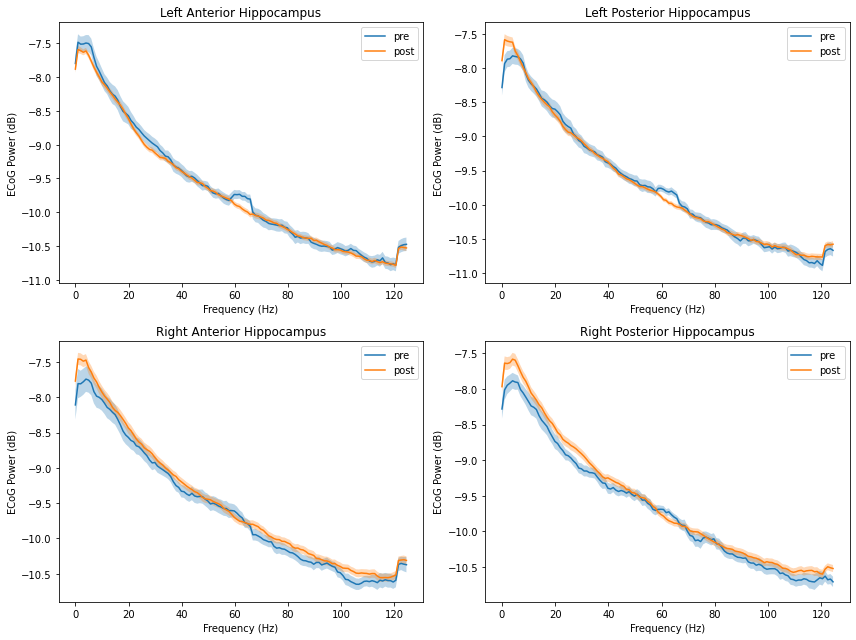

In [12]:
from mne.time_frequency import psd_multitaper
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 9)

hip_chans_formal = ['Left Anterior Hippocampus', 'Left Posterior Hippocampus', 'Right Anterior Hippocampus', 'Right Posterior Hippocampus']
for i in range(4):
    epochs_combined = mne.concatenate_epochs(pre_epochs_master[i])
    psds, freqs = psd_multitaper(epochs_combined)
    pre_mean = np.mean(np.log10(psds), axis=0)[0]
    pre_std = np.std(np.log10(psds), axis=0)[0] / np.sqrt(psds.shape[0])
    axs[i//2, i%2].plot(freqs, pre_mean, label='pre')
    axs[i//2, i%2].fill_between(freqs, pre_mean - pre_std, pre_mean + pre_std, alpha=0.3)

    epochs_combined = mne.concatenate_epochs(post_epochs_master[i])
    psds, freqs = psd_multitaper(epochs_combined)
    post_mean = np.mean(np.log10(psds), axis=0)[0]
    post_std = np.std(np.log10(psds), axis=0)[0] / np.sqrt(psds.shape[0])
    axs[i//2, i%2].plot(freqs, post_mean, label='post')
    axs[i//2, i%2].fill_between(freqs, post_mean - post_std, post_mean + post_std, alpha=0.3)
    
    axs[i//2, i%2].set_xlabel('Frequency (Hz)')
    axs[i//2, i%2].set_ylabel('ECoG Power (dB)')
    axs[i//2, i%2].set_title(hip_chans_formal[i])
    axs[i//2, i%2].legend()
fig.tight_layout()

one for each patient now

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


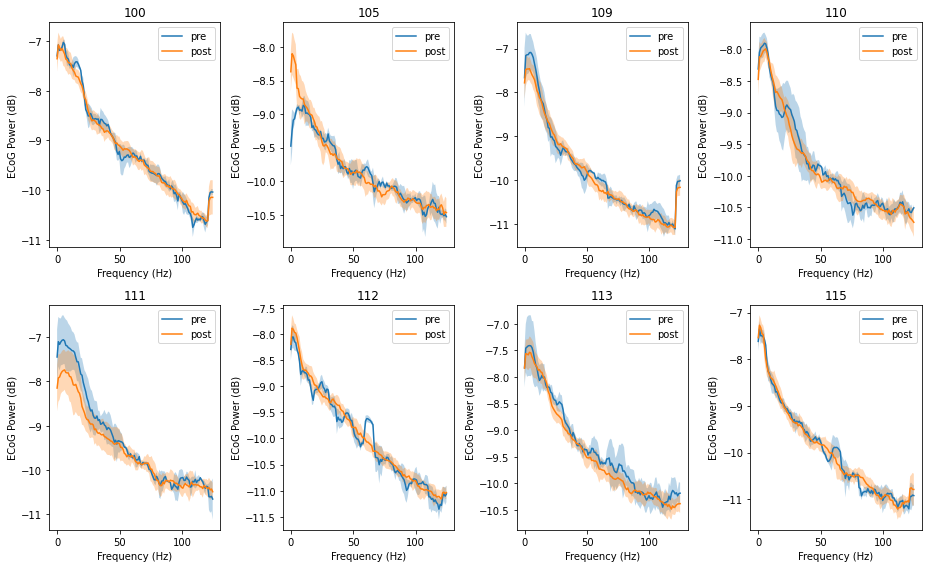

In [71]:
mne.set_log_level('WARNING')
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
pre_epochs_master = [[], [], [], []]
fig, axs = plt.subplots(2,4)
fig.set_size_inches(13, 8)

for i, pt_num in enumerate(pt_nums):
    if pt_num == 114:
        continue
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    
    epochs = mne.Epochs(raw, evts, event_id=1, picks=np.intersect1d(hip_chans, raw.info['ch_names']), tmin=0, tmax=1, baseline=(0.5,1.0))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()

    psds, freqs = psd_multitaper(epochs)
    pre_mean = np.mean(np.log10(psds), axis=0)[0]
    pre_std = np.std(np.log10(psds), axis=0)[0]
    axs[i//4, i%4].plot(freqs, pre_mean, label='pre')
    axs[i//4, i%4].fill_between(freqs, pre_mean - pre_std, pre_mean + pre_std, alpha=0.3)

    epochs = mne.Epochs(raw, evts, event_id=2, picks=np.intersect1d(hip_chans, raw.info['ch_names']), tmin=0, tmax=1, baseline=(0.5,1.0))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()

    psds, freqs = psd_multitaper(epochs)
    pre_mean = np.mean(np.log10(psds), axis=0)[0]
    pre_std = np.std(np.log10(psds), axis=0)[0]
    axs[i//4, i%4].plot(freqs, pre_mean, label='post')
    axs[i//4, i%4].fill_between(freqs, pre_mean - pre_std, pre_mean + pre_std, alpha=0.3)

    axs[i//4, i%4].legend()
    axs[i//4, i%4].set_xlabel('Frequency (Hz)')
    axs[i//4, i%4].set_ylabel('ECoG Power (dB)')
    axs[i//4, i%4].set_title(pt_num)
fig.tight_layout()

In [ ]:
import scipy.stats

all_hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
locs_master = np.array([])

pvals = []
tvals = []
bands = [(0.1, 3), (4,7), (8,12), (13,30), (40, 60), (60, 80), (80, 100), (100, 120)]
band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']
fig, xs = plt.subplots
for i, chan in enumerate(all_hip_chans):
    curr_p = {'Channel': chan}
    curr_t = {'Channel': chan}
    for j, (lo, hi) in enumerate(bands):
        pre_psds, pre_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(pre_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
        pre_psds = np.log10(pre_psds) - np.log10(1e-12)

        post_psds, post_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(post_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
        post_psds = np.log10(post_psds) - np.log10(1e-12)

        result = scipy.stats.ttest_ind(post_psds.flatten(), pre_psds.flatten())
        curr_p[band_labels[j]] = result.pvalue
        curr_t[band_labels[j]] = result.statistic
    pvals.append(curr_p)
    tvals.append(curr_t)

In [ ]:
ttest_pvals = pd.DataFrame(pvals).set_index('Channel')
ttest_tvals = pd.DataFrame(tvals).set_index('Channel')
ttest_pvals

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.097236  0.007451  0.385467  0.038690  0.653511  0.017783   
LHip3 - LHip4  0.002580  0.802044  0.848724  0.197442  0.085401  0.001922   
RHip1 - RHip2  0.064324  0.134283  0.207099  0.004538  0.268493  0.001106   
RHip3 - RHip4  0.000031  0.000405  0.032690  0.000007  0.001139  0.586272   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.346838    0.249328  
LHip3 - LHip4   0.611525    0.133700  
RHip1 - RHip2   0.001203    0.000077  
RHip3 - RHip4   0.022368    0.000340

In [ ]:
ttest_tvals

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2 -1.663746 -2.694789 -0.868843 -2.069111 -0.448958 -2.372100   
LHip3 - LHip4  3.040057  0.250931  0.190873 -1.289390 -1.721041 -3.106311   
RHip1 - RHip2  1.858243  1.502355  1.264063  2.842673  1.106911  3.267825   
RHip3 - RHip4  4.263250  3.597003  2.146919  4.513790  3.260806  0.544377   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.940967   -1.152326  
LHip3 - LHip4   0.507980    1.500291  
RHip1 - RHip2   3.243787    3.963292  
RHip3 - RHip4   2.286671    3.591929

In [ ]:
from stats_pipeline import fdr_bh
new_tp = fdr_bh(ttest_pvals)
ttest_tvals[new_tp < 0.05]

Delta     Theta  Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                  
LHip1 - LHip2       NaN -2.694789    NaN       NaN       NaN -2.372100   
LHip3 - LHip4  3.040057       NaN    NaN       NaN       NaN -3.106311   
RHip1 - RHip2       NaN       NaN    NaN  2.842673       NaN  3.267825   
RHip3 - RHip4  4.263250  3.597003    NaN  4.513790  3.260806       NaN   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2        NaN         NaN  
LHip3 - LHip4        NaN         NaN  
RHip1 - RHip2   3.243787    3.963292  
RHip3 - RHip4        NaN    3.591929

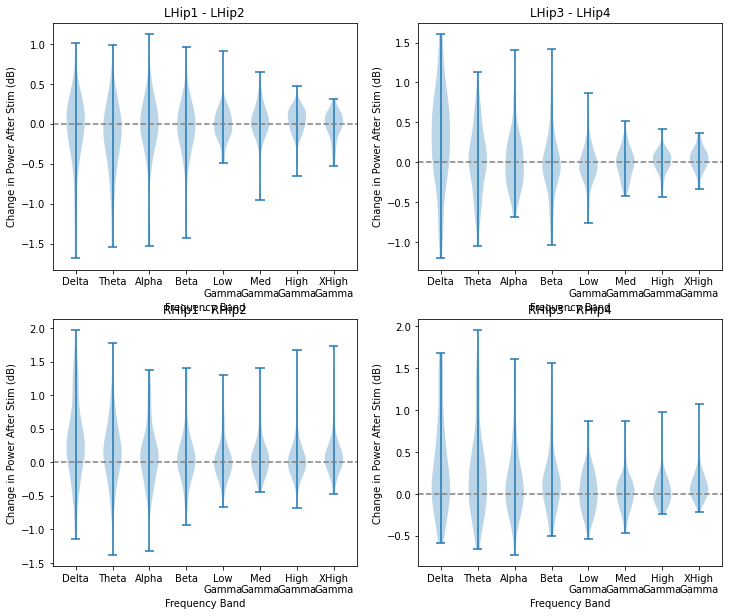

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
freq_labels = list(map(lambda freq: freq[len('Gamma'):]+'\nGamma' if freq.startswith('Gamma') else freq, freqs))
for i, chan in enumerate(hip_chans):
    ax = axs[i // 2, i % 2]
    power_for_chan = power_log_chg[power_log_chg['Channel'] == chan]
    ax.violinplot([power_for_chan[freq + '_log_chg'] for freq in freqs])
    ax.set_xticks(range(1,9), freq_labels)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Change in Power After Stim (dB)')
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title(chan)

## 1b) Can you predict the CHANGE in power using PRE-stim power?

Let's apply the same approach as last time.

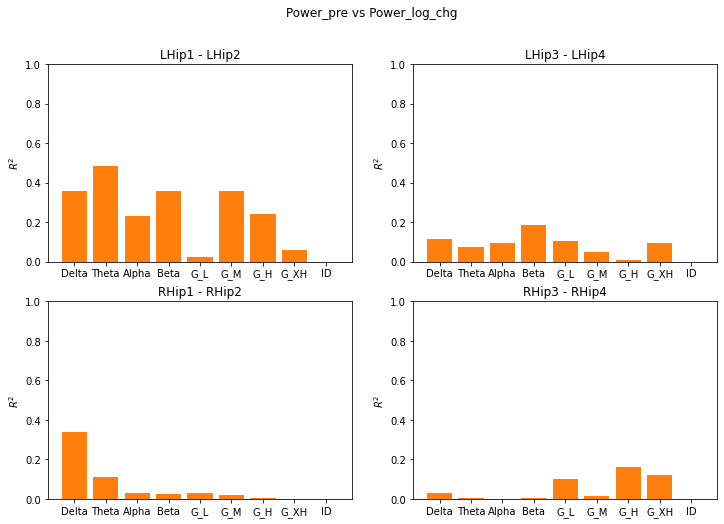

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_log_chg', xlog=True)

The bar graphs show much smaller R^2 values. It seems like the PRE-stim power has more of an effect on POST-stim power than it does on the CHANGE in power. To me, this indicates that the excitability in response to stimulation is not quite the same as the tissue's "natural" activity level, except maybe in the left anterior hippocampus. I wonder if this is the region that's stimulated first/last.

Whenever I see differences between the channels/contacts/brain regions in response to stimulation, I keep running into the question of whether these differences are due to the stimulation parameters vs active usage of certain circuits causing a differential response. The problem is that each patient has different stim parameters, so I'm not sure how we could elucidate the role of the stim parameters. Maybe separate it out by patient or something. The good news is that this shouldn't affect memory correlations, because I'm pretty sure that if a difference in power between brain regions correlates with memory, that's probably because that brain region is involved in memory.

Anyway, because the $R^2$ values are pretty small this time, and left anterior hippocampus is the only one that shows sizable correlations, I will separate out my t-tests by brain contact this time.

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan[freq+'_log_chg'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: t = {results.slope / results.stderr} P = {results.pvalue}")
        else:
            print(f"{chan} {freq}: Not significant")
    print("")

LHip1 - LHip2 Delta: t = -6.137420520383326 P = 4.883542304677614e-08
LHip1 - LHip2 Theta: t = -7.971363002643398 P = 2.4701381103859106e-11
LHip1 - LHip2 Alpha: t = -4.525435568531127 P = 2.4880023094992907e-05
LHip1 - LHip2 Beta: t = -6.182304461708118 P = 4.071739711162382e-08
LHip1 - LHip2 GammaLow: Not significant
LHip1 - LHip2 GammaMed: t = -6.179364147843279 P = 4.120562049916765e-08
LHip1 - LHip2 GammaHigh: t = -4.650776133486427 P = 1.5739483618407554e-05
LHip1 - LHip2 GammaXHigh: t = -2.0261385131424645 P = 0.04667591786829241

LHip3 - LHip4 Delta: t = -2.980808274117621 P = 0.003985837451075974
LHip3 - LHip4 Theta: t = -2.352569041703599 P = 0.021545183760228785
LHip3 - LHip4 Alpha: t = -2.692814463912313 P = 0.008913685844089952
LHip3 - LHip4 Beta: t = -3.947133763718718 P = 0.0001900424967993592
LHip3 - LHip4 GammaLow: t = -2.78141798484996 P = 0.006996814587367072
LHip3 - LHip4 GammaMed: Not significant
LHip3 - LHip4 GammaHigh: Not significant
LHip3 - LHip4 GammaXHigh: t 

A lot of them still have pretty strong P-values, especially in the left anterior hippocampus, but it's clear that the relationship is not as strong given the $R^2$ data and the slightly higher (but still very small) P-values. My overall conclusion is that YES, PRE-stim power does predict CHANGE in power, but mostly in the left anterior hippocampus and less so in other areas.

## 2a) Does PRE-stim ECoG power predict memory scores?

Oh boy. Here we go. The memory correlations. The most important part of our work, and also the most complicated. Where to begin.

I have tried many different models, with results that sometimes concur and sometimes differ. I started out by calculating individual correlations between memory scores and ECoG power, and I identified a few relationships. After that, I wanted to isolate the within-subject variation and between-subject variation, so I tried running a multiple regression with dummy vectors for the categorical variable of subject. Based on the overlap between the $R^2$ values, this work suggested that the differences between subjects were more important than the differences within subjects. This is illustrated in the graph below. Finally, I figured out how to implement mixed-effects models that allowed me to treat the subject as a random effect and the various ECoG powers as fixed effects, and these new models showed results that I'm still not sure how to interpret. Let's walk through the results in more detail.

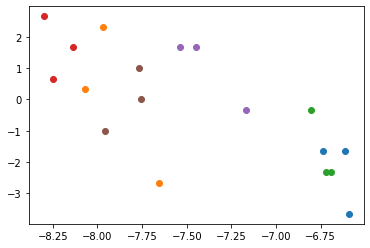

In [ ]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

fig, ax = plt.subplots()
power_for_chan = df_averaged[df_averaged['Channel'] == 'LHip3 - LHip4']
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['Delta_post']), power_for_pt['Memory_Score'] - power_for_pt['Avg_Sham'])

My first work was running simple linear regression between the PRE-stim power on the x side, and raw memory scores, stim-sham memory scores, and three-word memory scores on the y side. For this writeup, I've organized it so that we look at all of the raw memory first, then the stim-sham, then three-word groups.

### Raw Memory Scores

We'll start with the raw memory scores. In order to do this, we need to average out the stims for each trial, since each trial has one memory score but 4 stims.

In [ ]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

Now, let's see what happens when we do one linear regression at a time.

In [ ]:
from scipy.stats import linregress

t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
for i, chan in enumerate(hip_chans):
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for j, freq in enumerate(freqs):
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'])
        t_arr[i][j] = results.slope / results.stderr
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537


[Text(0.5, 1.0, 'PRE-stim ECoG Power vs Short-Term Trial Memory')]

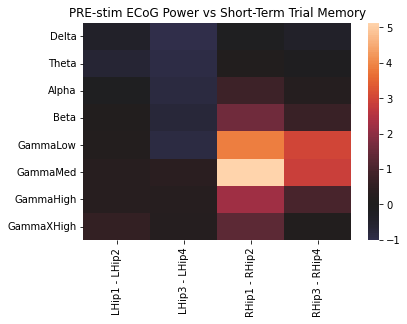

In [ ]:
from seaborn import heatmap

heatmap(t_arr.T, xticklabels=hip_chans, yticklabels=freqs, center=0) \
    .set(title='PRE-stim ECoG Power vs Short-Term Trial Memory')

Interesting, we have several significant correlations, all with pretty high R and pretty low P. To confirm, I'm going to try running our strongest correlation, the one for the GammaMed band in RHip1 - RHip2, using a different library (i.e. `statsmodels` instead of `scipy`).

In [ ]:
from scipy.stats import linregress

chan = 'RHip1 - RHip2'
freq = 'GammaMed'
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
model = smf.ols("Memory_Score ~ np.log10(" + freq +"_pre)", power_for_chan)
results = model.fit()
t_test = results.t_test([0, 1], use_t=True)
print(f"{chan} {freq}: |r| = {np.sqrt(results.rsquared)}, p = {t_test.pvalue}")

RHip1 - RHip2 GammaMed: |r| = 0.7886304209812275, p = 0.00010069993500367922


Great! The results are almost exactly the same, which means that I can use both libraries interchangeably, and also indicated that I'm using them correctly.

Next, let's see what happens when we do multiple linear regression with all of the frequencies in a channel simultaneously. I couldn't find a way to do this with `scipy`, but `statsmodels` has an `OLS` that works great.

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                 -0.236
Method:                 Least Squares   F-statistic:                    0.5945
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.762
Time:                        17:47:20   Log-Likelihood:                -33.416
No. Observations:                  18   AIC:                             84.83
Df Residuals:                       9   BIC:                             92.85
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   12.2729     29.049      0.422      0.683     -53.440      77.986
np.log10(Delta_pre)          7.4706      4.680      1.596      0.145      -3.115      18.057
np.log10(Theta_pre)        -12.5640      6.348     -1.979      0.079     -26.924       1.796
np.log10(Alpha_pre)          5.4515      4.280      1.274      0.235      -4.230      15.133
np.log10(Beta_pre)           1.8227      3.590      0.508      0.624      -6.298       9.943
np.log10(GammaLow_pre)      -6.1907      5.688     -1.088      0.305     -19.058       6.676
np.log10(GammaMed_pre)      -0.3301      4.030     -0.082      0.937      -9.448       8.787
np.log10(GammaHigh_pre)      2.3797      5.868      0.406      0.695     -10.896      15.655
np.log10(GammaXHigh_pre)     2.1729      4.352      0.499      0.630      -7.671      12.017
==============================================================================
Omnibus:                        3.693   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.329
Skew:                           0.881   Prob(JB):                        0.312
Kurtosis:                       3.051   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.123
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.430
Time:                        17:47:21   Log-Likelihood:                -31.005
No. Observations:                  18   AIC:                             80.01
Df Residuals:                       9   BIC:                             88.02
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   24.2116     20.976      1.154      0.278     -23.238      71.662
np.log10(Delta_pre)          4.4078      4.273      1.032      0.329      -5.258      14.074
np.log10(Theta_pre)         -4.6801      4.856     -0.964      0.360     -15.664       6.304
np.log10(Alpha_pre)         -4.2429      3.636     -1.167      0.273     -12.468       3.982
np.log10(Beta_pre)           2.2320      3.176      0.703      0.500      -4.952       9.416
np.log10(GammaLow_pre)      -6.7231      3.369     -1.995      0.077     -14.345       0.899
np.log10(GammaMed_pre)      14.7089      6.201      2.372      0.042       0.681      28.737
np.log10(GammaHigh_pre)     -1.4951      5.034     -0.297      0.773     -12.882       9.892
np.log10(GammaXHigh_pre)    -3.2147      3.988     -0.806      0.441     -12.237       5.808
==============================================================================
Omnibus:                        1.330   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.141
Skew:                           0.535   Prob(JB):                        0.565
Kurtosis:                       2.386   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4.104
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0250
Time:                        17:47:21   Log-Likelihood:                -22.624
No. Observations:                  18   AIC:                             63.25
Df Residuals:                       9   BIC:                             71.26
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   36.9945     14.883      2.486      0.035       3.327      70.662
np.log10(Delta_pre)         -1.1830      1.726     -0.685      0.510      -5.089       2.723
np.log10(Theta_pre)          0.9642      2.197      0.439      0.671      -4.007       5.935
np.log10(Alpha_pre)          0.2116      3.110      0.068      0.947      -6.825       7.248
np.log10(Beta_pre)          -1.2014      4.029     -0.298      0.772     -10.316       7.913
np.log10(GammaLow_pre)       2.1587      2.063      1.046      0.323      -2.509       6.826
np.log10(GammaMed_pre)       5.4761      2.928      1.870      0.094      -1.147      12.099
np.log10(GammaHigh_pre)     -2.2573      4.014     -0.562      0.588     -11.339       6.824
np.log10(GammaXHigh_pre)    -1.1068      3.356     -0.330      0.749      -8.699       6.486
==============================================================================
Omnibus:                        0.419   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.311
Skew:                          -0.281   Prob(JB):                        0.856
Kurtosis:                       2.685   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     5.896
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0221
Time:                        17:47:21   Log-Likelihood:                -13.604
No. Observations:                  15   AIC:                             45.21
Df Residuals:                       6   BIC:                             51.58
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   16.5256     19.595      0.843      0.431     -31.422      64.473
np.log10(Delta_pre)          0.8118      2.185      0.372      0.723      -4.535       6.159
np.log10(Theta_pre)         -3.5333      4.027     -0.877      0.414     -13.388       6.321
np.log10(Alpha_pre)          1.3098      2.936      0.446      0.671      -5.874       8.494
np.log10(Beta_pre)           0.9369      3.256      0.288      0.783      -7.029       8.903
np.log10(GammaLow_pre)      -0.1743      2.556     -0.068      0.948      -6.429       6.081
np.log10(GammaMed_pre)       9.3204      3.195      2.917      0.027       1.502      17.139
np.log10(GammaHigh_pre)     -4.0808      3.717     -1.098      0.314     -13.176       5.014
np.log10(GammaXHigh_pre)    -3.5074      2.238     -1.567      0.168      -8.983       1.968
==============================================================================
Omnibus:                        1.855   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.316
Skew:                           0.690   Prob(JB):                        0.518
Kurtosis:                       2.553   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is very interesting. First off, if you zoom in on GammaMed for RHip1 - RHip2, then you'll see that the P-value is pretty different from what we saw in the univariate regressions (0.094 vs 0.0001). This isn't because we're using a different library, but rather because we're using a different statistical model, specifically *multiple* regression and not univariate linear regression. I'm not sure what the difference is in interpretation, so I'll have to consult with John on that, but my first guess would be that it has to do with the multicollinearity.

Speaking of which, you'll notice that the bottom of each table has a big disclaimer that "the condition number is large..\[which\] might indicate that there are strong multicollinearity." This makes sense, since brains with high power in one frequency band probably have globally high power, which is the underlying variable that explains the others. I don't know enough stats to understand why multicollinearity is a problem, so I'll have to ask John about that, too. My interpretation is that these frequency bands must have information that is not collinear with the other frequencies, but I have no idea if that is the correct way to interpret the results

Finally, notice that the overall $R^2$ and F-test for the multiple regression are significant for the right hippocampus, posterior > anterior. This is interesting because it's the opposite laterality from what we've seen for most of the POST-stim power and CHANGE in power correlations. We'll see if that's still the case later.

Next, we move onto mixed effects analyses. This is similar to the multiple linear regression that we just ran, but it accounts for differences between patients. Each group of 3 trials from the same patient is treated as a random effect, and as far as I understand, it looks for fixed effects that occur within each group.

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 2.1530      
Min. group size:      3          Log-Likelihood:        -17.6978    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                16.058   29.363  0.547 0.584 -41.492 73.609
np.log10(Delta_pre)       5.323    3.657  1.455 0.146  -1.846 12.491
np.log10(Theta_pre)      -8.223    5.149 -1.597 0.110 -18.315  1.869
np.log10(Alpha_pre)       3.196    3.552  0.900 0.368  -3.766 10.157
np.log10(Beta_pre)        2.749    2.515  1.093 0.274  -2.179  7.678
np.log10(GammaLow_pre)   -5.659    4.235 -1.336 0.181 -13.959  2.641
np.log10(GammaMed_pre)   -2.106    2.800 -0.752 0.452  -7.594  3.382
np.log10(GammaHigh_pre)   3.882    5.102  0.761 0.447  -6.119 13.882
np.log10(GammaXHigh_pre)  1.647    4.607  0.358 0.721  -7.382 10.676
Group Var                 3.759    3.127                            
====================================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 2.4264      
Min. group size:      3          Log-Likelihood:        -17.3716    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                27.598   29.687  0.930 0.353 -30.587 85.782
np.log10(Delta_pre)       4.763    3.588  1.327 0.184  -2.269 11.796
np.log10(Theta_pre)      -5.107    4.370 -1.169 0.243 -13.671  3.457
np.log10(Alpha_pre)      -1.476    3.931 -0.375 0.707  -9.181  6.229
np.log10(Beta_pre)        1.244    3.086  0.403 0.687  -4.804  7.292
np.log10(GammaLow_pre)   -5.381    3.540 -1.520 0.128 -12.320  1.557
np.log10(GammaMed_pre)   11.279    6.198  1.820 0.069  -0.868 23.426
np.log10(GammaHigh_pre)  -2.470    4.258 -0.580 0.562 -10.816  5.876
np.log10(GammaXHigh_pre) -1.163    4.134 -0.281 0.778  -9.265  6.940
Group Var                 2.362    2.693                            
====================================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 1.1373      
Min. group size:      3          Log-Likelihood:        -14.2876    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                41.149   18.481  2.227 0.026   4.928 77.371
np.log10(Delta_pre)      -1.236    1.581 -0.782 0.434  -4.335  1.863
np.log10(Theta_pre)       0.840    1.977  0.425 0.671  -3.034  4.715
np.log10(Alpha_pre)       0.747    2.962  0.252 0.801  -5.058  6.551
np.log10(Beta_pre)       -2.001    3.831 -0.522 0.602  -9.509  5.508
np.log10(GammaLow_pre)    3.077    2.485  1.238 0.216  -1.793  7.948
np.log10(GammaMed_pre)    5.900    2.868  2.057 0.040   0.278 11.522
np.log10(GammaHigh_pre)  -3.903    4.336 -0.900 0.368 -12.401  4.595
np.log10(GammaXHigh_pre)  0.033    3.589  0.009 0.993  -7.001  7.066
Group Var                 0.628    1.442                            
====================================================================

"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     15         Method:                REML        
No. Groups:           5          Scale:                 0.8977      
Min. group size:      3          Log-Likelihood:        -5.5831     
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                16.530   17.330  0.954 0.340 -17.437 50.497
np.log10(Delta_pre)       0.811    1.819  0.446 0.656  -2.754  4.377
np.log10(Theta_pre)      -3.532    3.169 -1.115 0.265  -9.743  2.679
np.log10(Alpha_pre)       1.309    2.268  0.577 0.564  -3.136  5.754
np.log10(Beta_pre)        0.938    2.666  0.352 0.725  -4.287  6.163
np.log10(GammaLow_pre)   -0.174    1.908 -0.091 0.928  -3.914  3.567
np.log10(GammaMed_pre)    9.319    1.996  4.668 0.000   5.406 13.232
np.log10(GammaHigh_pre)  -4.081    3.496 -1.167 0.243 -10.934  2.771
np.log10(GammaXHigh_pre) -3.507    1.188 -2.951 0.003  -5.836 -1.177
Group Var                 0.000                                     
====================================================================

"""

Before correcting for multiple comparisons, the significant results here are that GammaMed in Right Anterior and GammaMed in Right Posterior are both positively correlated with memory scores. Both of these relationships were also seen in the simple linear regressions,and the Right Posterior also showed up in the multiple regression. Overall convergent results suggesting that seeing high levels of these Gamma frequencies in the PRE-stim ECoG are indicative or higher RAW memory scores.

Overall, if we just take everything at P < 0.05 and ignore multiple comparisons, our results are that RAW memory scores can be explained by differences in PRE-stim power in:
* RHip1 - RHip2 GammaLow
* RHip1 - RHip2 GammaMed (*best*)
* RHip1 - RHip2 GammaHigh
* RHip3 - RHip4 GammaLow
* RHip3 - RHip4 GammaMed

But if you look at the multiple regression, only the GammaMed in LHip3 - LHip4 and RHip3 - RHip4 have coefficients that are significantly different from zero.

Looking at all frequencies together, the Right hippocampus seems to be most correlated with raw memory.

Separating out the effects by each patient, GammaMed power in RHip1 - RHip2 and RHip3 - RHip4 is positively correlated with raw memory.

### Change in Memory

We're pretty much going to do the exact same statistical analyses as we did for PRE-stim power and RAW memory, but now with CHANGE in memory, i.e. single regression, multiple regression, and mixed effects. Keep in mind that the rationale for looking at CHANGE in memory is that it represents "how much the subject improved with stimulation," and we are assuming improvement based on the previous paper.

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'] - power_for_chan['Avg_Sham'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

LHip3 - LHip4 GammaLow: r = -0.4882467616323758, p = 0.039805947761584526
RHip1 - RHip2 GammaLow: r = 0.5033182144036782, p = 0.03322936454360611
RHip1 - RHip2 GammaMed: r = 0.5614792712367382, p = 0.01532188861693486
RHip3 - RHip4 GammaLow: r = 0.569075224112467, p = 0.02682662069630029


After running the simple regressions, we can see a few interesting correlations, again in the gamma range. I'm beginning to think that Delta is the most responsive to stimulation and Gamma is the most related to memory. Anyway, comparing to the correlations for RAW memory, which I've pasted in the next cell, we can see that the CHANGE-in-memory correlations are decent but in terms of both r and p, nowhere near as strong as the relationship with RAW memory. Especially if you look at the GammaLow in RHip1 - RHip2 (r = 0.693, P = 0.001), and the GammaMed in RHip1 - RHip2 (r = 0.789, P=0.0001)

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537


Still, it's interesting that of the 4 channel-frequency bins that are correlated with CHANGE in memory, three of them were also correlated with RAW memory. LHip3 - LHip4 is the only new one, and it's also interesting that it's the only negative one.

Moving onto multiple regression:

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

power_mem_trial['Change_in_Memory'] = power_mem_trial['Memory_Score'] - power_mem_trial['Avg_Sham']
for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                 -0.224
Method:                 Least Squares   F-statistic:                    0.6116
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.750
Time:                        17:47:23   Log-Likelihood:                -32.436
No. Observations:                  18   AIC:                             82.87
Df Residuals:                       9   BIC:                             90.89
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.4327     27.509     -0.016      0.988     -62.663      61.797
np.log10(Delta_pre)          7.8738      4.432      1.777      0.109      -2.151      17.899
np.log10(Theta_pre)        -10.6569      6.011     -1.773      0.110     -24.256       2.942
np.log10(Alpha_pre)          3.4827      4.053      0.859      0.412      -5.685      12.651
np.log10(Beta_pre)           1.6731      3.399      0.492      0.634      -6.017       9.363
np.log10(GammaLow_pre)      -4.1646      5.387     -0.773      0.459     -16.350       8.021
np.log10(GammaMed_pre)      -0.8144      3.817     -0.213      0.836      -9.449       7.820
np.log10(GammaHigh_pre)     -0.5382      5.557     -0.097      0.925     -13.110      12.033
np.log10(GammaXHigh_pre)     3.0852      4.121      0.749      0.473      -6.237      12.408
==============================================================================
Omnibus:                        2.469   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.502
Skew:                           0.707   Prob(JB):                        0.472
Kurtosis:                       2.937   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1.324
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.341
Time:                        17:47:23   Log-Likelihood:                -29.342
No. Observations:                  18   AIC:                             76.68
Df Residuals:                       9   BIC:                             84.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.5673     19.125     -0.448      0.665     -51.830      34.695
np.log10(Delta_pre)          4.4045      3.896      1.131      0.287      -4.409      13.217
np.log10(Theta_pre)         -5.2142      4.427     -1.178      0.269     -15.229       4.801
np.log10(Alpha_pre)         -3.3975      3.315     -1.025      0.332     -10.897       4.102
np.log10(Beta_pre)           2.9386      2.896      1.015      0.337      -3.612       9.489
np.log10(GammaLow_pre)      -7.0202      3.072     -2.285      0.048     -13.969      -0.071
np.log10(GammaMed_pre)      11.2710      5.654      1.993      0.077      -1.519      24.061
np.log10(GammaHigh_pre)     -2.9970      4.589     -0.653      0.530     -13.379       7.385
np.log10(GammaXHigh_pre)    -1.4632      3.636     -0.402      0.697      -9.689       6.763
==============================================================================
Omnibus:                        2.344   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                1.074
Skew:                           0.055   Prob(JB):                        0.584
Kurtosis:                       1.808   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2.646
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0844
Time:                        17:47:23   Log-Likelihood:                -22.790
No. Observations:                  18   AIC:                             63.58
Df Residuals:                       9   BIC:                             71.59
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.1464     15.021      0.675      0.516     -23.833      44.126
np.log10(Delta_pre)         -0.6889      1.742     -0.395      0.702      -4.631       3.253
np.log10(Theta_pre)         -0.0005      2.218     -0.000      1.000      -5.017       5.016
np.log10(Alpha_pre)          0.7226      3.139      0.230      0.823      -6.379       7.824
np.log10(Beta_pre)          -1.0007      4.066     -0.246      0.811     -10.200       8.198
np.log10(GammaLow_pre)       2.2293      2.082      1.071      0.312      -2.481       6.940
np.log10(GammaMed_pre)       5.0465      2.955      1.708      0.122      -1.638      11.731
np.log10(GammaHigh_pre)     -5.3071      4.052     -1.310      0.223     -14.473       3.858
np.log10(GammaXHigh_pre)     0.1047      3.387      0.031      0.976      -7.558       7.768
==============================================================================
Omnibus:                        1.513   Durbin-Watson:                   2.646
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.149
Skew:                          -0.584   Prob(JB):                        0.563
Kurtosis:                       2.587   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     6.107
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0203
Time:                        17:47:23   Log-Likelihood:                -10.306
No. Observations:                  15   AIC:                             38.61
Df Residuals:                       6   BIC:                             44.99
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -9.9578     15.728     -0.633      0.550     -48.444      28.528
np.log10(Delta_pre)         -0.5477      1.754     -0.312      0.765      -4.839       3.744
np.log10(Theta_pre)         -0.7060      3.233     -0.218      0.834      -8.616       7.204
np.log10(Alpha_pre)         -1.2271      2.357     -0.521      0.621      -6.993       4.539
np.log10(Beta_pre)           3.4868      2.613      1.334      0.231      -2.907       9.881
np.log10(GammaLow_pre)       0.2268      2.052      0.111      0.916      -4.794       5.248
np.log10(GammaMed_pre)       7.0115      2.565      2.734      0.034       0.736      13.287
np.log10(GammaHigh_pre)     -7.4595      2.984     -2.500      0.047     -14.760      -0.159
np.log10(GammaXHigh_pre)    -1.4765      1.796     -0.822      0.442      -5.872       2.919
==============================================================================
Omnibus:                        1.691   Durbin-Watson:                   2.656
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.147
Skew:                           0.650   Prob(JB):                        0.564
Kurtosis:                       2.619   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

At significance level of a = 0.05, our significant correlations are:
* GammaLow in LHip3 - LHip4: P = 0.048, negative direction
* GammaMed in RHip3 - RHip4: P = 0.034, positive direction
* GammaHigh in RHip3 - RHip4: P = 0.047, negative direction

When we were looking at RAW memory scores, the significant correlations were GammaMed in RHip3 - RHip4 and LHip3 - LHip4, and both were positive. The first relationship shows up here as well, but not the second.

As before, taking all frequencies together and comparing channels, Right Hipocampus is the strongest predictor of memory, posterior > anterior.

Finally, let's look at the mixed effects models:

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                2.2847          
Min. group size:    3         Log-Likelihood:       -17.7265        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -3.109   28.856 -0.108 0.914 -59.665 53.448
np.log10(Delta_pre)       5.819    3.810  1.527 0.127  -1.648 13.287
np.log10(Theta_pre)      -7.870    5.210 -1.511 0.131 -18.080  2.341
np.log10(Alpha_pre)       2.887    3.598  0.802 0.422  -4.166  9.939
np.log10(Beta_pre)        2.460    2.580  0.954 0.340  -2.597  7.518
np.log10(GammaLow_pre)   -5.372    4.343 -1.237 0.216 -13.885  3.141
np.log10(GammaMed_pre)   -2.273    2.884 -0.788 0.430  -7.925  3.379
np.log10(GammaHigh_pre)   2.074    5.206  0.398 0.690  -8.130 12.278
np.log10(GammaXHigh_pre)  2.030    4.570  0.444 0.657  -6.927 10.986
Group Var                 3.245    2.959                            
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.008522
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid v

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                3.0503          
Min. group size:    3         Log-Likelihood:       -16.9250        
Max. group size:    3         Converged:            No              
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -8.564   14.910 -0.574 0.566 -37.786 20.658
np.log10(Delta_pre)       4.405    3.759  1.172 0.241  -2.962 11.771
np.log10(Theta_pre)      -5.214    4.373 -1.193 0.233 -13.784  3.356
np.log10(Alpha_pre)      -3.396                                     
np.log10(Beta_pre)        2.938    1.044  2.815 0.005   0.892  4.984
np.log10(GammaLow_pre)   -7.019                                     
np.log10(GammaMed_pre)   11.269                                     
np.log10(GammaHigh_pre)  -2.998    4.128 -0.726 0.468 -11.088  5.093
np.log10(GammaXHigh_pre) -1.462    2.246 -0.651 0.515  -5.865  2.940
Group Var                 0.001                                     
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                1.4732          
Min. group size:    3         Log-Likelihood:       -14.5609        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                10.150   11.537  0.880 0.379 -12.461 32.762
np.log10(Delta_pre)      -0.689    1.735 -0.397 0.691  -4.090  2.712
np.log10(Theta_pre)      -0.000    2.212 -0.000 1.000  -4.336  4.335
np.log10(Alpha_pre)       0.723    3.104  0.233 0.816  -5.360  6.806
np.log10(Beta_pre)       -1.001    3.957 -0.253 0.800  -8.757  6.755
np.log10(GammaLow_pre)    2.230    1.506  1.481 0.139  -0.721  5.181
np.log10(GammaMed_pre)    5.046    2.955  1.708 0.088  -0.745 10.838
np.log10(GammaHigh_pre)  -5.308    3.713 -1.430 0.153 -12.585  1.969
np.log10(GammaXHigh_pre)  0.105    2.994  0.035 0.972  -5.762  5.973
Group Var                 0.000                                     
====================================================================

"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   15        Method:               REML            
No. Groups:         5         Scale:                0.5785          
Min. group size:    3         Log-Likelihood:       -4.2641         
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -9.958   15.765 -0.632 0.528 -40.857 20.941
np.log10(Delta_pre)      -0.548    1.850 -0.296 0.767  -4.173  3.078
np.log10(Theta_pre)      -0.706    3.403 -0.207 0.836  -7.376  5.963
np.log10(Alpha_pre)      -1.227    2.822 -0.435 0.664  -6.757  4.303
np.log10(Beta_pre)        3.487    2.640  1.321 0.187  -1.687  8.661
np.log10(GammaLow_pre)    0.227    2.067  0.110 0.913  -3.825  4.279
np.log10(GammaMed_pre)    7.012    2.646  2.650 0.008   1.825 12.198
np.log10(GammaHigh_pre)  -7.459    3.091 -2.413 0.016 -13.518 -1.400
np.log10(GammaXHigh_pre) -1.477    1.890 -0.781 0.435  -5.181  2.228
Group Var                 0.000    0.929                            
====================================================================

"""

First off, it's important to note the warnings about maximum likelihood estimation failing to converge. I think this may undermine some of the results, but then again, it also says that the model converged in the end, so maybe it just had to try a different method.

Next, let's look at the significant findings for the mixed effects model:
* Beta in LHip3 - LHip4, P = 0.005, positive direction
* GammaMed in RHip3 - RHip4, P = 0.008, positive direction
* GammaHigh in RHip3 - RHip4, P = 0.016, negative direction

The brain is a complex thing, so interpreting all of these correlations is challenging, especially when considering that we haven't applied FDR. Still, it's worth noting that the GammaMed and GammaHigh in Rhip3 - RHip4 were also seen in the multiple regression, although the P-values are lower now that we've isolated the fixed effects from the random effects.

Overall, if we just take everything at P < 0.05 and ignore multiple comparisons, our results are that CHANGE in memory scores can be explained by differences in PRE-stim power in:
* LHip3 - LHip4 GammaLow
* RHip1 - RHip2 GammaLow
* RHip1 - RHip2 GammaMed
* RHip3 - RHip4 GammaLow

But if you look at the multiple regression, the significant results are:
* GammaLow in LHip3 - LHip4: P = 0.048, negative direction
* GammaMed in RHip3 - RHip4: P = 0.034, positive direction
* GammaHigh in RHip3 - RHip4: P = 0.047, negative direction

Looking at all frequencies together, the Right hippocampus seems to be most correlated with change in memory, same as it was for raw memory.

Separating out the effects by each patient, we have:
* Beta in LHip3 - LHip4, P = 0.005, positive direction
* GammaMed in RHip3 - RHip4, P = 0.008, positive direction
* GammaHigh in RHip3 - RHip4, P = 0.016, negative direction

Going by P-value alone, the PRE-stim Beta in LHip3 - LHip4 seems to be the best predictor of CHANGE in memory, although this is only visible once you remove differences between patients (random effects).GammaHigh in RHip3- RHip4 seems to play an important role no matter which analysis you look at, although the relationships are not as strong as they were for RAW memory

### Three-word Groups

TODO

In [ ]:
from scipy.stats import linregress

t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
for i, chan in enumerate(hip_chans):
    power_for_chan = power_mem_3[power_mem_3['Channel'] == chan]
    for j, freq in enumerate(freqs):
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Prev_Trio'])
        t_arr[i][j] = results.slope / results.stderr
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = 0.3558450215253952, p = 0.005675165873618701
RHip1 - RHip2 GammaMed: r = 0.29498970250274137, p = 0.023322626621031368


[Text(0.5, 1.0, 'PRE-stim ECoG Power vs Previous 3-Word Memory')]

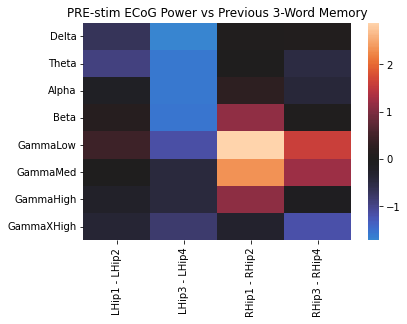

In [ ]:
from seaborn import heatmap

heatmap(t_arr.T, yticklabels=freqs, xticklabels=hip_chans, center=0) \
    .set(title='PRE-stim ECoG Power vs Previous 3-Word Memory')

## 2b) Does the CHANGE in ECoG power predict memory scores?

So that's PRE-stim power, which gives you an idea of the patient's brain activity in the absence of stimulation. However, we're honestly more interested in how that activity CHANGES in response to stimulation, and how that related to memory scores. To answer that question, we'll look at RAW memory, CHANGE in memory, and three-word groups, all while correlating with CHANGE in ECoG power. For each of these relationships, we'll look at simple regression, multiple regression, and mixed effects, as before.

### Raw Memory

In [ ]:
from scipy.stats import linregress

t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
for i, chan in enumerate(hip_chans):
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for j, freq in enumerate(freqs):
        results = linregress(power_for_chan[freq+'_log_chg'], power_for_chan['Memory_Score'])
        t_arr[i][j] = results.slope / results.stderr
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip3 - RHip4 GammaMed: r = -0.5628382081997695, p = 0.028931863752304884


[Text(0.5, 1.0, 'CHANGE in ECoG Power vs Short-Term Trial Memory')]

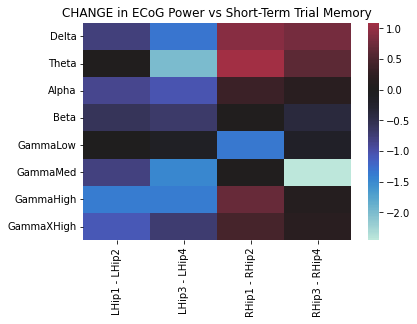

In [ ]:
from seaborn import heatmap

heatmap(t_arr.T, xticklabels=hip_chans, yticklabels=freqs, center=0) \
    .set(title='CHANGE in ECoG Power vs Short-Term Trial Memory')

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += freq + "_log_chg + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                 -0.074
Method:                 Least Squares   F-statistic:                    0.8538
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.583
Time:                        17:47:26   Log-Likelihood:                -32.152
No. Observations:                  18   AIC:                             82.30
Df Residuals:                       9   BIC:                             90.32
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5329      0.685     10.997      0.000       5.983       9.082
Delta_log_chg         -6.2628      4.021     -1.558      0.154     -15.359       2.833
Theta_log_chg          8.5751      3.901      2.198      0.055      -0.249      17.399
Alpha_log_chg         -1.7067      4.669     -0.366      0.723     -12.269       8.856
Beta_log_chg          -2.1505      4.020     -0.535      0.606     -11.244       6.943
GammaLow_log_chg       3.9249      4.579      0.857      0.414      -6.433      14.283
GammaMed_log_chg       0.5744      3.106      0.185      0.857      -6.451       7.600
GammaHigh_log_chg     -4.6835      5.412     -0.865      0.409     -16.926       7.559
GammaXHigh_log_chg    -1.1826      7.203     -0.164      0.873     -17.476      15.111
==============================================================================
Omnibus:                        0.031   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.985   Jarque-Bera (JB):                0.222
Skew:                           0.071   Prob(JB):                        0.895
Kurtosis:                       2.474   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                 -0.181
Method:                 Least Squares   F-statistic:                    0.6749
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.705
Time:                        17:47:26   Log-Likelihood:                -33.005
No. Observations:                  18   AIC:                             84.01
Df Residuals:                       9   BIC:                             92.02
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.0485      0.886      7.952      0.000       5.043       9.054
Delta_log_chg         -0.1619      2.036     -0.080      0.938      -4.767       4.443
Theta_log_chg         -1.8395      3.162     -0.582      0.575      -8.993       5.314
Alpha_log_chg         -0.9891      4.023     -0.246      0.811     -10.090       8.112
Beta_log_chg           2.3930      3.721      0.643      0.536      -6.025      10.811
GammaLow_log_chg       2.7720      4.140      0.670      0.520      -6.592      12.136
GammaMed_log_chg      -7.6727      5.470     -1.403      0.194     -20.047       4.701
GammaHigh_log_chg     -1.5796      6.682     -0.236      0.818     -16.696      13.537
GammaXHigh_log_chg    -2.1585      6.313     -0.342      0.740     -16.440      12.123
==============================================================================
Omnibus:                        0.692   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.124
Skew:                          -0.200   Prob(JB):                        0.940
Kurtosis:                       3.065   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1.484
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.284
Time:                        17:47:26   Log-Likelihood:                -28.880
No. Observations:                  18   AIC:                             75.76
Df Residuals:                       9   BIC:                             83.77
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.8892      0.547     12.585      0.000       5.651       8.127
Delta_log_chg         -1.1601      1.538     -0.754      0.470      -4.639       2.319
Theta_log_chg          3.3292      2.562      1.299      0.226      -2.467       9.126
Alpha_log_chg          2.1284      4.616      0.461      0.656      -8.313      12.570
Beta_log_chg          -4.4059      5.186     -0.850      0.418     -16.137       7.326
GammaLow_log_chg      -5.4724      2.506     -2.184      0.057     -11.141       0.196
GammaMed_log_chg       1.2793      2.781      0.460      0.656      -5.011       7.570
GammaHigh_log_chg     10.5663      4.645      2.275      0.049       0.058      21.075
GammaXHigh_log_chg    -7.3018      4.349     -1.679      0.127     -17.139       2.536
==============================================================================
Omnibus:                        0.035   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.090
Skew:                           0.000   Prob(JB):                        0.956
Kurtosis:                       2.654   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     2.573
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.133
Time:                        17:47:26   Log-Likelihood:                -18.801
No. Observations:                  15   AIC:                             55.60
Df Residuals:                       6   BIC:                             61.97
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.2117      0.603     11.960      0.000       5.736       8.687
Delta_log_chg         -2.7707      2.154     -1.286      0.246      -8.041       2.500
Theta_log_chg          4.4006      2.828      1.556      0.171      -2.519      11.320
Alpha_log_chg         -3.3749      2.650     -1.273      0.250      -9.860       3.110
Beta_log_chg          -1.1074      2.610     -0.424      0.686      -7.493       5.278
GammaLow_log_chg       1.6029      2.693      0.595      0.573      -4.986       8.192
GammaMed_log_chg     -13.4982      3.637     -3.711      0.010     -22.399      -4.598
GammaHigh_log_chg     12.9577      6.976      1.858      0.113      -4.111      30.027
GammaXHigh_log_chg    -1.2797      5.562     -0.230      0.826     -14.890      12.330
==============================================================================
Omnibus:                        0.685   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.660
Skew:                           0.232   Prob(JB):                        0.719
Kurtosis:                       2.083   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Filtering down to only those that are P < 0.05, we have:
* RHip1 - RHip2 GammaHigh, P = 0.049, positive direction
* RHip3 - RHip4 GammaMed, P = 0.010, negative direction

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += freq + "_log_chg + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               2.5017      
Min. group size:    3        Log-Likelihood:      -16.0120    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           7.402    0.863  8.574 0.000   5.710  9.094
Delta_log_chg      -5.970    3.947 -1.512 0.130 -13.707  1.766
Theta_log_chg       7.292    4.271  1.707 0.088  -1.079 15.663
Alpha_log_chg      -1.863    4.224 -0.441 0.659 -10.142  6.415
Beta_log_chg       -3.071    3.513 -0.874 0.382  -9.956  3.814
GammaLow_log_chg    2.542    3.871  0.657 0.511  -5.045 10.128
GammaMed_log_chg    2.581    3.070  0.841 0.400  -3.436  8.597
GammaHigh_log_chg  -4.997    5.637 -0.886 0.375 -16.046  6.052
GammaXHigh_log_chg  0.335    6.764  0.050 0.960 -12.923 13.593
Group Var           1.887    1.707                            
==============================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               2.3415      
Min. group size:    3        Log-Likelihood:      -16.9887    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           7.542    1.149  6.561 0.000   5.289  9.795
Delta_log_chg      -1.803    2.743 -0.657 0.511  -7.179  3.573
Theta_log_chg       0.845    3.907  0.216 0.829  -6.812  8.502
Alpha_log_chg      -2.406    3.752 -0.641 0.521  -9.759  4.947
Beta_log_chg        2.332    2.891  0.807 0.420  -3.334  7.999
GammaLow_log_chg    2.646    3.306  0.800 0.424  -3.835  9.126
GammaMed_log_chg   -5.892    5.029 -1.172 0.241 -15.749  3.965
GammaHigh_log_chg   1.280    5.621  0.228 0.820  -9.737 12.297
GammaXHigh_log_chg -3.413    6.261 -0.545 0.586 -15.685  8.859
Group Var           2.678    2.539                            
==============================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               1.1432      
Min. group size:    3        Log-Likelihood:      -15.8439    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           6.957    0.705  9.862 0.000   5.574  8.340
Delta_log_chg      -0.139    1.826 -0.076 0.939  -3.719  3.441
Theta_log_chg       1.496    2.405  0.622 0.534  -3.217  6.209
Alpha_log_chg       1.002    3.107  0.323 0.747  -5.087  7.092
Beta_log_chg       -1.562    4.111 -0.380 0.704  -9.620  6.496
GammaLow_log_chg   -5.684    1.966 -2.892 0.004  -9.537 -1.832
GammaMed_log_chg   -1.534    2.569 -0.597 0.550  -6.568  3.500
GammaHigh_log_chg   9.616    4.100  2.345 0.019   1.581 17.652
GammaXHigh_log_chg -6.028    3.275 -1.840 0.066 -12.447  0.391
Group Var           1.937    2.232                            
==============================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   15       Method:              REML        
No. Groups:         5        Scale:               0.9272      
Min. group size:    3        Log-Likelihood:      -7.1554     
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           6.986    0.716  9.751 0.000   5.582  8.390
Delta_log_chg      -0.561    2.898 -0.194 0.847  -6.240  5.118
Theta_log_chg       1.462    4.197  0.348 0.728  -6.764  9.689
Alpha_log_chg      -0.922    3.559 -0.259 0.796  -7.897  6.053
Beta_log_chg       -2.288    2.212 -1.034 0.301  -6.624  2.048
GammaLow_log_chg   -0.495    3.698 -0.134 0.894  -7.742  6.752
GammaMed_log_chg   -8.088    7.018 -1.152 0.249 -21.843  5.667
GammaHigh_log_chg   9.938    6.448  1.541 0.123  -2.699 22.576
GammaXHigh_log_chg -0.920    4.183 -0.220 0.826  -9.118  7.278
Group Var           1.216    3.388                            
==============================================================

"""

Keeping only P < 0.05:
* RHip1 - RHip2 GammaLow, P = 0.004
* RHip1 - RHip2 GammaHigh, P = 0.019

### Change in Memory

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(power_for_chan[freq+'_log_chg'], power_for_chan['Memory_Score'] - power_for_chan['Avg_Sham'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = -0.47325430888691117, p = 0.04729264028187781
RHip3 - RHip4 GammaMed: r = -0.6880062282431453, p = 0.004578923396548213


In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += freq + "_log_chg + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                 -0.419
Method:                 Least Squares   F-statistic:                    0.3729
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.910
Time:                        17:47:27   Log-Likelihood:                -33.767
No. Observations:                  18   AIC:                             85.53
Df Residuals:                       9   BIC:                             93.55
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0091      0.749     -0.012      0.991      -1.704       1.686
Delta_log_chg         -2.9558      4.398     -0.672      0.518     -12.906       6.994
Theta_log_chg          4.1582      4.267      0.975      0.355      -5.494      13.810
Alpha_log_chg         -0.8282      5.107     -0.162      0.875     -12.382      10.726
Beta_log_chg          -1.0624      4.397     -0.242      0.814     -11.010       8.885
GammaLow_log_chg       4.1998      5.008      0.839      0.423      -7.130      15.530
GammaMed_log_chg      -0.2928      3.397     -0.086      0.933      -7.977       7.392
GammaHigh_log_chg      1.2146      5.920      0.205      0.842     -12.176      14.606
GammaXHigh_log_chg    -6.1381      7.879     -0.779      0.456     -23.961      11.685
==============================================================================
Omnibus:                        0.746   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.758
Skew:                          -0.359   Prob(JB):                        0.685
Kurtosis:                       2.297   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1.432
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.301
Time:                        17:47:27   Log-Likelihood:                -28.953
No. Observations:                  18   AIC:                             75.91
Df Residuals:                       9   BIC:                             83.92
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3253      0.708      0.460      0.657      -1.276       1.926
Delta_log_chg         -0.2364      1.625     -0.145      0.888      -3.913       3.440
Theta_log_chg          0.2446      2.525      0.097      0.925      -5.467       5.956
Alpha_log_chg         -1.8711      3.212     -0.583      0.575      -9.138       5.395
Beta_log_chg           2.0840      2.971      0.701      0.501      -4.637       8.805
GammaLow_log_chg       4.7219      3.305      1.429      0.187      -2.755      12.199
GammaMed_log_chg      -8.8348      4.367     -2.023      0.074     -18.714       1.045
GammaHigh_log_chg     -3.3330      5.335     -0.625      0.548     -15.402       8.736
GammaXHigh_log_chg    -8.8401      5.041     -1.754      0.113     -20.243       2.563
==============================================================================
Omnibus:                        0.563   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.589
Skew:                           0.073   Prob(JB):                        0.745
Kurtosis:                       2.126   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     3.621
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0362
Time:                        17:47:27   Log-Likelihood:                -20.721
No. Observations:                  18   AIC:                             59.44
Df Residuals:                       9   BIC:                             67.45
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4381      0.348      1.259      0.240      -0.349       1.225
Delta_log_chg         -1.4219      0.978     -1.455      0.180      -3.633       0.789
Theta_log_chg          2.9204      1.628      1.793      0.107      -0.763       6.604
Alpha_log_chg          1.6892      2.933      0.576      0.579      -4.947       8.325
Beta_log_chg          -3.7986      3.296     -1.153      0.279     -11.254       3.657
GammaLow_log_chg      -5.1150      1.592     -3.212      0.011      -8.717      -1.513
GammaMed_log_chg      -1.8608      1.767     -1.053      0.320      -5.859       2.137
GammaHigh_log_chg     10.5915      2.952      3.588      0.006       3.913      17.270
GammaXHigh_log_chg    -5.7226      2.764     -2.071      0.068     -11.975       0.529
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.500
Skew:                           0.470   Prob(JB):                        0.472
Kurtosis:                       1.943   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     2.481
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.142
Time:                        17:47:27   Log-Likelihood:                -15.950
No. Observations:                  15   AIC:                             49.90
Df Residuals:                       6   BIC:                             56.27
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5601      0.499      1.123      0.304      -0.660       1.780
Delta_log_chg         -1.7740      1.781     -0.996      0.358      -6.133       2.585
Theta_log_chg          2.8163      2.338      1.204      0.274      -2.906       8.538
Alpha_log_chg         -1.2304      2.192     -0.561      0.595      -6.593       4.132
Beta_log_chg          -2.6942      2.158     -1.249      0.258      -7.974       2.586
GammaLow_log_chg      -0.3583      2.227     -0.161      0.877      -5.807       5.090
GammaMed_log_chg      -9.0589      3.008     -3.012      0.024     -16.419      -1.699
GammaHigh_log_chg      9.4001      5.769      1.630      0.154      -4.715      23.515
GammaXHigh_log_chg    -1.2753      4.599     -0.277      0.791     -12.530       9.979
==============================================================================
Omnibus:                        2.346   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                1.677
Skew:                          -0.785   Prob(JB):                        0.432
Kurtosis:                       2.532   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* RHip1 - RHip2 GammaLow, P = 0.011, negative direction
* RHip3 - RHip4 GammaMed, P = 0.024, negative direction

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += freq + "_log_chg + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.5986          
Min. group size:  3       Log-Likelihood:     -16.6196        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.044    0.972  0.046 0.964  -1.861  1.949
Delta_log_chg      -3.841    4.243 -0.905 0.365 -12.157  4.474
Theta_log_chg       4.071    4.532  0.898 0.369  -4.813 12.954
Alpha_log_chg      -1.958    4.444 -0.441 0.660 -10.667  6.752
Beta_log_chg       -2.093    3.670 -0.570 0.568  -9.285  5.099
GammaLow_log_chg    2.485    3.963  0.627 0.531  -5.283 10.252
GammaMed_log_chg    2.416    3.219  0.750 0.453  -3.893  8.725
GammaHigh_log_chg  -0.857    6.224 -0.138 0.890 -13.056 11.342
GammaXHigh_log_chg -2.396    7.331 -0.327 0.744 -16.766 11.973
Group Var           2.757    2.256                            
==============================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.4275          
Min. group size:  3       Log-Likelihood:     -15.7614        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.482    0.894  0.539 0.590  -1.270  2.234
Delta_log_chg      -0.852    2.428 -0.351 0.726  -5.611  3.908
Theta_log_chg       0.885    3.144  0.281 0.778  -5.278  7.048
Alpha_log_chg      -2.163    3.377 -0.640 0.522  -8.782  4.456
Beta_log_chg        2.064    2.800  0.737 0.461  -3.424  7.552
GammaLow_log_chg    4.326    3.322  1.302 0.193  -2.184 10.837
GammaMed_log_chg   -7.940    4.743 -1.674 0.094 -17.236  1.357
GammaHigh_log_chg  -1.941    5.991 -0.324 0.746 -13.683  9.801
GammaXHigh_log_chg -8.176    5.661 -1.444 0.149 -19.271  2.919
Group Var           0.654    1.269                            
==============================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              1.1054          
Min. group size:  3       Log-Likelihood:     -13.1776        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.435    0.367  1.185 0.236  -0.284  1.153
Delta_log_chg      -1.337    1.140 -1.172 0.241  -3.572  0.898
Theta_log_chg       2.782    1.812  1.535 0.125  -0.770  6.335
Alpha_log_chg       1.610    2.900  0.555 0.579  -4.074  7.293
Beta_log_chg       -3.559    3.519 -1.011 0.312 -10.456  3.339
GammaLow_log_chg   -5.186    1.637 -3.169 0.002  -8.393 -1.978
GammaMed_log_chg   -1.985    1.904 -1.042 0.297  -5.717  1.748
GammaHigh_log_chg  10.568    2.982  3.544 0.000   4.724 16.412
GammaXHigh_log_chg -5.701    2.745 -2.077 0.038 -11.081 -0.321
Group Var           0.084    0.496                            
==============================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 15      Method:             REML            
No. Groups:       5       Scale:              0.6937          
Min. group size:  3       Log-Likelihood:     -5.9120         
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.390    0.572  0.681 0.496  -0.732  1.512
Delta_log_chg      -0.475    2.112 -0.225 0.822  -4.613  3.664
Theta_log_chg       0.961    3.023  0.318 0.751  -4.964  6.885
Alpha_log_chg      -0.175    2.318 -0.076 0.940  -4.718  4.368
Beta_log_chg       -2.536    1.746 -1.452 0.146  -5.959  0.886
GammaLow_log_chg   -1.520    2.442 -0.623 0.534  -6.306  3.265
GammaMed_log_chg   -6.618    4.146 -1.596 0.110 -14.744  1.508
GammaHigh_log_chg   8.722    4.823  1.809 0.071  -0.730 18.175
GammaXHigh_log_chg -1.454    3.583 -0.406 0.685  -8.476  5.568
Group Var           0.638    1.744                            
==============================================================

"""

* RHip1 - RHip2 GammaLow, P = 0.002, negative direction
* RHip1 - RHip2 GammaHigh, P = 0.0004, positive direction

## 2c) Does the POST-stim ECoG power predict memory scores?

### Raw Memory

In [ ]:
from scipy.stats import linregress

t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
for i, chan in enumerate(hip_chans):
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for j, freq in enumerate(freqs):
        results = linregress(np.log10(power_for_chan[freq+'_post']), power_for_chan['Memory_Score'])
        t_arr[i][j] = results.slope / results.stderr
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

LHip3 - LHip4 Delta: r = -0.48131860083754907, p = 0.04314368915195751
LHip3 - LHip4 Theta: r = -0.5263739038153527, p = 0.024828144035354254
RHip1 - RHip2 GammaMed: r = 0.5348268877420973, p = 0.022202996645914023


[Text(0.5, 1.0, 'POST-stim ECoG Power vs Short-Term Trial Memory')]

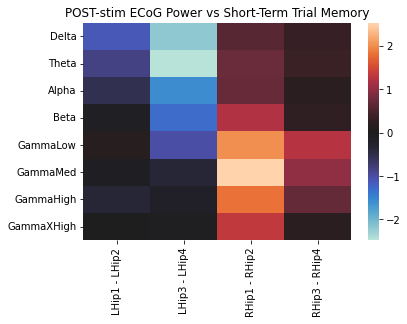

In [ ]:
from seaborn import heatmap

heatmap(t_arr.T, xticklabels=hip_chans, yticklabels=freqs, center=0) \
    .set(title='POST-stim ECoG Power vs Short-Term Trial Memory')

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_post) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     1.586
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.253
Time:                        17:47:28   Log-Likelihood:                -29.319
No. Observations:                  18   AIC:                             76.64
Df Residuals:                       9   BIC:                             84.65
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -5.1118     33.938     -0.151      0.884     -81.885      71.661
np.log10(Delta_post)         -4.2489      3.703     -1.148      0.281     -12.625       4.127
np.log10(Theta_post)          8.9210      8.436      1.057      0.318     -10.163      28.005
np.log10(Alpha_post)        -14.9325     10.190     -1.465      0.177     -37.984       8.119
np.log10(Beta_post)          15.8520     11.764      1.348      0.211     -10.759      42.464
np.log10(GammaLow_post)       2.3294      8.440      0.276      0.789     -16.763      21.422
np.log10(GammaMed_post)       8.5277     10.390      0.821      0.433     -14.976      32.032
np.log10(GammaHigh_post)    -25.6345     11.793     -2.174      0.058     -52.313       1.044
np.log10(GammaXHigh_post)     8.7371      6.671      1.310      0.223      -6.353      23.828
==============================================================================
Omnibus:                        2.179   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.282
Skew:                          -0.653   Prob(JB):                        0.527
Kurtosis:                       2.941   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     3.514
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0394
Time:                        17:47:28   Log-Likelihood:                -24.483
No. Observations:                  18   AIC:                             66.97
Df Residuals:                       9   BIC:                             74.98
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    36.7501     21.512      1.708      0.122     -11.914      85.414
np.log10(Delta_post)         -4.9847      2.115     -2.357      0.043      -9.769      -0.200
np.log10(Theta_post)         -0.7167      2.648     -0.271      0.793      -6.708       5.274
np.log10(Alpha_post)         -3.6523      4.248     -0.860      0.412     -13.263       5.958
np.log10(Beta_post)           5.9583      4.302      1.385      0.199      -3.775      15.691
np.log10(GammaLow_post)      -2.8525      4.815     -0.592      0.568     -13.744       8.039
np.log10(GammaMed_post)       2.7802      6.186      0.449      0.664     -11.214      16.774
np.log10(GammaHigh_post)     10.2930      8.501      1.211      0.257      -8.938      29.524
np.log10(GammaXHigh_post)    -5.3772      5.698     -0.944      0.370     -18.268       7.514
==============================================================================
Omnibus:                        0.947   Durbin-Watson:                   2.411
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.875
Skew:                          -0.444   Prob(JB):                        0.646
Kurtosis:                       2.385   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1.237
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.376
Time:                        17:47:29   Log-Likelihood:                -29.775
No. Observations:                  18   AIC:                             77.55
Df Residuals:                       9   BIC:                             85.56
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.7254     15.370      0.698      0.503     -24.044      45.495
np.log10(Delta_post)         -1.6579      3.498     -0.474      0.647      -9.572       6.256
np.log10(Theta_post)          2.7021      6.899      0.392      0.704     -12.904      18.308
np.log10(Alpha_post)         -4.5041      6.048     -0.745      0.475     -18.187       9.178
np.log10(Beta_post)           5.9364      5.635      1.053      0.320      -6.812      18.685
np.log10(GammaLow_post)      -9.1371      7.277     -1.256      0.241     -25.598       7.324
np.log10(GammaMed_post)       9.1209      5.412      1.685      0.126      -3.121      21.363
np.log10(GammaHigh_post)      1.5824      5.126      0.309      0.765     -10.014      13.179
np.log10(GammaXHigh_post)    -3.7724      4.649     -0.811      0.438     -14.289       6.744
==============================================================================
Omnibus:                        0.266   Durbin-Watson:                   2.450
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.443
Skew:                          -0.085   Prob(JB):                        0.801
Kurtosis:                       2.250   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


RHip3 - RHip4:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.9726
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.529
Time:                        17:47:29   Log-Likelihood:                -23.730
No. Observations:                  15   AIC:                             65.46
Df Residuals:                       6   BIC:                             71.83
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    61.3396     39.300      1.561      0.170     -34.824     157.503
np.log10(Delta_post)          4.3762      7.279      0.601      0.570     -13.435      22.187
np.log10(Theta_post)         -7.3025     10.036     -0.728      0.494     -31.859      17.254
np.log10(Alpha_post)          6.4767      7.037      0.920      0.393     -10.743      23.696
np.log10(Beta_post)          -8.1824      6.142     -1.332      0.231     -23.212       6.848
np.log10(GammaLow_post)       0.9947      3.972      0.250      0.811      -8.724      10.713
np.log10(GammaMed_post)      16.7053     13.277      1.258      0.255     -15.783      49.193
np.log10(GammaHigh_post)     -4.6840     12.196     -0.384      0.714     -34.527      25.159
np.log10(GammaXHigh_post)    -3.1346      7.360     -0.426      0.685     -21.144      14.874
==============================================================================
Omnibus:                        1.235   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                0.830
Skew:                           0.206   Prob(JB):                        0.660
Kurtosis:                       1.924   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In all of these regressions, only Delta band in LHip3 - LHip4 produces a significant P-value (0.043). The F-test for the LHip3 - LHip4 is also fairly convicning, for what it's worth

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_post) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     Memory_Score
No. Observations:     18          Method:                 REML        
No. Groups:           6           Scale:                  2.5621      
Min. group size:      3           Log-Likelihood:         -12.7613    
Max. group size:      3           Converged:              Yes         
Mean group size:      3.0                                             
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   3.789   46.546  0.081 0.935 -87.439 95.018
np.log10(Delta_post)       -1.819    5.773 -0.315 0.753 -13.134  9.496
np.log10(Theta_post)        5.801    9.420  0.616 0.538 -12.662 24.265
np.log10(Alpha_post)      -11.580   11.537 -1.004 0.316 -34.192 11.032
np.log10(Beta_post)        13.405   11.786  1.137 0.255  -9.695 36.505
np.log10(GammaLow_post)     0.183    8.904  0.021 0.984 -17.268 17.634
np.log10(GammaMed_post)     8.047    9.759  0.825 0.410 -11.080 27.174
np.log10(GammaHigh_post)  -22.083   13.032 -1.694 0.090 -47.625  3.460
np.log10(GammaXHigh_post)   8.473    8.724  0.971 0.331  -8.626 25.572
Group Var                   1.977    3.297                            
======================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.175927
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 1.7538      
Min. group size:       3          Log-Likelihood:        -12.6006    
Max. group size:       3          Converged:             No          
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 34.717                                     
np.log10(Delta_post)      -4.902    1.474 -3.326 0.001  -7.791 -2.013
np.log10(Theta_post)      -0.927                                     
np.log10(Alpha_post)      -3.571    3.970 -0.900 0.368 -11.351  4.210
np.log10(Beta_post)        6.160    1.725  3.571 0.000   2.779  9.541
np.log10(GammaLow_post)   -2.765    4.469 -0.619 0.536 -11.524  5.994
np.log10(GammaMed_post)    2.160                                     
np.log10(GammaHigh_post)  10.467    7.853  1.333 0.183  -4.924 25.858
np.log10(GammaXHigh_post) -5.357    5.770 -0.928 0.353 -16.667  5.953
Group Var                  0.204                                     
=====================================================================

"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 3.2014      
Min. group size:       3          Log-Likelihood:        -16.8006    
Max. group size:       3          Converged:             Yes         
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 10.725   16.677  0.643 0.520 -21.961 43.411
np.log10(Delta_post)      -1.658    3.516 -0.472 0.637  -8.548  5.233
np.log10(Theta_post)       2.702    7.226  0.374 0.708 -11.460 16.864
np.log10(Alpha_post)      -4.504    6.057 -0.744 0.457 -16.375  7.366
np.log10(Beta_post)        5.936    6.475  0.917 0.359  -6.753 18.626
np.log10(GammaLow_post)   -9.137    7.399 -1.235 0.217 -23.640  5.365
np.log10(GammaMed_post)    9.121    7.067  1.291 0.197  -4.730 22.972
np.log10(GammaHigh_post)   1.582    5.128  0.309 0.758  -8.468 11.633
np.log10(GammaXHigh_post) -3.772    4.788 -0.788 0.431 -13.156  5.612
Group Var                  0.000    1.835                            
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM     Dependent Variable:     Memory_Score
No. Observations:      15          Method:                 REML        
No. Groups:            5           Scale:                  1.2679      
Min. group size:       3           Log-Likelihood:         -7.2213     
Max. group size:       3           Converged:              Yes         
Mean group size:       3.0                                             
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 -20.416   56.539 -0.361 0.718 -131.230 90.397
np.log10(Delta_post)        0.370    8.419  0.044 0.965  -16.130 16.870
np.log10(Theta_post)       -2.789   11.297 -0.247 0.805  -24.931 19.353
np.log10(Alpha_post)        6.754    6.113  1.105 0.269   -5.228 18.736
np.log10(Beta_post)        -1.373    4.936 -0.278 0.781  -11.047  8.302
np.log10(GammaLow_post)    -3.943    3.435 -1.148 0.251  -10.675  2.789
np.log10(GammaMed_post)    -0.127   13.974 -0.009 0.993  -27.515 27.261
np.log10(GammaHigh_post)    1.120   12.575  0.089 0.929  -23.528 25.767
np.log10(GammaXHigh_post)  -2.308    7.227 -0.319 0.749  -16.472 11.857
Group Var                  14.027   18.465                             
=======================================================================

"""

* LHip3 - LHip4 Delta, P = 0.001, negative direction
* LHip3 - LHip4 Beta, P = 0.0004, positive direction

### Change in Memory

I don't feel like the change in memory *should* be affected by POST-stim memory, but this was where we found our lowest P-value earlier (Delta and Theta in LHip3 - LHip4), so I guess I'll check it out

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_post']), power_for_chan['Change_in_Memory'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

LHip3 - LHip4 Delta: r = -0.7231783842810279, p = 0.0006952666762677207
LHip3 - LHip4 Theta: r = -0.7065274361802295, p = 0.001046328171984928
LHip3 - LHip4 Alpha: r = -0.5236008087914112, p = 0.02574013981435471
LHip3 - LHip4 Beta: r = -0.5304161945714009, p = 0.023544144273297287
LHip3 - LHip4 GammaLow: r = -0.5464086596767511, p = 0.018965069091061913


The P-value for Delta in left posterior hippocampus is still low, but I think I've actually seen slightly better in some of the other single regressions

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_post) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1.700
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.223
Time:                        17:47:30   Log-Likelihood:                -28.056
No. Observations:                  18   AIC:                             74.11
Df Residuals:                       9   BIC:                             82.13
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.1165     31.639     -0.288      0.780     -80.689      62.456
np.log10(Delta_post)          0.2152      3.452      0.062      0.952      -7.593       8.024
np.log10(Theta_post)          4.9313      7.865      0.627      0.546     -12.860      22.722
np.log10(Alpha_post)        -12.8961      9.500     -1.358      0.208     -34.386       8.594
np.log10(Beta_post)          12.9198     10.967      1.178      0.269     -11.889      37.729
np.log10(GammaLow_post)       2.5031      7.868      0.318      0.758     -15.296      20.302
np.log10(GammaMed_post)       6.5024      9.686      0.671      0.519     -15.410      28.414
np.log10(GammaHigh_post)    -25.4480     10.994     -2.315      0.046     -50.319      -0.577
np.log10(GammaXHigh_post)    11.1442      6.219      1.792      0.107      -2.924      25.212
==============================================================================
Omnibus:                        4.806   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                2.985
Skew:                          -0.988   Prob(JB):                        0.225
Kurtosis:                       3.276   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     3.584
Date:                Wed, 18 May 2022   Prob (F-statistic):             0.0373
Time:                        17:47:30   Log-Likelihood:                -23.458
No. Observations:                  18   AIC:                             64.92
Df Residuals:                       9   BIC:                             72.93
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.5725     20.321     -0.422      0.683     -54.542      37.397
np.log10(Delta_post)         -2.6939      1.998     -1.348      0.210      -7.213       1.826
np.log10(Theta_post)         -2.8198      2.502     -1.127      0.289      -8.479       2.840
np.log10(Alpha_post)         -0.7174      4.013     -0.179      0.862      -9.796       8.361
np.log10(Beta_post)           4.3252      4.064      1.064      0.315      -4.869      13.519
np.log10(GammaLow_post)      -1.8382      4.548     -0.404      0.696     -12.127       8.450
np.log10(GammaMed_post)      -2.0152      5.844     -0.345      0.738     -15.235      11.204
np.log10(GammaHigh_post)      6.9606      8.031      0.867      0.409     -11.206      25.127
np.log10(GammaXHigh_post)    -3.0534      5.383     -0.567      0.584     -15.231       9.124
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   2.681
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.491
Skew:                          -0.079   Prob(JB):                        0.782
Kurtosis:                       2.206   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.7848
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.628
Time:                        17:47:30   Log-Likelihood:                -28.913
No. Observations:                  18   AIC:                             75.83
Df Residuals:                       9   BIC:                             83.84
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -5.9561     14.651     -0.407      0.694     -39.099      27.187
np.log10(Delta_post)          0.1940      3.335      0.058      0.955      -7.349       7.737
np.log10(Theta_post)          1.5742      6.576      0.239      0.816     -13.302      16.450
np.log10(Alpha_post)         -4.4169      5.765     -0.766      0.463     -17.459       8.626
np.log10(Beta_post)           5.6506      5.372      1.052      0.320      -6.501      17.802
np.log10(GammaLow_post)      -8.5428      6.936     -1.232      0.249     -24.233       7.148
np.log10(GammaMed_post)       7.3506      5.158      1.425      0.188      -4.319      19.020
np.log10(GammaHigh_post)      1.9943      4.887      0.408      0.693      -9.060      13.048
np.log10(GammaXHigh_post)    -4.3124      4.431     -0.973      0.356     -14.337       5.712
==============================================================================
Omnibus:                        0.691   Durbin-Watson:                   2.635
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.689
Skew:                          -0.379   Prob(JB):                        0.709
Kurtosis:                       2.412   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.8139
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.617
Time:                        17:47:31   Log-Likelihood:                -21.392
No. Observations:                  15   AIC:                             60.78
Df Residuals:                       6   BIC:                             67.16
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    44.4262     33.630      1.321      0.235     -37.863     126.716
np.log10(Delta_post)          8.0386      6.229      1.291      0.244      -7.203      23.280
np.log10(Theta_post)        -11.3343      8.588     -1.320      0.235     -32.348       9.679
np.log10(Alpha_post)          7.2451      6.022      1.203      0.274      -7.490      21.980
np.log10(Beta_post)          -7.1079      5.256     -1.352      0.225     -19.969       5.754
np.log10(GammaLow_post)       0.0079      3.399      0.002      0.998      -8.309       8.324
np.log10(GammaMed_post)      16.8927     11.362      1.487      0.188     -10.908      44.693
np.log10(GammaHigh_post)     -9.4308     10.436     -0.904      0.401     -34.968      16.106
np.log10(GammaXHigh_post)     0.0761      6.298      0.012      0.991     -15.334      15.487
==============================================================================
Omnibus:                        1.309   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                0.798
Skew:                           0.073   Prob(JB):                        0.671
Kurtosis:                       1.880   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In all of these regressions, only GammaHigh band in LHip1 - LHip2 produces a significant P-value (0.046). The F-test for the LHip3 - LHip4 is also fairly convicning, for what it's worth

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_post) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     Memory_Score
No. Observations:     18          Method:                 REML        
No. Groups:           6           Scale:                  2.5621      
Min. group size:      3           Log-Likelihood:         -12.7613    
Max. group size:      3           Converged:              Yes         
Mean group size:      3.0                                             
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   3.789   46.546  0.081 0.935 -87.439 95.018
np.log10(Delta_post)       -1.819    5.773 -0.315 0.753 -13.134  9.496
np.log10(Theta_post)        5.801    9.420  0.616 0.538 -12.662 24.265
np.log10(Alpha_post)      -11.580   11.537 -1.004 0.316 -34.192 11.032
np.log10(Beta_post)        13.405   11.786  1.137 0.255  -9.695 36.505
np.log10(GammaLow_post)     0.183    8.904  0.021 0.984 -17.268 17.634
np.log10(GammaMed_post)     8.047    9.759  0.825 0.410 -11.080 27.174
np.log10(GammaHigh_post)  -22.083   13.032 -1.694 0.090 -47.625  3.460
np.log10(GammaXHigh_post)   8.473    8.724  0.971 0.331  -8.626 25.572
Group Var                   1.977    3.297                            
======================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.175927
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 1.7538      
Min. group size:       3          Log-Likelihood:        -12.6006    
Max. group size:       3          Converged:             No          
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 34.717                                     
np.log10(Delta_post)      -4.902    1.474 -3.326 0.001  -7.791 -2.013
np.log10(Theta_post)      -0.927                                     
np.log10(Alpha_post)      -3.571    3.970 -0.900 0.368 -11.351  4.210
np.log10(Beta_post)        6.160    1.725  3.571 0.000   2.779  9.541
np.log10(GammaLow_post)   -2.765    4.469 -0.619 0.536 -11.524  5.994
np.log10(GammaMed_post)    2.160                                     
np.log10(GammaHigh_post)  10.467    7.853  1.333 0.183  -4.924 25.858
np.log10(GammaXHigh_post) -5.357    5.770 -0.928 0.353 -16.667  5.953
Group Var                  0.204                                     
=====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 3.2014      
Min. group size:       3          Log-Likelihood:        -16.8006    
Max. group size:       3          Converged:             Yes         
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 10.725   16.677  0.643 0.520 -21.961 43.411
np.log10(Delta_post)      -1.658    3.516 -0.472 0.637  -8.548  5.233
np.log10(Theta_post)       2.702    7.226  0.374 0.708 -11.460 16.864
np.log10(Alpha_post)      -4.504    6.057 -0.744 0.457 -16.375  7.366
np.log10(Beta_post)        5.936    6.475  0.917 0.359  -6.753 18.626
np.log10(GammaLow_post)   -9.137    7.399 -1.235 0.217 -23.640  5.365
np.log10(GammaMed_post)    9.121    7.067  1.291 0.197  -4.730 22.972
np.log10(GammaHigh_post)   1.582    5.128  0.309 0.758  -8.468 11.633
np.log10(GammaXHigh_post) -3.772    4.788 -0.788 0.431 -13.156  5.612
Group Var                  0.000    1.835                            
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM     Dependent Variable:     Memory_Score
No. Observations:      15          Method:                 REML        
No. Groups:            5           Scale:                  1.2679      
Min. group size:       3           Log-Likelihood:         -7.2213     
Max. group size:       3           Converged:              Yes         
Mean group size:       3.0                                             
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 -20.416   56.539 -0.361 0.718 -131.230 90.397
np.log10(Delta_post)        0.370    8.419  0.044 0.965  -16.130 16.870
np.log10(Theta_post)       -2.789   11.297 -0.247 0.805  -24.931 19.353
np.log10(Alpha_post)        6.754    6.113  1.105 0.269   -5.228 18.736
np.log10(Beta_post)        -1.373    4.936 -0.278 0.781  -11.047  8.302
np.log10(GammaLow_post)    -3.943    3.435 -1.148 0.251  -10.675  2.789
np.log10(GammaMed_post)    -0.127   13.974 -0.009 0.993  -27.515 27.261
np.log10(GammaHigh_post)    1.120   12.575  0.089 0.929  -23.528 25.767
np.log10(GammaXHigh_post)  -2.308    7.227 -0.319 0.749  -16.472 11.857
Group Var                  14.027   18.465                             
=======================================================================

"""

Here, we see low P-values for Delta and Beta in LHip3 - LHip4. The Delta relationship is negative and Beta is positive. However, the model failed to converge, so I'm not sure how reliable this is.

# Delay Memory

In [ ]:
# we don't actually have 111 in power_mem_trial
pts_w_control_and_stim = [103, 106, 109, 110, 112, 113, 115]

In [ ]:
import importlib
import my_ecog_utils
importlib.reload(my_ecog_utils)

<module 'my_ecog_utils' from 'c:\\Users\\seand\\eeg_proj\\ecog\\my_ecog_utils.py'>

In [ ]:
from my_ecog_utils import get_raw_power_bands_narrow
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

full_rec = pd.DataFrame(columns=['ID', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])

for pt_num in pts_w_control_and_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    for chan in raw.info['ch_names']:
        full_rec = full_rec.append({'ID': pt_num, 'Channel': chan, **get_raw_power_bands_narrow(raw, picks=chan)}, ignore_index=True)

full_rec

Opening raw data file data/103/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 58391 =      0.000 ...   233.564 secs
Ready.
Reading 0 ... 58391  =      0.000 ...   233.564 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Opening raw data file data/106/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 69359 =      0.000 ...   277.436 secs
Ready.
Opening raw data file data/109/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 45047 =      0.000 ...   180.188 secs
Ready.
Opening raw data

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


ID        Channel         Delta         Theta         Alpha  \
0   103  MIns1 - MIns2  6.868700e-10  3.803500e-11  1.767325e-11   
1   103  MIns3 - MIns4  4.911190e-10  3.102013e-11  7.111776e-12   
2   103  PIns1 - PIns2  5.188758e-10  1.100715e-10  4.227645e-11   
3   103  PIns3 - PIns4  7.534356e-10  1.533130e-10  4.368650e-11   
4   106    LPS1 - LPS2  5.031151e-11  4.705463e-12  3.535430e-12   
5   106    LPS3 - LPS4  5.161220e-11  7.085519e-12  5.002228e-12   
6   106  LPIH4 - LPIH1  6.681404e-11  2.137339e-11  1.364623e-11   
7   106  LPIH4 - LPIH3  5.177696e-11  5.764740e-12  3.426413e-12   
8   109  LHip1 - LHip2  3.023790e-10  2.673130e-10  6.315868e-11   
9   109  LHip3 - LHip4  5.360681e-11  7.643649e-11  1.426762e-11   
10  109  RHip1 - RHip2  6.886993e-10  4.924383e-10  1.852771e-10   
11  109  RHip1 - RHip3  1.604664e-10  1.428598e-10  2.554572e-11   
12  110  LHip1 - LHip2  2.065881e-10  6.623193e-11  5.277941e-11   
13  110  LHip3 - LHip4  5.349168e-10  5.159504e-10  2.339615e-10   
14  110  RHip1 - RHip2  2.180614e-10  1.551642e-10  9.581791e-11   
15  110  RHip3 - RHip4  2.256862e-10  1.373099e-10  8.239162e-11   
16  112  LHip1 - LHip2  6.838634e-11  1.680484e-11  8.012348e-12   
17  112  LHip3 - LHip4  3.707726e-11  1.915593e-11  1.695244e-11   
18  112  RHip1 - RHip2  6.655159e-11  3.391560e-11  1.936075e-11   
19  112  RHip3 - RHip4  1.725029e-10  3.896211e-11  9.276808e-12   
20  113  LHip1 - LHip2  1.762188e-10  1.086844e-10  8.747802e-11   
21  113  LHip3 - LHip4  8.008277e-11  2.615295e-11  1.402440e-11   
22  113  RHip1 - RHip2  7.594636e-10  1.306558e-09  6.595075e-10   
23  113  RHip3 - RHip4  2.045986e-10  3.401901e-10  1.997697e-10   
24  115  LHip1 - LHip2  2.518881e-10  4.043629e-11  1.719736e-11   
25  115  LHip3 - LHip4  6.124814e-11  2.637776e-11  2.456708e-11   
26  115  RHip1 - RHip2  3.499360e-10  6.424304e-11  2.638483e-11   
27  115  RHip3 - RHip4  3.927439e-10  5.307171e-11  2.848000e-11   

            Beta     GammaHigh      GammaLow      GammaMed    GammaXHigh  
0   2.742567e-12  5.348004e-14  2.634048e-13  1.119110e-13  3.695376e-14  
1   1.779454e-12  1.090472e-13  2.793468e-13  1.227229e-13  7.833523e-14  
2   8.997303e-12  1.285347e-13  5.899500e-13  1.969034e-13  9.202914e-14  
3   2.810925e-11  2.272639e-13  3.770328e-12  5.561665e-13  1.169738e-13  
4   3.542184e-12  7.947934e-14  7.569890e-13  1.552731e-13  4.820189e-14  
5   3.560540e-12  1.157741e-13  1.072229e-12  2.197532e-13  5.898573e-14  
6   9.451497e-12  1.511568e-13  1.656489e-12  3.117519e-13  6.520180e-14  
7   3.673421e-12  7.168842e-14  7.004879e-13  1.256273e-13  4.293691e-14  
8   1.263613e-11  9.893230e-14  7.992208e-13  1.905792e-13  5.282536e-14  
9   3.174383e-12  8.539885e-14  5.028256e-13  1.630935e-13  4.593285e-14  
10  3.172370e-11  1.516693e-13  1.694960e-12  3.333328e-13  7.222974e-14  
11  5.433969e-12  8.910411e-14  6.392987e-13  1.838605e-13  4.274997e-14  
12  4.138941e-11  3.792046e-12  1.292537e-11  6.603889e-12  1.699693e-12  
13  1.014959e-10  4.343976e-12  1.581531e-11  7.320032e-12  1.693554e-12  
14  5.392424e-11  4.252770e-12  1.420445e-11  7.169516e-12  1.783551e-12  
15  4.618271e-11  3.958977e-12  1.398628e-11  6.863899e-12  1.816652e-12  
16  4.272537e-12  8.919828e-14  9.132193e-13  2.041593e-13  4.344459e-14  
17  4.024020e-12  8.135455e-14  6.146115e-13  1.594928e-13  3.472494e-14  
18  1.138259e-11  2.537335e-13  3.308877e-12  7.714443e-13  7.526946e-14  
19  5.096492e-12  1.285616e-13  1.499864e-12  3.246226e-13  4.046792e-14  
20  3.428655e-11  3.223119e-13  2.061119e-12  5.535948e-13  2.103835e-13  
21  8.000519e-12  3.082440e-13  1.417125e-12  4.638370e-13  2.193927e-13  
22  1.734830e-10  1.383701e-12  1.212573e-11  2.801378e-12  7.365186e-13  
23  4.755473e-11  5.183634e-13  4.512019e-12  1.077136e-12  2.500077e-13  
24  5.317564e-12  6.551410e-14  6.510905e-13  1.567803e-13  3.451205e-14  
25  4.765919e-12  5.194239e-14  5.652191e-13  1.176517e-13  2.828267e-14  
26  7.4

In [ ]:
power_mem_stim = full_rec.merge(memory_delayed, left_on='ID', right_on='ID').drop('Delay_Mem_Sham', axis=1)

In [ ]:
from my_ecog_utils import get_raw_power_bands_narrow
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

full_rec = pd.DataFrame(columns=['ID', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])

for pt_num in pts_w_control_and_stim:
    raw = read_with_annotations(pt_num, stim='control')
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    for chan in raw.info['ch_names']:
        full_rec = full_rec.append({'ID': pt_num, 'Channel': chan, **get_raw_power_bands_narrow(raw, picks=chan)}, ignore_index=True)

full_rec

Opening raw data file data/103/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 6551 =      0.000 ...    26.204 secs
Ready.
Reading 0 ... 6551  =      0.000 ...    26.204 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Opening raw data file data/106/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   239.996 secs
Ready.


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 35 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)
c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)
c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(saved_ann)


Opening raw data file data/109/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 42191 =      0.000 ...   168.764 secs
Ready.


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


Opening raw data file data/110/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   239.996 secs
Ready.
Opening raw data file data/112/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   239.996 secs
Ready.
Reading 0 ... 59999  =      0.000 ...   239.996 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Opening raw data file data/113/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 56135 =      0.000 ...   224.540 secs
Ready.
Opening raw data file dat

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


ID        Channel         Delta         Theta         Alpha  \
0   103  MIns1 - MIns2  5.334478e-12  6.752510e-12  8.815530e-12   
1   103  MIns3 - MIns4  2.373591e-12  2.870626e-12  4.107471e-12   
2   103  PIns1 - PIns2  1.101493e-10  3.250446e-11  1.813041e-11   
3   103  PIns3 - PIns4  2.664857e-10  1.072548e-10  6.723037e-11   
4   106    lps1 - lps2  1.178104e-12  3.039040e-12  3.230811e-12   
5   106    lps3 - lps4  5.135658e-12  9.261624e-12  8.170417e-12   
6   106  lpih1 - lpih2  2.028119e-11  2.285243e-11  1.706886e-11   
7   106  lpih3 - lpih4  2.183618e-12  4.615648e-12  3.747695e-12   
8   109  LHip1 - LHip2  1.163781e-09  4.494136e-10  9.296959e-11   
9   109  LHip3 - LHip4  1.559060e-10  1.272527e-10  5.660501e-11   
10  109  RHip1 - RHip2  1.023094e-09  5.435562e-10  1.780606e-10   
11  109  RHip1 - RHip3  8.545677e-10  2.512241e-10  3.813286e-11   
12  110  LHip1 - LHip2  3.454369e-10  4.476934e-11  1.674653e-11   
13  110  LHip3 - LHip4  6.743521e-10  6.638007e-11  4.972530e-11   
14  110  RHip1 - RHip2  5.014716e-10  5.151368e-11  2.373189e-11   
15  110  RHip3 - RHip4  5.905212e-10  5.473838e-11  2.764125e-11   
16  112  LHip1 - LHip2  5.610167e-11  1.745307e-11  8.998102e-12   
17  112  LHip3 - LHip4  3.593387e-11  4.842257e-11  6.516466e-11   
18  112  RHip1 - RHip2  1.275375e-10  4.365951e-11  2.239743e-11   
19  112  RHip3 - RHip4  1.441681e-10  3.766367e-11  1.598035e-11   
20  113  LHip1 - LHip2  3.174097e-10  1.373268e-10  1.283738e-10   
21  113  LHip3 - LHip4  1.439530e-10  5.324944e-11  3.280762e-11   
22  113  RHip1 - RHip2  5.506464e-10  6.361449e-10  3.201955e-10   
23  113  RHip3 - RHip4  3.691212e-10  4.525986e-10  2.142311e-10   
24  115  LHip1 - LHip2  3.233073e-10  5.838884e-11  3.319665e-11   
25  115  LHip3 - LHip4  1.439433e-10  3.984263e-11  3.590826e-11   
26  115  RHip1 - RHip2  4.832031e-10  9.525440e-11  5.337443e-11   
27  115  RHip3 - RHip4  4.250821e-10  6.711056e-11  3.955189e-11   

            Beta     GammaHigh      GammaLow      GammaMed    GammaXHigh  
0   1.960570e-12  3.575155e-14  1.419386e-13  6.078509e-14  2.533475e-14  
1   7.845259e-13  3.131989e-14  9.101274e-14  4.700562e-14  1.977040e-14  
2   6.190091e-12  5.461947e-14  4.681040e-13  1.103562e-13  2.541049e-14  
3   3.425342e-11  1.436554e-13  4.291629e-12  4.644104e-13  4.969409e-14  
4   2.774917e-12  6.791714e-14  6.798435e-13  1.365774e-13  4.062810e-14  
5   4.204468e-12  1.016696e-13  1.428524e-12  2.306128e-13  4.870968e-14  
6   8.825665e-12  2.002250e-13  1.565951e-12  4.360325e-13  7.579240e-14  
7   1.977039e-12  7.366327e-14  7.666490e-13  1.413705e-13  4.160311e-14  
8   2.342691e-11  2.006573e-13  1.092079e-12  3.123909e-13  1.310059e-13  
9   1.849510e-11  9.988285e-14  8.876548e-13  1.932423e-13  5.572883e-14  
10  4.083183e-11  2.422876e-13  2.003910e-12  4.902051e-13  1.325381e-13  
11  8.150570e-12  1.712210e-13  8.843450e-13  2.933153e-13  1.088796e-13  
12  7.725113e-12  2.858901e-13  7.746360e-13  3.183238e-13  2.374293e-13  
13  3.037044e-11  3.076677e-13  1.242647e-12  4.164664e-13  2.408697e-13  
14  1.065670e-11  3.347655e-13  1.055038e-12  4.276854e-13  2.629457e-13  
15  8.425628e-12  4.318910e-13  1.560278e-12  5.573806e-13  3.446049e-13  
16  4.912800e-12  1.609331e-13  1.100709e-12  3.345788e-13  6.183811e-14  
17  1.014968e-11  1.324951e-13  7.743472e-13  2.767619e-13  5.171591e-14  
18  1.395754e-11  3.450555e-13  3.439903e-12  9.108656e-13  9.738090e-14  
19  6.376826e-12  1.798299e-13  1.681186e-12  3.925749e-13  5.880120e-14  
20  5.950158e-11  1.078095e-12  6.895764e-12  2.959079e-12  6.061625e-13  
21  2.052132e-11  1.020856e-12  6.171039e-12  2.535990e-12  4.830092e-13  
22  1.025874e-10  1.683056e-12  1.362969e-11  4.165441e-12  7.873822e-13  
23  6.858899e-11  1.320799e-12  1.183084e-11  3.693437e-12  5.914954e-13  
24  1.075742e-11  1.309061e-13  1.239861e-12  2.826898e-13  6.594703e-14  
25  8.383798e-12  9.210219e-14  7.742580e-13  1.694378e-13  6.085406e-14  
26  1.4

In [ ]:
power_mem_sham = full_rec.merge(memory_delayed, left_on='ID', right_on='ID').drop('Delay_Mem_Stim', axis=1)

In [ ]:
power_mem_sham = power_mem_sham.rename({'Delay_Mem_Sham': 'Delay_Mem'}, axis=1)
power_mem_stim = power_mem_stim.rename({'Delay_Mem_Stim': 'Delay_Mem'}, axis=1)

In [ ]:
power_mem_delay = power_mem_sham.merge(power_mem_stim, on=['ID', 'Channel'], suffixes=['_Sham', '_Stim'])
power_mem_delay

ID        Channel    Delta_Sham    Theta_Sham    Alpha_Sham  \
0   103  MIns1 - MIns2  5.334478e-12  6.752510e-12  8.815530e-12   
1   103  MIns3 - MIns4  2.373591e-12  2.870626e-12  4.107471e-12   
2   103  PIns1 - PIns2  1.101493e-10  3.250446e-11  1.813041e-11   
3   103  PIns3 - PIns4  2.664857e-10  1.072548e-10  6.723037e-11   
4   109  LHip1 - LHip2  1.163781e-09  4.494136e-10  9.296959e-11   
5   109  LHip3 - LHip4  1.559060e-10  1.272527e-10  5.660501e-11   
6   109  RHip1 - RHip2  1.023094e-09  5.435562e-10  1.780606e-10   
7   109  RHip1 - RHip3  8.545677e-10  2.512241e-10  3.813286e-11   
8   110  LHip1 - LHip2  3.454369e-10  4.476934e-11  1.674653e-11   
9   110  LHip3 - LHip4  6.743521e-10  6.638007e-11  4.972530e-11   
10  110  RHip1 - RHip2  5.014716e-10  5.151368e-11  2.373189e-11   
11  110  RHip3 - RHip4  5.905212e-10  5.473838e-11  2.764125e-11   
12  112  LHip1 - LHip2  5.610167e-11  1.745307e-11  8.998102e-12   
13  112  LHip3 - LHip4  3.593387e-11  4.842257e-11  6.516466e-11   
14  112  RHip1 - RHip2  1.275375e-10  4.365951e-11  2.239743e-11   
15  112  RHip3 - RHip4  1.441681e-10  3.766367e-11  1.598035e-11   
16  113  LHip1 - LHip2  3.174097e-10  1.373268e-10  1.283738e-10   
17  113  LHip3 - LHip4  1.439530e-10  5.324944e-11  3.280762e-11   
18  113  RHip1 - RHip2  5.506464e-10  6.361449e-10  3.201955e-10   
19  113  RHip3 - RHip4  3.691212e-10  4.525986e-10  2.142311e-10   
20  115  LHip1 - LHip2  3.233073e-10  5.838884e-11  3.319665e-11   
21  115  LHip3 - LHip4  1.439433e-10  3.984263e-11  3.590826e-11   
22  115  RHip1 - RHip2  4.832031e-10  9.525440e-11  5.337443e-11   
23  115  RHip3 - RHip4  4.250821e-10  6.711056e-11  3.955189e-11   

       Beta_Sham  GammaHigh_Sham  GammaLow_Sham  GammaMed_Sham  \
0   1.960570e-12    3.575155e-14   1.419386e-13   6.078509e-14   
1   7.845259e-13    3.131989e-14   9.101274e-14   4.700562e-14   
2   6.190091e-12    5.461947e-14   4.681040e-13   1.103562e-13   
3   3.425342e-11    1.436554e-13   4.291629e-12   4.644104e-13   
4   2.342691e-11    2.006573e-13   1.092079e-12   3.123909e-13   
5   1.849510e-11    9.988285e-14   8.876548e-13   1.932423e-13   
6   4.083183e-11    2.422876e-13   2.003910e-12   4.902051e-13   
7   8.150570e-12    1.712210e-13   8.843450e-13   2.933153e-13   
8   7.725113e-12    2.858901e-13   7.746360e-13   3.183238e-13   
9   3.037044e-11    3.076677e-13   1.242647e-12   4.164664e-13   
10  1.065670e-11    3.347655e-13   1.055038e-12   4.276854e-13   
11  8.425628e-12    4.318910e-13   1.560278e-12   5.573806e-13   
12  4.912800e-12    1.609331e-13   1.100709e-12   3.345788e-13   
13  1.014968e-11    1.324951e-13   7.743472e-13   2.767619e-13   
14  1.395754e-11    3.450555e-13   3.439903e-12   9.108656e-13   
15  6.376826e-12    1.798299e-13   1.681186e-12   3.925749e-13   
16  5.950158e-11    1.078095e-12   6.895764e-12   2.959079e-12   
17  2.052132e-11    1.020856e-12   6.171039e-12   2.535990e-12   
18  1.025874e-10    1.683056e-12   1.362969e-11   4.165441e-12   
19  6.858899e-11    1.320799e-12   1.183084e-11   3.693437e-12   
20  1.075742e-11    1.309061e-13   1.239861e-12   2.826898e-13   
21  8.383798e-12    9.210219e-14   7.742580e-13   1.694378e-13   
22  1.438614e-11    9.993415e-14   1.092234e-12   2.171469e-13   
23  1.150805e-11    1.140197e-13   1.727819e-12   2.432269e-13   

    GammaXHigh_Sham  Delay_Mem_Sham    Delta_Stim    Theta_Stim    Alpha_Stim  \
0      2.533475e-14               8  6.868700e-10  3.803500e-11  1.767325e-11   
1      1.977040e-14               8  4.911190e-10  3.102013e-11  7.111776e-12   
2      2.541049e-14               8  5.188758e-10  1.100715e-10  4.227645e-11   
3      4.969409e-14               8  7.534356e-10  1.533130e-10  4.368650e-11   
4      1.310059e-13               6  3.023790e-10  2.673130e-10  6.315868e-11   
5      5.572883e-14               6  5.360681e-11  7.643649e-11  1.426762e-11   
6      1.325381e-13               6  6.886993e-10  4.924383e-10  1.852771e-10   
7    

In [ ]:
power_mem_both = power_mem_stim.append(power_mem_sham).reset_index()
power_mem_both.head()

index   ID        Channel         Delta         Theta         Alpha  \
0      0  103  MIns1 - MIns2  6.868700e-10  3.803500e-11  1.767325e-11   
1      1  103  MIns3 - MIns4  4.911190e-10  3.102013e-11  7.111776e-12   
2      2  103  PIns1 - PIns2  5.188758e-10  1.100715e-10  4.227645e-11   
3      3  103  PIns3 - PIns4  7.534356e-10  1.533130e-10  4.368650e-11   
4      4  106    LPS1 - LPS2  5.031151e-11  4.705463e-12  3.535430e-12   

           Beta     GammaHigh      GammaLow      GammaMed    GammaXHigh  \
0  2.742567e-12  5.348004e-14  2.634048e-13  1.119110e-13  3.695376e-14   
1  1.779454e-12  1.090472e-13  2.793468e-13  1.227229e-13  7.833523e-14   
2  8.997303e-12  1.285347e-13  5.899500e-13  1.969034e-13  9.202914e-14   
3  2.810925e-11  2.272639e-13  3.770328e-12  5.561665e-13  1.169738e-13   
4  3.542184e-12  7.947934e-14  7.569890e-13  1.552731e-13  4.820189e-14   

   Delay_Mem  
0       10.0  
1       10.0  
2       10.0  
3       10.0  
4       12.0

In [ ]:
for freq in freqs:
    power_mem_delay[freq+'_log_chg'] = np.log10(power_mem_delay[freq+'_Stim']) - np.log10(power_mem_delay[freq+'_Sham'])

In [ ]:
from scipy.stats import linregress
from seaborn import heatmap

def make_heatmap(df, x, y, ax=None):
    t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
    for i, chan in enumerate(hip_chans):
        power_for_chan = df[df['Channel'] == chan]
        for j, freq in enumerate(freqs):
            if 'log_chg' in x:
                results = linregress(power_for_chan[x.replace('$FREQ', freq)], power_for_chan[y])
            else:
                results = linregress(np.log10(power_for_chan[x.replace('$FREQ', freq)]), power_for_chan[y])
            t_arr[i][j] = results.slope / results.stderr
            if results.pvalue < 0.05:
                print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

    heatmap(t_arr.T, xticklabels=hip_chans, yticklabels=freqs, center=0, vmin=-5, vmax=5, ax=ax) \
        .set(title=f"{x} vs {y}")

In [ ]:
power_mem_delay['Delay_Mem_Chg'] = power_mem_delay['Delay_Mem_Stim'] - power_mem_delay['Delay_Mem_Sham']

LHip1 - LHip2 Delta: r = -0.6358620719566178, p = 0.04814326012428923
LHip3 - LHip4 Delta: r = -0.6328382476020848, p = 0.049554948793514145
RHip3 - RHip4 Delta: r = -0.7942107080571343, p = 0.018563216571214586


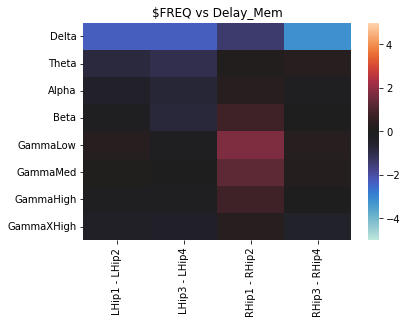

In [ ]:
make_heatmap(power_mem_both, '$FREQ', 'Delay_Mem')

RHip1 - RHip2 Theta: r = 0.8924740585703183, p = 0.04163629905650814
RHip1 - RHip2 Alpha: r = 0.9210090854112726, p = 0.02633211482123678
RHip1 - RHip2 Beta: r = 0.8943852675767703, p = 0.040543200209300634
RHip3 - RHip4 Delta: r = -0.969911956498168, p = 0.030088043501832026
RHip3 - RHip4 Alpha: r = 0.9556642283242046, p = 0.044335771675795395


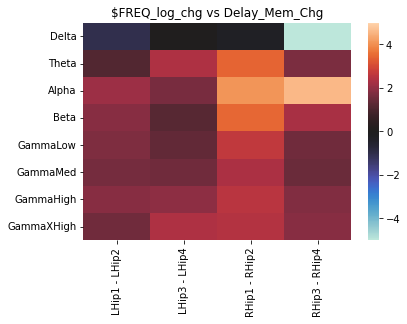

In [ ]:
make_heatmap(power_mem_delay, '$FREQ_log_chg', 'Delay_Mem_Chg')

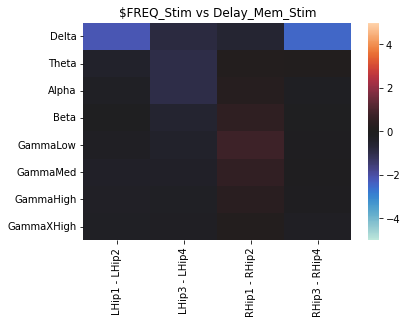

In [ ]:
make_heatmap(power_mem_delay, '$FREQ_Stim', 'Delay_Mem_Stim')

LHip3 - LHip4 Delta: r = -0.878584273509879, p = 0.04985105567374274


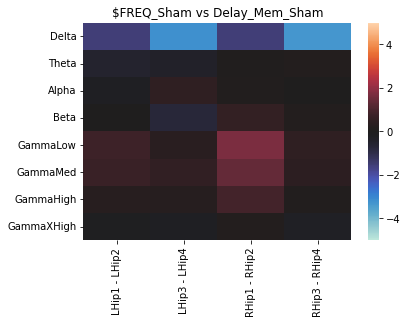

In [ ]:
make_heatmap(power_mem_delay, '$FREQ_Sham', 'Delay_Mem_Sham')

In [ ]:
pt_nums

[100, 109, 110, 111, 112, 113, 115]

In [ ]:
temp = memory_trials[np.isin(memory_trials.index, pt_nums)]
temp['Avg_Sham'].mean(), temp['Memory_Score'].mean()

(6.888888888833333, 6.666666666666667)

In [ ]:
from stats_pipeline import do_stats

Averaging across stims in the same patient, channel, and trial
Fisher Exact P-value = 0.33484162895927627 for Theta band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        7        2
       Increase        4        4

Fisher Exact P-value = 0.08235294117647061 for Delta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        3        5

Fisher Exact P-value = 0.34693541752365364 for Beta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        5        3

Fisher Exact P-value = 0.15343480049362435 for GammaLow band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        6        2

Fisher Exact P-value = 0.34693541752365364 for GammaMed band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        5        3

Fisher Exact P-value = 0.15343480049362415 for GammaHigh band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        2        7
       Increase        5        3

Fisher Exact P-value = 0.00904977375565612 for GammaXHigh band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        5        3

Fisher Exact P-value = 0.2087912087912086 for Beta band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        3        5

Fisher Exact P-value = 0.13752913752913742 for GammaLow band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        1        5
       Increase        5        3

Fisher Exact P-value = 0.009657009657009651 for GammaMed band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        6        2

Fisher Exact P-value = 0.47252747252747207 for GammaXHigh band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        2        6

Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.158189  0.530709
1   LHip1 - LHip2       Theta -0.061348  0.808919
2   LHip1 - LHip2       Alpha -0.249119  0.318825
3   LHip1 - LHip2        Beta -0.052225  0.836944
4   LHip1 - LHip2    GammaLow  0.054840  0.828890
5   LHip1 - LHip2    GammaMed -0.204460  0.415746
6   LHip1 - LHip2   GammaHigh -0.215082  0.391389
7   LHip1 - LHip2  GammaXHigh -0.350036  0.154452
8   LHip3 - LHip4       Delta -0.404081  0.096292
9   LHip3 - LHip4       Theta -0.398277  0.101632
10  LHip3 - LHip4       Alpha -0.186982  0.457521
11  LHip3 - LHip4        Beta -0.207189  0.409412
12  LHip3 - LHip4    GammaLow -0.069996  0.782558
13  LHip3 - LHip4    GammaMed -0.398896  0.101053
14  LHip3 - LHip4   GammaHigh -0.421006  0.081881
15  LHip3 - LHip4  GammaXHigh -0.439968  0.067683
16  RHip1 - RHip2       Delta  0.142065  0.573894
17  RHip1 - RHip2       Theta  0.159644  0.526887
18  RHip1 - RHip2       Alpha -0.075827  0.764907
19  RHip1 - RHip2        Beta -0.137228  0.587136
20  RHip1 - RHip2    GammaLow -0.473254  0.047293
21  RHip1 - RHip2    GammaMed -0.253374  0.310353
22  RHip1 - RHip2   GammaHigh  0.087512  0.729876
23  RHip1 - RHip2  GammaXHigh  0.025362  0.920431
24  RHip3 - RHip4       Delta -0.057306  0.839249
25  RHip3 - RHip4       Theta -0.099766  0.723521
26  RHip3 - RHip4       Alpha -0.194105  0.488193
27  RHip3 - RHip4        Beta -0.393530  0.146713
28  RHip3 - RHip4    GammaLow -0.319861  0.245156
29  RHip3 - RHip4    GammaMed -0.688006  0.004579
30  RHip3 - RHip4   GammaHigh -0.239790  0.389351
31  RHip3 - RHip4  GammaXHigh -0.184945  0.509333

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

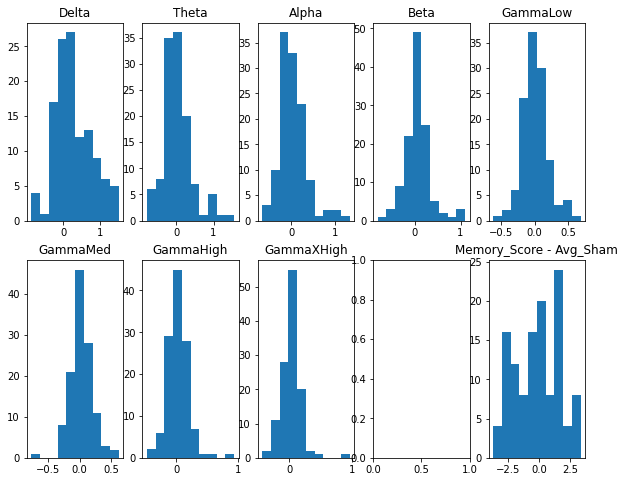

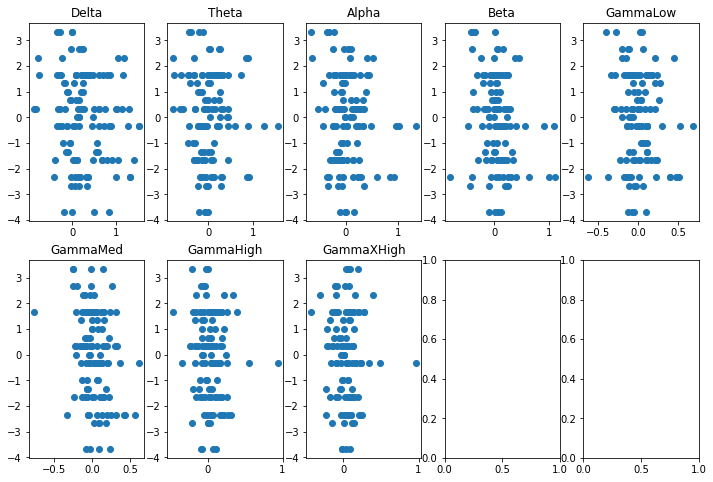

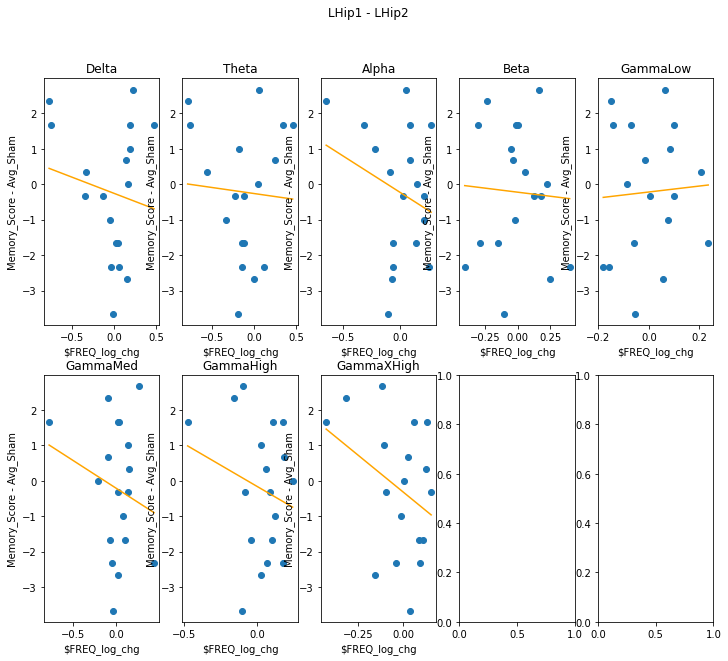

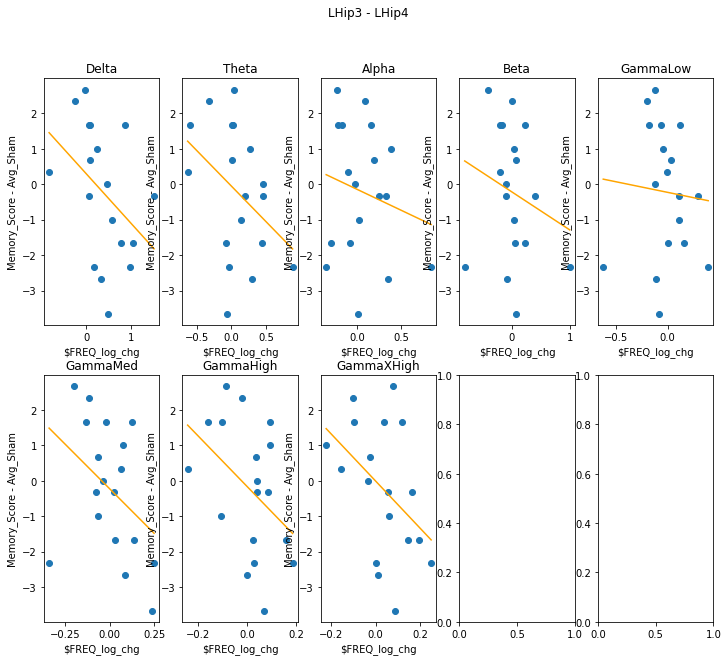

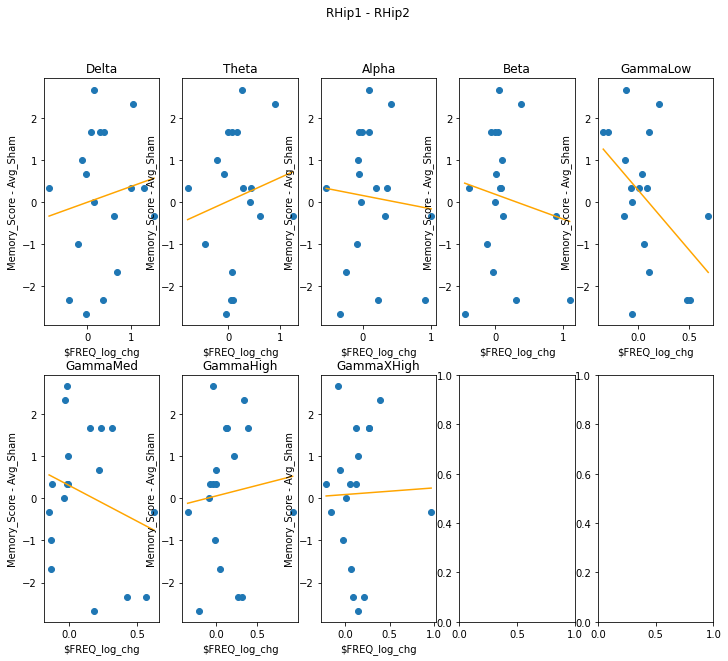

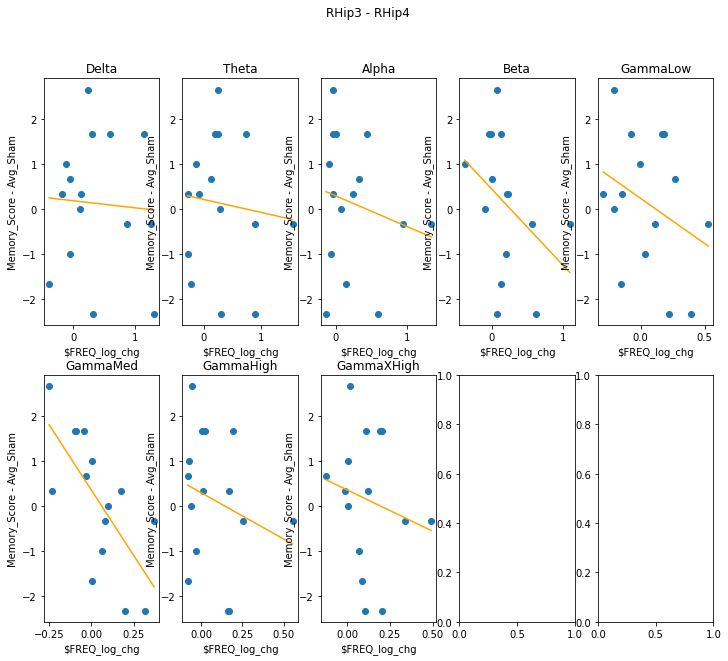

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham', freqs=freqs, mem_null_hyp=0)

Averaging across stims in the same patient, channel, and trial


Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.310598  0.209675
1   LHip1 - LHip2       Theta -0.248375  0.320320
2   LHip1 - LHip2       Alpha -0.176318  0.484013
3   LHip1 - LHip2        Beta -0.036591  0.885387
4   LHip1 - LHip2    GammaLow  0.043465  0.864030
5   LHip1 - LHip2    GammaMed -0.031858  0.900136
6   LHip1 - LHip2   GammaHigh -0.078432  0.757059
7   LHip1 - LHip2  GammaXHigh  0.009490  0.970188
8   LHip3 - LHip4       Delta -0.493652  0.037342
9   LHip3 - LHip4       Theta -0.508469  0.031186
10  LHip3 - LHip4       Alpha -0.369855  0.130872
11  LHip3 - LHip4        Beta -0.324763  0.188537
12  LHip3 - LHip4    GammaLow -0.239836  0.337772
13  LHip3 - LHip4    GammaMed -0.081130  0.748953
14  LHip3 - LHip4   GammaHigh -0.042513  0.866982
15  LHip3 - LHip4  GammaXHigh -0.011537  0.963761
16  RHip1 - RHip2       Delta  0.144308  0.567798
17  RHip1 - RHip2       Theta  0.198140  0.430610
18  RHip1 - RHip2       Alpha  0.229676  0.359237
19  RHip1 - RHip2        Beta  0.347252  0.157983
20  RHip1 - RHip2    GammaLow  0.485781  0.040970
21  RHip1 - RHip2    GammaMed  0.595896  0.009062
22  RHip1 - RHip2   GammaHigh  0.472374  0.047763
23  RHip1 - RHip2  GammaXHigh  0.326678  0.185793
24  RHip3 - RHip4       Delta  0.082495  0.770070
25  RHip3 - RHip4       Theta  0.106330  0.706054
26  RHip3 - RHip4       Alpha  0.072973  0.796060
27  RHip3 - RHip4        Beta  0.092404  0.743265
28  RHip3 - RHip4    GammaLow  0.349483  0.201657
29  RHip3 - RHip4    GammaMed  0.304299  0.270151
30  RHip3 - RHip4   GammaHigh  0.199920  0.474995
31  RHip3 - RHip4  GammaXHigh  0.043963  0.876372

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

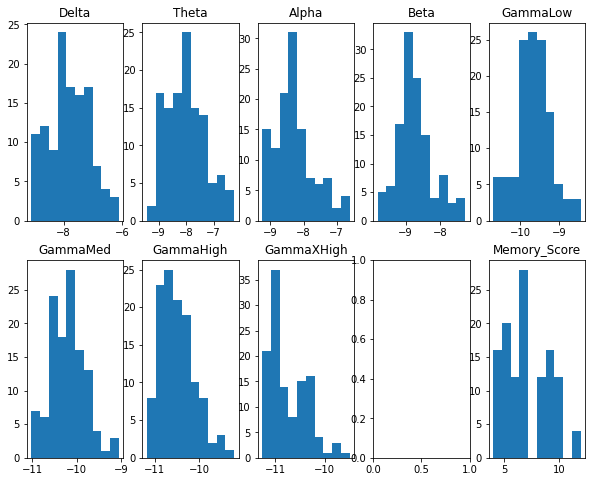

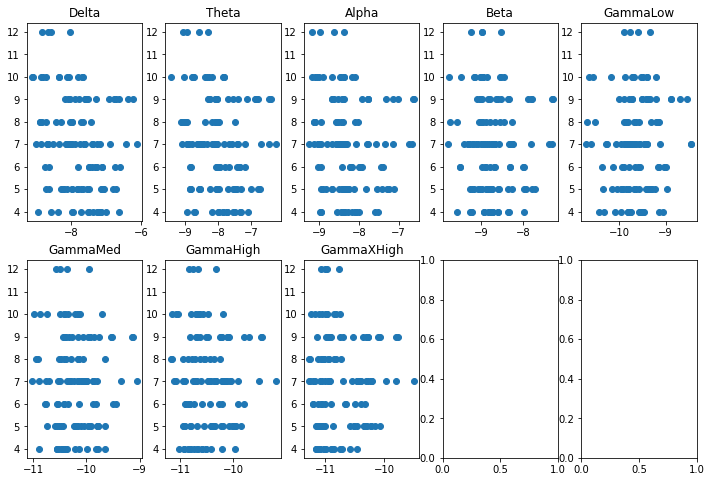

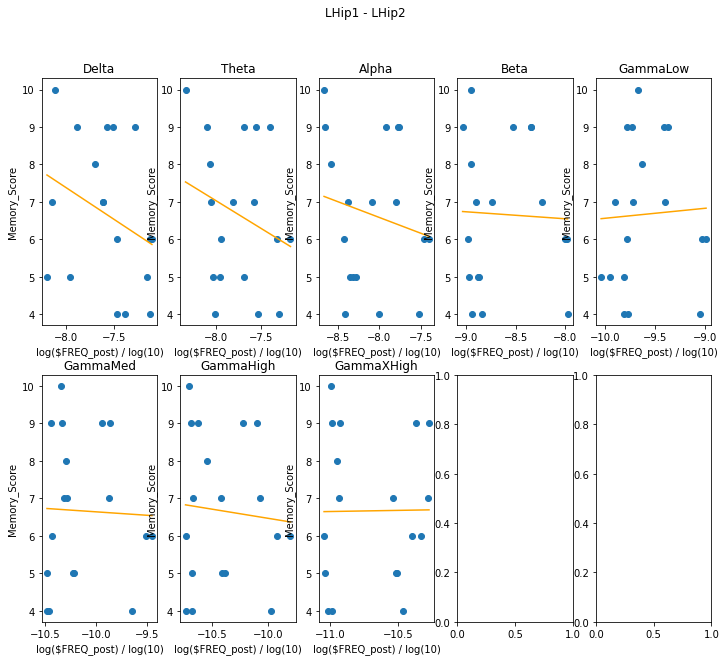

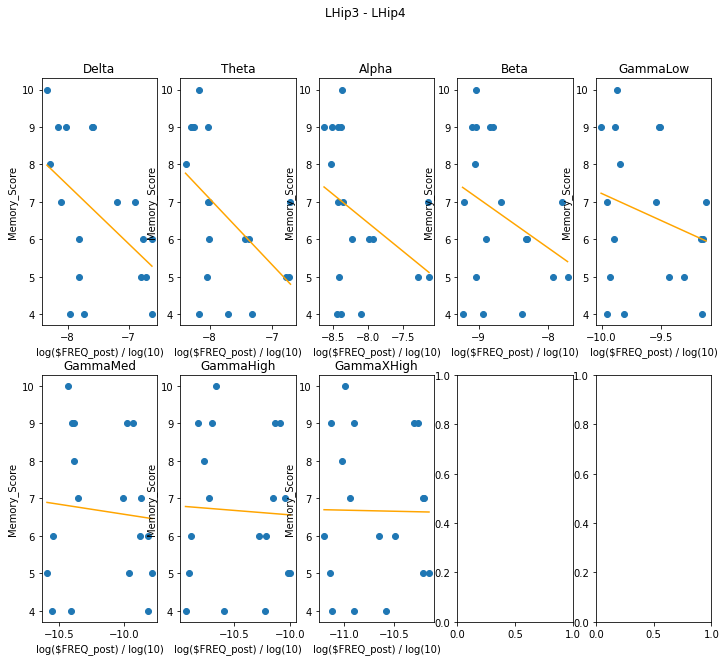

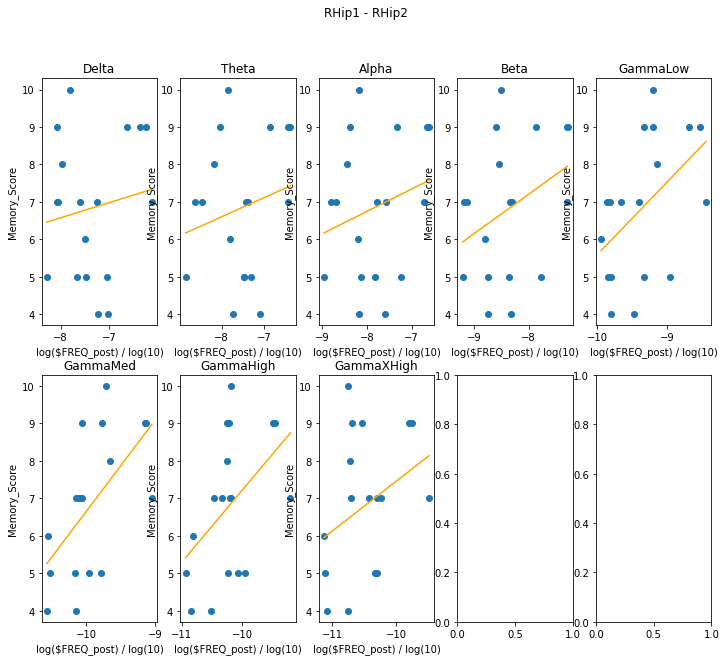

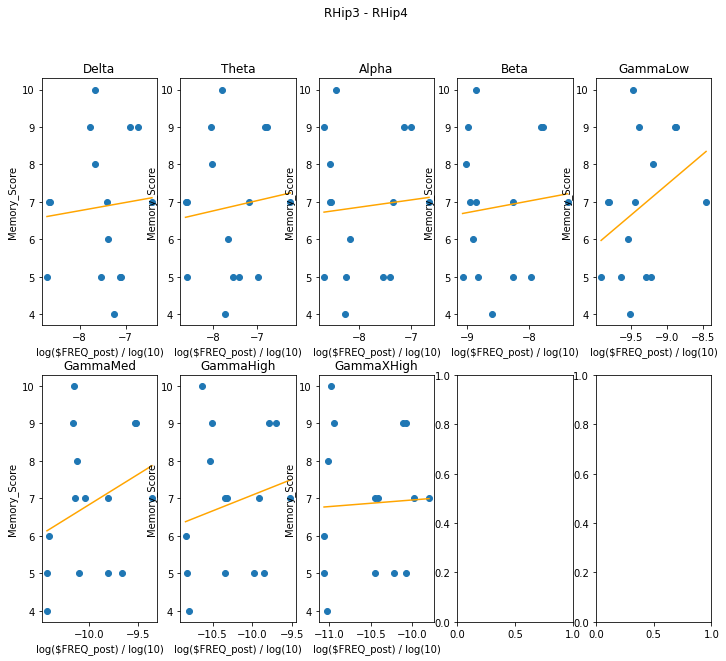

In [ ]:
do_stats(power_and_mem, 'log($FREQ_post) / log(10)', 'Memory_Score', freqs=freqs, mem_null_hyp=7)

Averaging across stims in the same patient, channel, and trial


Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.098956  0.696053
1   LHip1 - LHip2       Theta -0.157925  0.531403
2   LHip1 - LHip2       Alpha -0.046598  0.854325
3   LHip1 - LHip2        Beta  0.031576  0.901017
4   LHip1 - LHip2    GammaLow  0.041213  0.871017
5   LHip1 - LHip2    GammaMed  0.082263  0.745556
6   LHip1 - LHip2   GammaHigh  0.079792  0.752970
7   LHip1 - LHip2  GammaXHigh  0.142276  0.573319
8   LHip3 - LHip4       Delta -0.245104  0.326940
9   LHip3 - LHip4       Theta -0.223865  0.371855
10  LHip3 - LHip4       Alpha -0.207231  0.409315
11  LHip3 - LHip4        Beta -0.182384  0.468853
12  LHip3 - LHip4    GammaLow -0.213039  0.396012
13  LHip3 - LHip4    GammaMed  0.089455  0.724099
14  LHip3 - LHip4   GammaHigh  0.067329  0.790666
15  LHip3 - LHip4  GammaXHigh  0.054284  0.830601
16  RHip1 - RHip2       Delta -0.044637  0.860395
17  RHip1 - RHip2       Theta  0.030235  0.905201
18  RHip1 - RHip2       Alpha  0.189951  0.450278
19  RHip1 - RHip2        Beta  0.368982  0.131853
20  RHip1 - RHip2    GammaLow  0.692708  0.001440
21  RHip1 - RHip2    GammaMed  0.788630  0.000101
22  RHip1 - RHip2   GammaHigh  0.483590  0.042027
23  RHip1 - RHip2  GammaXHigh  0.308755  0.212533
24  RHip3 - RHip4       Delta -0.110626  0.694695
25  RHip3 - RHip4       Theta -0.028925  0.918498
26  RHip3 - RHip4       Alpha  0.059718  0.832567
27  RHip3 - RHip4        Beta  0.192667  0.491483
28  RHip3 - RHip4    GammaLow  0.638875  0.010353
29  RHip3 - RHip4    GammaMed  0.621698  0.013350
30  RHip3 - RHip4   GammaHigh  0.260736  0.347938
31  RHip3 - RHip4  GammaXHigh  0.036404  0.897514

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN  0.023037  0.003222        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
Channel                                                                   
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

Frequency      GammaXHigh  
Channel                    
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

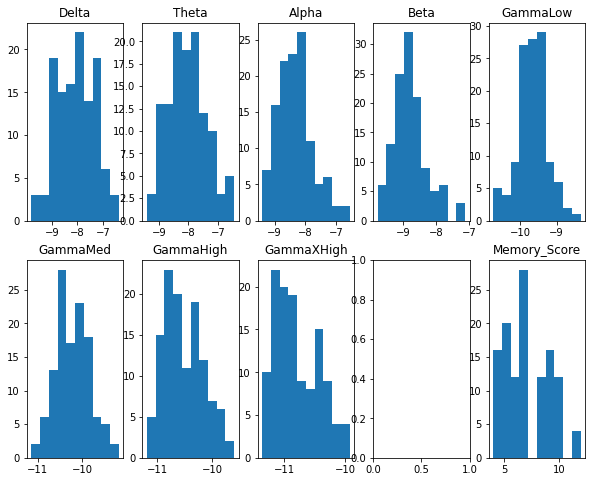

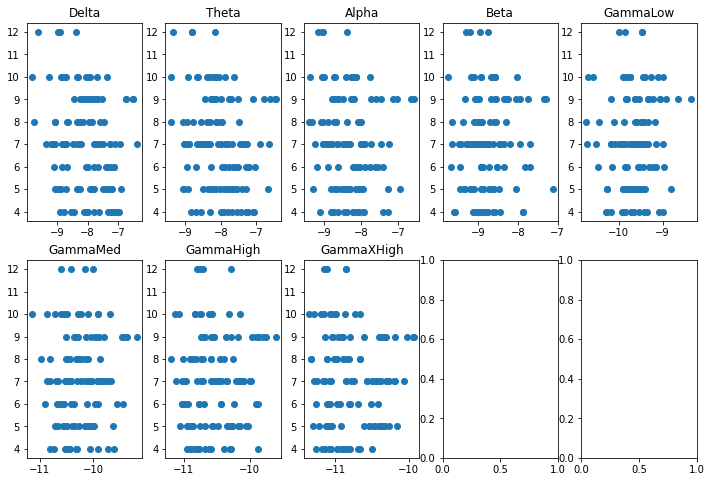

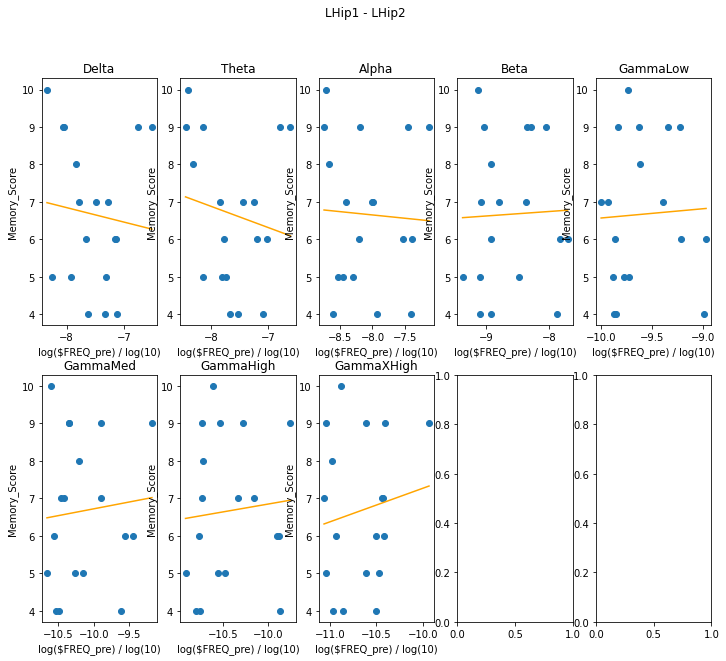

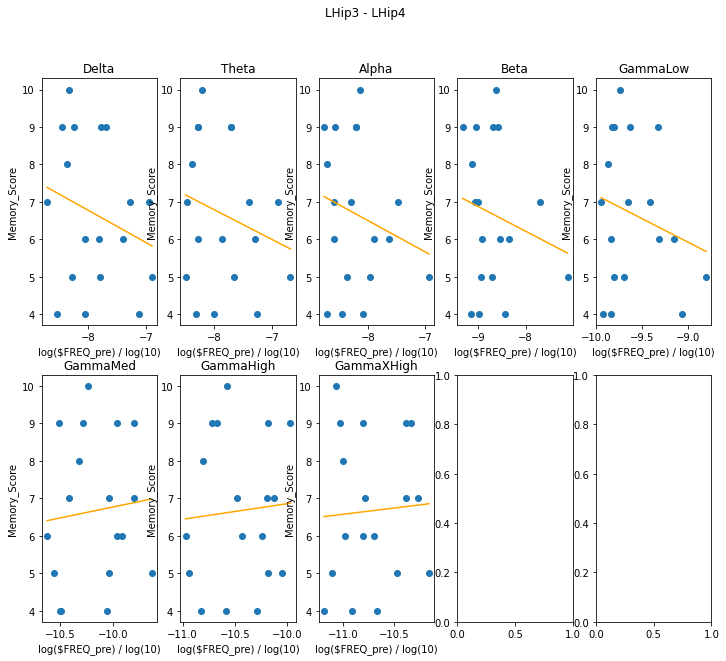

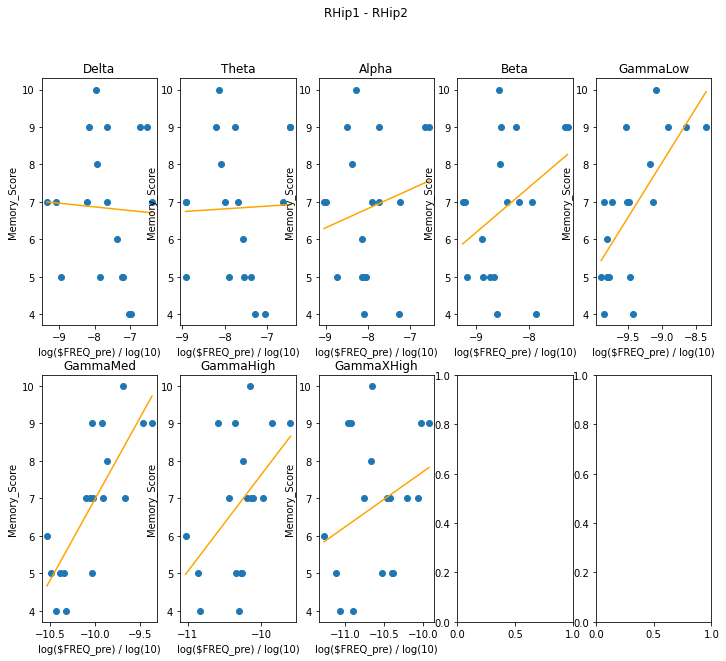

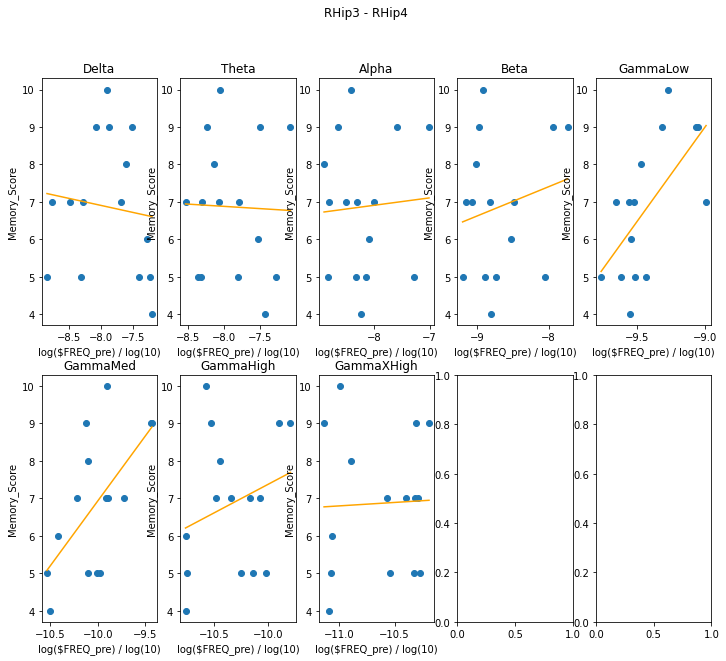

In [ ]:
do_stats(power_and_mem, 'log($FREQ_pre) / log(10)', 'Memory_Score', freqs=freqs, mem_null_hyp=7)

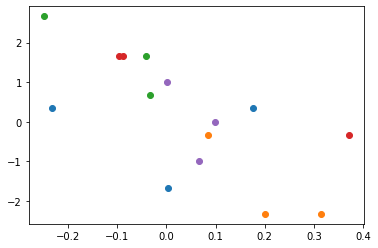

In [ ]:
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == 'RHip3 - RHip4']
fig, ax = plt.subplots()
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(power_for_pt['GammaMed_log_chg'], power_for_pt['Memory_Score'] - power_for_pt['Avg_Sham'])

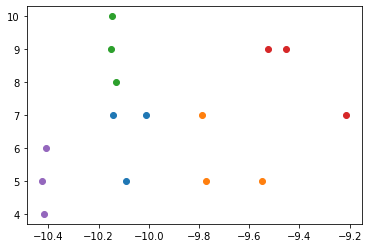

In [ ]:
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == 'RHip3 - RHip4']
fig, ax = plt.subplots()
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['GammaMed_post']), power_for_pt['Memory_Score'])

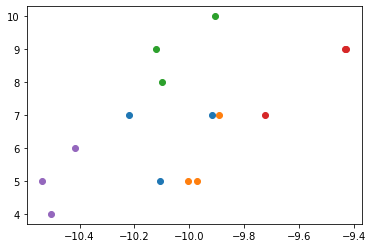

In [ ]:
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == 'RHip3 - RHip4']
fig, ax = plt.subplots()
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['GammaMed_pre']), power_for_pt['Memory_Score'])

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM  Dependent Variable:  GammaMed_log_chg
No. Observations:   58       Method:              REML            
No. Groups:         5        Scale:               0.0108          
Min. group size:    11       Log-Likelihood:      35.0976         
Max. group size:    12       Converged:           Yes             
Mean group size:    11.6                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               10.886    0.797 13.659 0.000  9.324 12.448
np.log10(GammaMed_post)  1.087    0.078 13.919 0.000  0.934  1.240
Group Var                0.138    1.008                           
==================================================================

"""

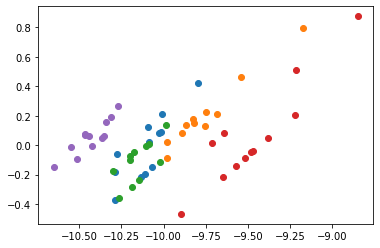

In [ ]:
import statsmodels.formula.api as smf
power_for_chan = power_and_mem[power_and_mem['Channel'] == 'RHip3 - RHip4']
fig, ax = plt.subplots()
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['GammaMed_post']), power_for_pt['GammaMed_log_chg'])
model = smf.mixedlm('GammaMed_log_chg ~ np.log10(GammaMed_post)', power_for_chan, groups=power_for_chan['ID'])
results = model.fit()
results.summary()

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:             MixedLM  Dependent Variable:  GammaMed_log_chg
No. Observations:  15       Method:              REML            
No. Groups:        5        Scale:               0.0335          
Min. group size:   3        Log-Likelihood:      2.0650          
Max. group size:   3        Converged:           Yes             
Mean group size:   3.0                                           
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              -0.525    1.844 -0.285 0.776 -4.140  3.090
np.log10(GammaMed_pre) -0.057    0.184 -0.307 0.759 -0.417  0.304
Group Var               0.000    0.069                           
=================================================================

"""

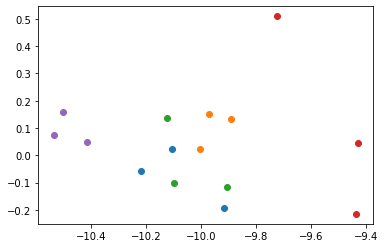

In [ ]:
import statsmodels.formula.api as smf
power_for_chan = power_and_mem[(power_and_mem['Channel'] == 'RHip3 - RHip4') & (power_and_mem['Stim_Num'] == 1)]
fig, ax = plt.subplots()
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['GammaMed_pre']), power_for_pt['GammaMed_log_chg'])
model = smf.mixedlm('GammaMed_log_chg ~ np.log10(GammaMed_pre)', power_for_chan, groups=power_for_chan['ID'])
results = model.fit()
results.summary()

RHip1 - RHip2 GammaLow: r = -0.47325430888691117, p = 0.04729264028187781
RHip3 - RHip4 GammaMed: r = -0.6880062282431453, p = 0.004578923396548213


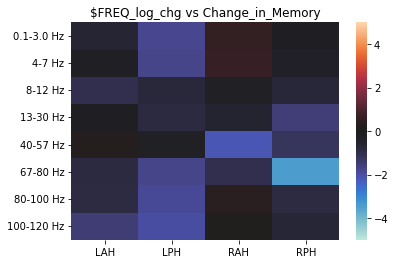

In [ ]:
from stats_pipeline import make_heatmap_linreg
power_mem_trial['Change_in_Memory'] = power_mem_trial['Memory_Score'] - power_mem_trial['Avg_Sham']
make_heatmap_linreg(power_mem_trial, '$FREQ_log_chg', 'Change_in_Memory', freqs)

# Stim Effect by Patient

In [ ]:
import scipy.stats
from stats_pipeline import fdr_bh

mne.set_log_level('WARNING')
pt_nums = [100, 109, 110, 111, 112, 113, 115]
def stim_effects_for_pt(pt_num):
    pre_epochs_master = [[], [], [], []]
    
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        epochs = mne.Epochs(raw, evts, event_id=1, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

        # drop segments that overlap with shocks
        # i.e. those that are shorter than 1 second. May change tmax in the future
        epochs.drop_bad()
        pre_epochs_master[i].append(epochs)
                
    post_epochs_master = [[], [], [], []]
    
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        epochs = mne.Epochs(raw, evts, event_id=2, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

        # drop segments that overlap with shocks
        # i.e. those that are shorter than 1 second. May change tmax in the future
        epochs.drop_bad()
        post_epochs_master[i].append(epochs)

    # all_hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

    pvals = []
    tvals = []
    bands = [(0.1, 3), (4,7), (8,12), (13,30), (40, 60), (60, 80), (80, 100), (100, 120)]
    band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']
    for i, chan in enumerate(raw.info['ch_names']):
        curr_p = {'Channel': chan}
        curr_t = {'Channel': chan}
        if len(pre_epochs_master[i]) == 0:
            continue
        for j, (lo, hi) in enumerate(bands):
            pre_psds, _pre_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(pre_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
            pre_psds = np.log10(pre_psds) - np.log10(1e-12)

            post_psds, post_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(post_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
            post_psds = np.log10(post_psds) - np.log10(1e-12)

            result = scipy.stats.ttest_ind(post_psds.flatten(), pre_psds.flatten())
            curr_p[band_labels[j]] = result.pvalue
            curr_t[band_labels[j]] = result.statistic
        pvals.append(curr_p)
        tvals.append(curr_t)

    ttest_pvals = pd.DataFrame(pvals).set_index('Channel')
    ttest_tvals = pd.DataFrame(tvals).set_index('Channel')

    return ttest_tvals, ttest_pvals

In [ ]:
power_every_pre = pd.read_csv('pre_post_stim.csv')

In [ ]:
import scipy.stats
from stats_pipeline import fdr_bh

mne.set_log_level('WARNING')
pt_nums = [100, 109, 110, 111, 112, 113, 115]
def stim_effects_for_pt(pt_num):
    power_for_pt = power_every_pre[power_every_pre['ID'] == pt_num]
    all_hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

    pvals = []
    tvals = []
    band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']
    for chan in all_hip_chans:
        curr_p = {'Channel': chan}
        curr_t = {'Channel': chan}
        for j, freq in enumerate(band_labels):
            power_for_chan = power_for_pt[power_for_pt['Channel'] == chan]
            result = scipy.stats.ttest_1samp(power_for_chan[freq+'_log_chg'], 0)
            # result = scipy.stats.ttest_ind(np.log10(power_for_chan[freq+'_post']), np.log10(power_for_chan[freq+'_pre']))
            curr_p[band_labels[j]] = result.pvalue
            curr_t[band_labels[j]] = result.statistic
        pvals.append(curr_p)
        tvals.append(curr_t)

    ttest_pvals = pd.DataFrame(pvals).set_index('Channel')
    ttest_tvals = pd.DataFrame(tvals).set_index('Channel')

    return ttest_tvals, ttest_pvals

In [ ]:
import scipy.stats
from stats_pipeline import fdr_bh

mne.set_log_level('WARNING')
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
def stim_effects_for_pt(pt_num):
    power_pt_pre = results_before_after[~results_before_after['Stim'] & (results_before_after['ID'] == pt_num)]
    power_pt_post = results_before_after[results_before_after['Stim'] & (results_before_after['ID'] == pt_num)]
    all_hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

    pvals = []
    tvals = []
    band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']
    for chan in all_hip_chans:
        curr_p = {'Channel': chan}
        curr_t = {'Channel': chan}
        for j, freq in enumerate(band_labels):
            power_chan_pre = power_pt_pre[power_pt_pre['Channel'] == chan]
            power_chan_post = power_pt_post[power_pt_post['Channel'] == chan]
            # result = scipy.stats.ttest_1samp(power_for_chan[freq+'_log_chg'], 0)
            result = scipy.stats.ttest_ind(np.log10(power_chan_post[freq]), np.log10(power_chan_pre[freq]))
            curr_p[band_labels[j]] = result.pvalue
            curr_t[band_labels[j]] = result.statistic
        pvals.append(curr_p)
        tvals.append(curr_t)

    ttest_pvals = pd.DataFrame(pvals).set_index('Channel')
    ttest_tvals = pd.DataFrame(tvals).set_index('Channel')

    print(len(power_chan_pre), len(power_chan_post))
    return ttest_tvals, ttest_pvals

100:


c:\Users\seand\eeg_proj\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\seand\eeg_proj\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\seand\eeg_proj\venv\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\seand\eeg_proj\venv\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\seand\eeg_proj\venv\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


105:
109:
110:
111:
112:
113:
115:


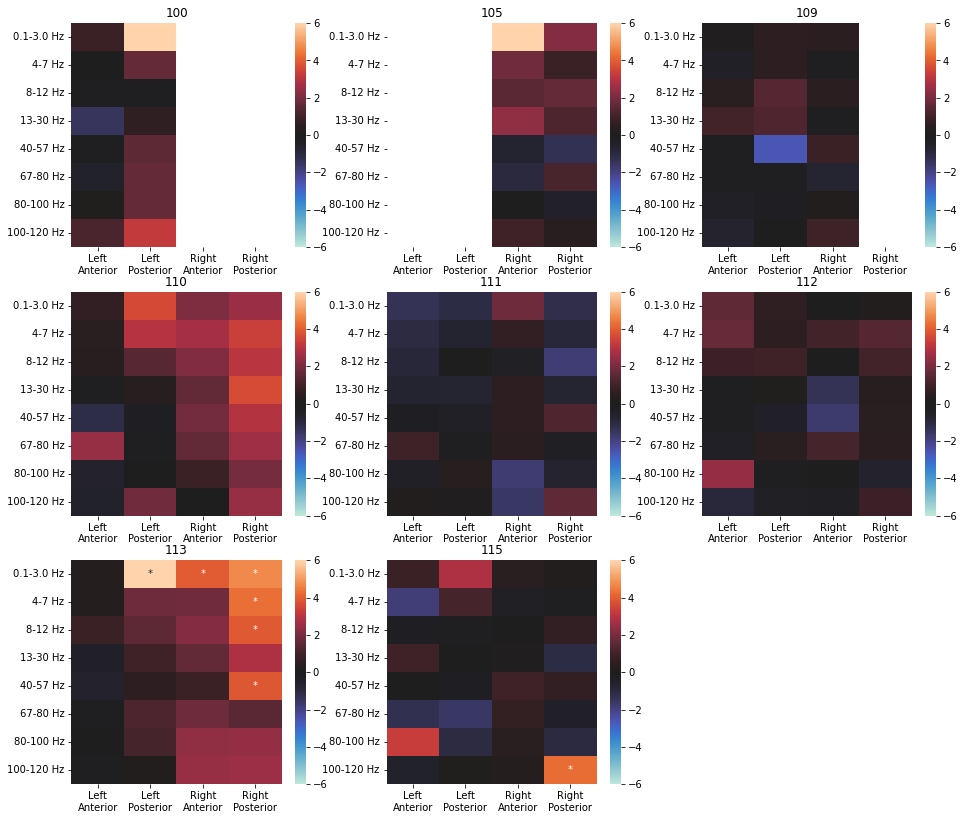

In [ ]:
from IPython.display import display
from seaborn import heatmap
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(16, 14)
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]

formal_freqs = freqs.copy()
formal_freqs[0]  = '0.1-3.0 Hz'
formal_freqs[1]  = '4-7 Hz'
formal_freqs[2]  = '8-12 Hz'
formal_freqs[3]  = '13-30 Hz'
formal_freqs[-4] = '40-57 Hz'
formal_freqs[-3] = '67-80 Hz'
formal_freqs[-2] = '80-100 Hz'
formal_freqs[-1] = '100-120 Hz'

for i, pt in enumerate(pt_nums):
    print(str(pt) + ":")
    df, pvals = stim_effects_for_pt(pt)
    p_stars = np.where(fdr_bh(pvals.transpose()) < 0.05, '*', '')
    heatmap(df.values.T, ax=axs[i//3, i%3], vmin=-6, vmax=6, 
        center=0, annot=p_stars, fmt='', 
        xticklabels=['Left\nAnterior', 'Left\nPosterior', 'Right\nAnterior', 'Right\nPosterior'],
        yticklabels=formal_freqs)
    axs[i//3, i%3].set_title(pt)
fig.delaxes(axs[2,2])

In [ ]:
import scipy.stats
from stats_pipeline import fdr_bh

mne.set_log_level('WARNING')
pt_nums = [100, 109, 110, 111, 112, 113, 115]
def stim_effects_violin(pt_num, ax):
    pre_epochs_master = [[], [], [], []]
    
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        epochs = mne.Epochs(raw, evts, event_id=1, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

        # drop segments that overlap with shocks
        # i.e. those that are shorter than 1 second. May change tmax in the future
        epochs.drop_bad()
        pre_epochs_master[i].append(epochs)
                
    post_epochs_master = [[], [], [], []]
    
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    for i, chan in enumerate(raw.info['ch_names']):
        epochs = mne.Epochs(raw, evts, event_id=2, picks=chan, tmin=0, tmax=1, baseline=(0.5,1.0))

        # drop segments that overlap with shocks
        # i.e. those that are shorter than 1 second. May change tmax in the future
        epochs.drop_bad()
        post_epochs_master[i].append(epochs)

    # all_hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

    pvals = []
    tvals = []
    bands = [(0.1, 3), (4,7), (8,12), (13,30), (40, 60), (60, 80), (80, 100), (100, 120)]
    band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']
    for i, chan in enumerate(raw.info['ch_names']):
        curr_p = {'Channel': chan}
        curr_t = {'Channel': chan}
        if len(pre_epochs_master[i]) == 0:
            continue
        for j, (lo, hi) in enumerate(bands):
            pre_psds, _pre_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(pre_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
            pre_psds = np.log10(pre_psds) - np.log10(1e-12)

            post_psds, post_freqs = mne.time_frequency.psd_multitaper(mne.concatenate_epochs(post_epochs_master[i], on_mismatch='ignore'), picks=chan, fmin=lo, fmax=hi)
            post_psds = np.log10(post_psds) - np.log10(1e-12)

            result = scipy.stats.ttest_ind(post_psds.flatten(), pre_psds.flatten())
            curr_p[band_labels[j]] = result.pvalue
            curr_t[band_labels[j]] = result.statistic
        pvals.append(curr_p)
        tvals.append(curr_t)

    ttest_pvals = pd.DataFrame(pvals).set_index('Channel')
    ttest_tvals = pd.DataFrame(tvals).set_index('Channel')

    new_tp = fdr_bh(ttest_pvals)
    return ttest_tvals #[new_tp < 0.05]

100:


NameError: name 'stim_effects_for_pt' is not defined

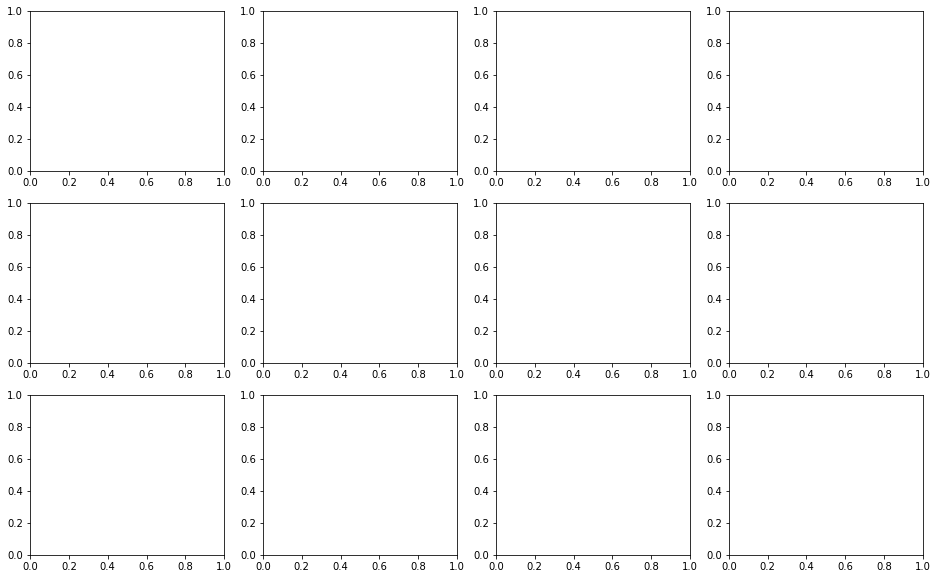

In [ ]:
fig, axs = plt.subplots(3, 4)
fig.set_size_inches(16, 10)
for i, pt in enumerate(pts_w_any_stim):
    print(str(pt) + ":")
    df = stim_effects_for_pt(pt)
    axs[i//4, i%4].violinplot([power_for_chan['Delta_log_chg'], power_log_chg['Theta_log_chg'], power_log_chg['Alpha_log_chg'], power_log_chg['Beta_log_chg'], power_log_chg['Gamma_log_chg']])

Pt 113 and 115 have the same stim pattern, but 113 has a higher current/density. However, 113 shows an increase in power in the RHip in all frequencies, whereas 115 has mostly no significant change.

Overall, I don't see any pattern. A few people have channel-wide increases in power and a few have decreases, but for the most part, the significant changes are sporadic. This leads me to the hypothesis that regardless of the stim pattern, stimulation does not routinely increase or decrease ECoG power in any particular channels; rather, it increases powers that are low and decreases those that are high, bringing everything back to a certain baseline. How can I test this hypothesis?

My hypothesis is that the change in power is inversely proportional to, or negatively correlated with, the pre-stim power. I've already tested this with the current data, and the problem is that I have 3 changes for each pre-stim, so it was hard to tell. I relabeled the data to give each post-stim its own pre-stim epoch, so we can use that for more fine-grained comparisons such as this one.

In [ ]:
pt_nums = [100, 105, 109, 110, 111, 112, 113, 115]
mem_res = memory_trials[memory_trials.index.isin(pt_nums)].groupby('ID').mean()
import scipy.stats
scipy.stats.ttest_rel(mem_res['Memory_Score'], mem_res['Avg_Sham'])
mem_res

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667      5.333333    2.0
105  6.666667      6.333333    2.0
109  6.666667      6.666667    2.0
110  7.333333      5.666667    2.0
112  7.333333      9.000000    2.0
113  7.333333      8.333333    2.0
115  5.000000      5.000000    2.0

# Results

|  | Left Ant | Left Post | Right Ant | Right Post |
|---|---|---|---|---|
| Delta |  | POST stim vs RAW mem - simple<br>POST stim vs RAW mem - multiple<br>POST stim vs RAW mem - mixed<br>*POST stim vs CHG mem - simple* |  |  |
| Theta |  | POST stim vs RAW mem - simple<br>POST stim vs CHG mem - simple |  |  |
| Alpha |  | POST stim vs CHG mem - simple |  |  |
| Beta |  | PRE stim vs CHG mem + mixed<br>POST stim vs RAW mem + mixed<br>POST stim vs CHG mem - simple |  |  |
| GammaLow |  | PRE stim vs CHG mem - simple<br>PRE stim vs CHG mem - multiple<br>POST stim vs CHG mem - simple | PRE stim vs RAW mem + simple<br>PRE stim vs CHG mem + simple<br>CHG stim vs RAW mem - mixed<br>CHG stim vs CHG mem - simple<br>CHG stim vs CHG mem - multiple<br>CHG stim vs CHG mem - mixed | PRE stim vs RAW mem + simple<br>PRE stim vs CHG mem + simple |
| GammaMed |  | PRE stim vs RAW mem + multiple | PRE stim vs RAW mem + simple<br>PRE stim vs RAW mem + mixed<br>PRE stim vs CHG mem + simple<br>POST stim vs RAW mem + simple | PRE stim vs RAW mem + simple<br>PRE stim vs RAW mem + multiple<br>PRE stim vs RAW mem + mixed<br>PRE stim vs CHG mem + multiple<br>PRE stim vs CHG mem + mixed<br>CHG stim vs RAW mem - simple<br>CHG stim vs RAW mem - multiple<br>CHG stim vs CHG mem - simple<br>CHG stim vs CHG mem - multiple |
| GammaHigh | POST stim vs CHG mem - multiple |  | PRE stim vs RAW mem + simple<br>CHG stim vs RAW mem - mixed<br>CHG stim vs CHG mem + mixed | PRE stim vs CHG mem - multiple<br>PRE stim vs CHG mem - mixed |
| GammaXHigh |  |  |  |  |
| F-test |  | POST stim vs RAW mem = 0.039<br>POST stim vs CHG mem = 0.037 | PRE stim vs RAW mem = 0.025<br>CHG stim vs CHG mem = 0.036 | PRE stim vs RAW mem = 0.022<br>PRE stim vs CHG mem = 0.020 |